Machine Learning Project: Analysis of patient bladder diary data using catch22 feature sets

### Jiaxiang E and Shaofeng Kang

##Library and Imports

In [ ]:
!pip install scipy numpy pandas

In [ ]:
from google.colab import drive
from pathlib import Path
drive.mount('/content/drive')

ROOT_PATH = Path('/content/drive/MyDrive/Colab Notebooks/ECE 2500Y')

Mounted at /content/drive


In [ ]:
import scipy.io
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from scipy import stats
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from sklearn.decomposition import PCA


dataset_A_path = ROOT_PATH / 'Dataset_A(days1_3).mat'
dataset_A = scipy.io.loadmat(dataset_A_path)
dataset_B_path = ROOT_PATH / 'Dataset_B(days1_3).mat'
dataset_B = scipy.io.loadmat(dataset_B_path)

In [ ]:
import pickle
import os

if not os.path.exists(ROOT_PATH):
    os.makedirs(ROOT_PATH)

file_path = os.path.join(ROOT_PATH, 'dataset_A.pickle')

with open('dataset_A.pickle', 'wb') as handle:
    pickle.dump(dataset_A, handle, protocol=pickle.HIGHEST_PROTOCOL)

file_path = os.path.join(ROOT_PATH, 'dataset_B.pickle')

with open('dataset_B.pickle', 'wb') as handle:
    pickle.dump(dataset_B, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('dataset_A.pickle', 'rb') as handle:
    loaded_dataset_A = pickle.load(handle)

with open('dataset_B.pickle', 'rb') as handle:
    loaded_dataset_B = pickle.load(handle)

In [ ]:
participant_baseline_data_A = dataset_A.get('Participants', 'Unknown')
participant_12_weeks_data_A = dataset_A.get('Participants_12weeks', 'Unknown')
participant_baseline_data_B = dataset_B.get('Participants', 'Unknown')
participant_12_weeks_data_B = dataset_B.get('Participants_12weeks', 'Unknown')

In [ ]:
print("Array Type:", type(participant_baseline_data_A))
print("Shape:", participant_baseline_data_A.shape)
print("Data Type:", participant_baseline_data_A.dtype)
print("Dimensions:", participant_baseline_data_A.ndim)

for i, item in enumerate(participant_baseline_data_A):
    print(f"Element {i} is a {type(item)}")
    if isinstance(item, np.ndarray):
        print(f"  Shape of element {i}: {item.shape}")
        print(f"  Data type of element {i}: {item.dtype}")
    else:
        print(f"  Content of element {i}: {item}")

Array Type: <class 'numpy.ndarray'>
Shape: (1, 21)
Data Type: [('Day1', 'O'), ('Day2', 'O'), ('Day3', 'O')]
Dimensions: 2
Element 0 is a <class 'numpy.ndarray'>
  Shape of element 0: (21,)
  Data type of element 0: [('Day1', 'O'), ('Day2', 'O'), ('Day3', 'O')]


In [ ]:
day1_data_A_Base = participant_baseline_data_A[0]['Day1']

print("Array Type:", type(day1_data_A_Base))
print("Shape:", day1_data_A_Base.shape)
print("Data Type:", day1_data_A_Base.dtype)
print("Dimensions:", day1_data_A_Base.ndim)

for i, item in enumerate(day1_data_A_Base):
    print(f"Element {i} is a {type(item)}")
    if isinstance(item, np.ndarray):
        print(f"  Shape of element {i}: {item.shape}")
        print(f"  Data type of element {i}: {item.dtype}")
    else:
        print(f"  Content of element {i}: {item}")

Array Type: <class 'numpy.ndarray'>
Shape: (21,)
Data Type: object
Dimensions: 1
Element 0 is a <class 'numpy.ndarray'>
  Shape of element 0: (11, 6)
  Data type of element 0: float64
Element 1 is a <class 'numpy.ndarray'>
  Shape of element 1: (12, 6)
  Data type of element 1: float64
Element 2 is a <class 'numpy.ndarray'>
  Shape of element 2: (10, 6)
  Data type of element 2: float64
Element 3 is a <class 'numpy.ndarray'>
  Shape of element 3: (10, 6)
  Data type of element 3: float64
Element 4 is a <class 'numpy.ndarray'>
  Shape of element 4: (12, 6)
  Data type of element 4: float64
Element 5 is a <class 'numpy.ndarray'>
  Shape of element 5: (9, 6)
  Data type of element 5: float64
Element 6 is a <class 'numpy.ndarray'>
  Shape of element 6: (7, 6)
  Data type of element 6: float64
Element 7 is a <class 'numpy.ndarray'>
  Shape of element 7: (9, 6)
  Data type of element 7: float64
Element 8 is a <class 'numpy.ndarray'>
  Shape of element 8: (9, 6)
  Data type of element 8: floa

In [ ]:
day2_data_A_Base = participant_baseline_data_A[0]['Day2']
day3_data_A_Base = participant_baseline_data_A[0]['Day3']

day1_data_B_Base = participant_baseline_data_B[0]['Day1']
day2_data_B_Base = participant_baseline_data_B[0]['Day2']
day3_data_B_Base = participant_baseline_data_B[0]['Day3']

day1_data_A_week12 = participant_12_weeks_data_A[0]['Day1']
day2_data_A_week12 = participant_12_weeks_data_A[0]['Day2']
day3_data_A_week12 = participant_12_weeks_data_A[0]['Day3']

day1_data_B_week12 = participant_12_weeks_data_B[0]['Day1']
day2_data_B_week12 = participant_12_weeks_data_B[0]['Day2']
day3_data_B_week12 = participant_12_weeks_data_B[0]['Day3']

In [ ]:
first_column_time_normalized_Base_A_day1 = np.concatenate([element[:, 0] for element in day1_data_A_Base])
second_column_trip_Base_A_day1 = np.concatenate([element[:, 1] for element in day1_data_A_Base])
third_column_accidental_leakages_Base_A_day1 = np.concatenate([element[:, 2] for element in day1_data_A_Base])
fourth_column_urge_Base_A_day1 = np.concatenate([element[:, 3] for element in day1_data_A_Base])
fifth_column_multitrip_Base_A_day1 = np.concatenate([element[:, 4] for element in day1_data_A_Base])
sixth_column_night_Base_A_day1 = np.concatenate([element[:, 5] for element in day1_data_A_Base])

first_column_time_normalized_Base_A_day2 = np.concatenate([element[:, 0] for element in day2_data_A_Base])
second_column_trip_Base_A_day2 = np.concatenate([element[:, 1] for element in day2_data_A_Base])
third_column_accidental_leakages_Base_A_day2 = np.concatenate([element[:, 2] for element in day2_data_A_Base])
fourth_column_urge_Base_A_day2 = np.concatenate([element[:, 3] for element in day2_data_A_Base])
fifth_column_multitrip_Base_A_day2 = np.concatenate([element[:, 4] for element in day2_data_A_Base])
sixth_column_night_Base_A_day2 = np.concatenate([element[:, 5] for element in day2_data_A_Base])

first_column_time_normalized_Base_A_day3 = np.concatenate([element[:, 0] for element in day3_data_A_Base])
second_column_trip_Base_A_day3 = np.concatenate([element[:, 1] for element in day3_data_A_Base])
third_column_accidental_leakages_Base_A_day3 = np.concatenate([element[:, 2] for element in day3_data_A_Base])
fourth_column_urge_Base_A_day3 = np.concatenate([element[:, 3] for element in day3_data_A_Base])
fifth_column_multitrip_Base_A_day3 = np.concatenate([element[:, 4] for element in day3_data_A_Base])
sixth_column_night_Base_A_day3 = np.concatenate([element[:, 5] for element in day3_data_A_Base])

first_column_time_normalized_Base_B_day1 = np.concatenate([element[:, 0] for element in day1_data_B_Base])
second_column_trip_Base_B_day1 = np.concatenate([element[:, 1] for element in day1_data_B_Base])
third_column_accidental_leakages_Base_B_day1 = np.concatenate([element[:, 2] for element in day1_data_B_Base])
fourth_column_urge_Base_B_day1 = np.concatenate([element[:, 3] for element in day1_data_B_Base])
fifth_column_multitrip_Base_B_day1 = np.concatenate([element[:, 4] for element in day1_data_B_Base])
sixth_column_night_Base_B_day1 = np.concatenate([element[:, 5] for element in day1_data_B_Base])

first_column_time_normalized_Base_B_day2 = np.concatenate([element[:, 0] for element in day2_data_B_Base])
second_column_trip_Base_B_day2 = np.concatenate([element[:, 1] for element in day2_data_B_Base])
third_column_accidental_leakages_Base_B_day2 = np.concatenate([element[:, 2] for element in day2_data_B_Base])
fourth_column_urge_Base_B_day2 = np.concatenate([element[:, 3] for element in day2_data_B_Base])
fifth_column_multitrip_Base_B_day2 = np.concatenate([element[:, 4] for element in day2_data_B_Base])
sixth_column_night_Base_B_day2 = np.concatenate([element[:, 5] for element in day2_data_B_Base])

first_column_time_normalized_Base_B_day3 = np.concatenate([element[:, 0] for element in day3_data_B_Base])
second_column_trip_Base_B_day3 = np.concatenate([element[:, 1] for element in day3_data_B_Base])
third_column_accidental_leakages_Base_B_day3 = np.concatenate([element[:, 2] for element in day3_data_B_Base])
fourth_column_urge_Base_B_day3 = np.concatenate([element[:, 3] for element in day3_data_B_Base])
fifth_column_multitrip_Base_B_day3 = np.concatenate([element[:, 4] for element in day3_data_B_Base])
sixth_column_night_Base_B_day3 = np.concatenate([element[:, 5] for element in day3_data_B_Base])

all_first_columns_Base = np.concatenate((first_column_time_normalized_Base_A_day1, first_column_time_normalized_Base_A_day2, first_column_time_normalized_Base_A_day3, first_column_time_normalized_Base_B_day1, first_column_time_normalized_Base_B_day2, first_column_time_normalized_Base_B_day3))
all_second_columns_Base = np.concatenate((second_column_trip_Base_A_day1, second_column_trip_Base_A_day2, second_column_trip_Base_A_day3, second_column_trip_Base_B_day1, second_column_trip_Base_B_day2, second_column_trip_Base_B_day3))
all_third_columns_Base = np.concatenate((third_column_accidental_leakages_Base_A_day1, third_column_accidental_leakages_Base_A_day2, third_column_accidental_leakages_Base_A_day3, third_column_accidental_leakages_Base_B_day1, third_column_accidental_leakages_Base_B_day2, third_column_accidental_leakages_Base_B_day3))
all_fourth_columns_Base = np.concatenate((fourth_column_urge_Base_A_day1, fourth_column_urge_Base_A_day2, fourth_column_urge_Base_A_day3, fourth_column_urge_Base_B_day1, fourth_column_urge_Base_B_day2, fourth_column_urge_Base_B_day3))
all_fifth_columns_Base = np.concatenate((fifth_column_multitrip_Base_A_day1, fifth_column_multitrip_Base_A_day2, fifth_column_multitrip_Base_A_day3, fifth_column_multitrip_Base_B_day1, fifth_column_multitrip_Base_B_day2, fifth_column_multitrip_Base_B_day3))
all_sixth_columns_Base = np.concatenate((sixth_column_night_Base_A_day1, sixth_column_night_Base_A_day2, sixth_column_night_Base_A_day3, sixth_column_night_Base_B_day1, sixth_column_night_Base_B_day2, sixth_column_night_Base_B_day3))

In [ ]:
first_column_time_normalized_week12_A_day1 = np.concatenate([element[:, 0] for element in day1_data_A_week12])
second_column_trip_week12_A_day1 = np.concatenate([element[:, 1] for element in day1_data_A_week12])
third_column_accidental_leakages_week12_A_day1 = np.concatenate([element[:, 2] for element in day1_data_A_week12])
fourth_column_urge_week12_A_day1 = np.concatenate([element[:, 3] for element in day1_data_A_week12])
fifth_column_multitrip_week12_A_day1 = np.concatenate([element[:, 4] for element in day1_data_A_week12])
sixth_column_night_week12_A_day1 = np.concatenate([element[:, 5] for element in day1_data_A_week12])

first_column_time_normalized_week12_A_day2 = np.concatenate([element[:, 0] for element in day2_data_A_week12])
second_column_trip_week12_A_day2 = np.concatenate([element[:, 1] for element in day2_data_A_week12])
third_column_accidental_leakages_week12_A_day2 = np.concatenate([element[:, 2] for element in day2_data_A_week12])
fourth_column_urge_week12_A_day2 = np.concatenate([element[:, 3] for element in day2_data_A_week12])
fifth_column_multitrip_week12_A_day2 = np.concatenate([element[:, 4] for element in day2_data_A_week12])
sixth_column_night_week12_A_day2 = np.concatenate([element[:, 5] for element in day2_data_A_week12])

first_column_time_normalized_week12_A_day3 = np.concatenate([element[:, 0] for element in day3_data_A_week12])
second_column_trip_week12_A_day3 = np.concatenate([element[:, 1] for element in day3_data_A_week12])
third_column_accidental_leakages_week12_A_day3 = np.concatenate([element[:, 2] for element in day3_data_A_week12])
fourth_column_urge_week12_A_day3 = np.concatenate([element[:, 3] for element in day3_data_A_week12])
fifth_column_multitrip_week12_A_day3 = np.concatenate([element[:, 4] for element in day3_data_A_week12])
sixth_column_night_week12_A_day3 = np.concatenate([element[:, 5] for element in day3_data_A_week12])

first_column_time_normalized_week12_B_day1 = np.concatenate([element[:, 0] for element in day1_data_B_week12])
second_column_trip_week12_B_day1 = np.concatenate([element[:, 1] for element in day1_data_B_week12])
third_column_accidental_leakages_week12_B_day1 = np.concatenate([element[:, 2] for element in day1_data_B_week12])
fourth_column_urge_week12_B_day1 = np.concatenate([element[:, 3] for element in day1_data_B_week12])
fifth_column_multitrip_week12_B_day1 = np.concatenate([element[:, 4] for element in day1_data_B_week12])
sixth_column_night_week12_B_day1 = np.concatenate([element[:, 5] for element in day1_data_B_week12])

first_column_time_normalized_week12_B_day2 = np.concatenate([element[:, 0] for element in day2_data_B_week12])
second_column_trip_week12_B_day2 = np.concatenate([element[:, 1] for element in day2_data_B_week12])
third_column_accidental_leakages_week12_B_day2 = np.concatenate([element[:, 2] for element in day2_data_B_week12])
fourth_column_urge_week12_B_day2 = np.concatenate([element[:, 3] for element in day2_data_B_week12])
fifth_column_multitrip_week12_B_day2 = np.concatenate([element[:, 4] for element in day2_data_B_week12])
sixth_column_night_week12_B_day2 = np.concatenate([element[:, 5] for element in day2_data_B_week12])

first_column_time_normalized_week12_B_day3 = np.concatenate([element[:, 0] for element in day3_data_B_week12])
second_column_trip_week12_B_day3 = np.concatenate([element[:, 1] for element in day3_data_B_week12])
third_column_accidental_leakages_week12_B_day3 = np.concatenate([element[:, 2] for element in day3_data_B_week12])
fourth_column_urge_week12_B_day3 = np.concatenate([element[:, 3] for element in day3_data_B_week12])
fifth_column_multitrip_week12_B_day3 = np.concatenate([element[:, 4] for element in day3_data_B_week12])
sixth_column_night_week12_B_day3 = np.concatenate([element[:, 5] for element in day3_data_B_week12])

all_first_columns_week12 = np.concatenate((first_column_time_normalized_week12_A_day1, first_column_time_normalized_week12_A_day2, first_column_time_normalized_week12_A_day3, first_column_time_normalized_week12_B_day1, first_column_time_normalized_week12_B_day2, first_column_time_normalized_week12_B_day3))
all_second_columns_week12 = np.concatenate((second_column_trip_week12_A_day1, second_column_trip_week12_A_day2, second_column_trip_week12_A_day3, second_column_trip_week12_B_day1, second_column_trip_week12_B_day2, second_column_trip_week12_B_day3))
all_third_columns_week12 = np.concatenate((third_column_accidental_leakages_week12_A_day1, third_column_accidental_leakages_week12_A_day2, third_column_accidental_leakages_week12_A_day3, third_column_accidental_leakages_week12_B_day1, third_column_accidental_leakages_week12_B_day2, third_column_accidental_leakages_week12_B_day3))
all_fourth_columns_week12 = np.concatenate((fourth_column_urge_week12_A_day1, fourth_column_urge_week12_A_day2, fourth_column_urge_week12_A_day3, fourth_column_urge_week12_B_day1, fourth_column_urge_week12_B_day2, fourth_column_urge_week12_B_day3))
all_fifth_columns_week12 = np.concatenate((fifth_column_multitrip_week12_A_day1, fifth_column_multitrip_week12_A_day2, fifth_column_multitrip_week12_A_day3, fifth_column_multitrip_week12_B_day1, fifth_column_multitrip_week12_B_day2, fifth_column_multitrip_week12_B_day3))
all_sixth_columns_week12 = np.concatenate((sixth_column_night_week12_A_day1, sixth_column_night_week12_A_day2, sixth_column_night_week12_A_day3, sixth_column_night_week12_B_day1, sixth_column_night_week12_B_day2, sixth_column_night_week12_B_day3))
all_fourth_columns_Base = np.where(np.isnan(all_fourth_columns_Base), 0, all_fourth_columns_Base)

In [ ]:
all_second_columns_week12_padded = np.pad(all_second_columns_week12,
                                          (0, 1108 - len(all_second_columns_week12)),
                                          mode='constant',
                                          constant_values=np.nan)
all_third_columns_week12_padded = np.pad(all_third_columns_week12,
                                          (0, 1108 - len(all_third_columns_week12)),
                                          mode='constant',
                                          constant_values=np.nan)
all_fourth_columns_week12_padded = np.pad(all_fourth_columns_week12,
                                          (0, 1108 - len(all_fourth_columns_week12)),
                                          mode='constant',
                                          constant_values=np.nan)
all_fifth_columns_week12_padded = np.pad(all_fifth_columns_week12,
                                          (0, 1108 - len(all_fifth_columns_week12)),
                                          mode='constant',
                                          constant_values=np.nan)
all_sixth_columns_week12_padded = np.pad(all_sixth_columns_week12,
                                          (0, 1108 - len(all_sixth_columns_week12)),
                                          mode='constant',
                                          constant_values=np.nan)

##Data Analysis

In [ ]:
all_labels = ['trip base', 'trip week12', 'accidental leakages base', 'accidental leakages week12', 'urge base', 'urge week12', 'multitrip base', 'multitrip week12','night base', 'night week12']
all_statistics_df = pd.DataFrame(list(zip(all_second_columns_Base, all_second_columns_week12_padded, all_third_columns_Base, all_third_columns_week12_padded, all_fourth_columns_Base, all_fourth_columns_week12_padded, all_fifth_columns_Base, all_fifth_columns_week12_padded, all_sixth_columns_Base, all_sixth_columns_week12_padded)), columns=all_labels)
all_statistics_df.describe()

trip base  trip week12  accidental leakages base  \
count  1108.000000   987.000000               1108.000000   
mean      0.985560     0.998987                  0.695848   
std       0.119351     0.114820                  0.979695   
min       0.000000     0.000000                  0.000000   
25%       1.000000     1.000000                  0.000000   
50%       1.000000     1.000000                  0.000000   
75%       1.000000     1.000000                  1.000000   
max       1.000000     3.000000                  4.000000   

       accidental leakages week12    urge base  urge week12  multitrip base  \
count                  987.000000  1108.000000   987.000000     1108.000000   
mean                     0.430598     1.799639     1.755826        0.067690   
std                      0.799338     1.103300     1.203508        0.251326   
min                      0.000000     0.000000     0.000000        0.000000   
25%                      0.000000     1.000000     1.000000        0.000000   
50%                      0.000000     2.000000     2.000000        0.000000   
75%                      1.000000     3.000000     3.000000        0.000000   
max                      4.000000     4.000000     4.000000        1.000000   

       multitrip week12   night base  night week12  
count        987.000000  1108.000000    987.000000  
mean           0.065856     0.173285      0.150963  
std            0.248156     0.378665      0.358194  
min            0.000000     0.000000      0.000000  
25%            0.000000     0.000000      0.000000  
50%            0.000000     0.000000      0.000000  
75%            0.000000     0.000000      0.000000  
max            1.000000     1.000000      1.000000

In [ ]:
all_labels_base = ['trip base', 'accidental leakages base', 'urge base', 'multitrip base', 'night base']
all_statistics_df_base = pd.DataFrame(list(zip(all_second_columns_Base, all_third_columns_Base, all_fourth_columns_Base, all_fifth_columns_Base, all_sixth_columns_Base)), columns=all_labels_base)
all_labels_week12 = ['trip week12', 'accidental leakages week12', 'urge week12', 'multitrip week12', 'night week12']
all_statistics_df_week12 = pd.DataFrame(list(zip(all_second_columns_week12, all_third_columns_week12, all_fourth_columns_week12, all_fifth_columns_week12, all_sixth_columns_week12)), columns=all_labels_week12)

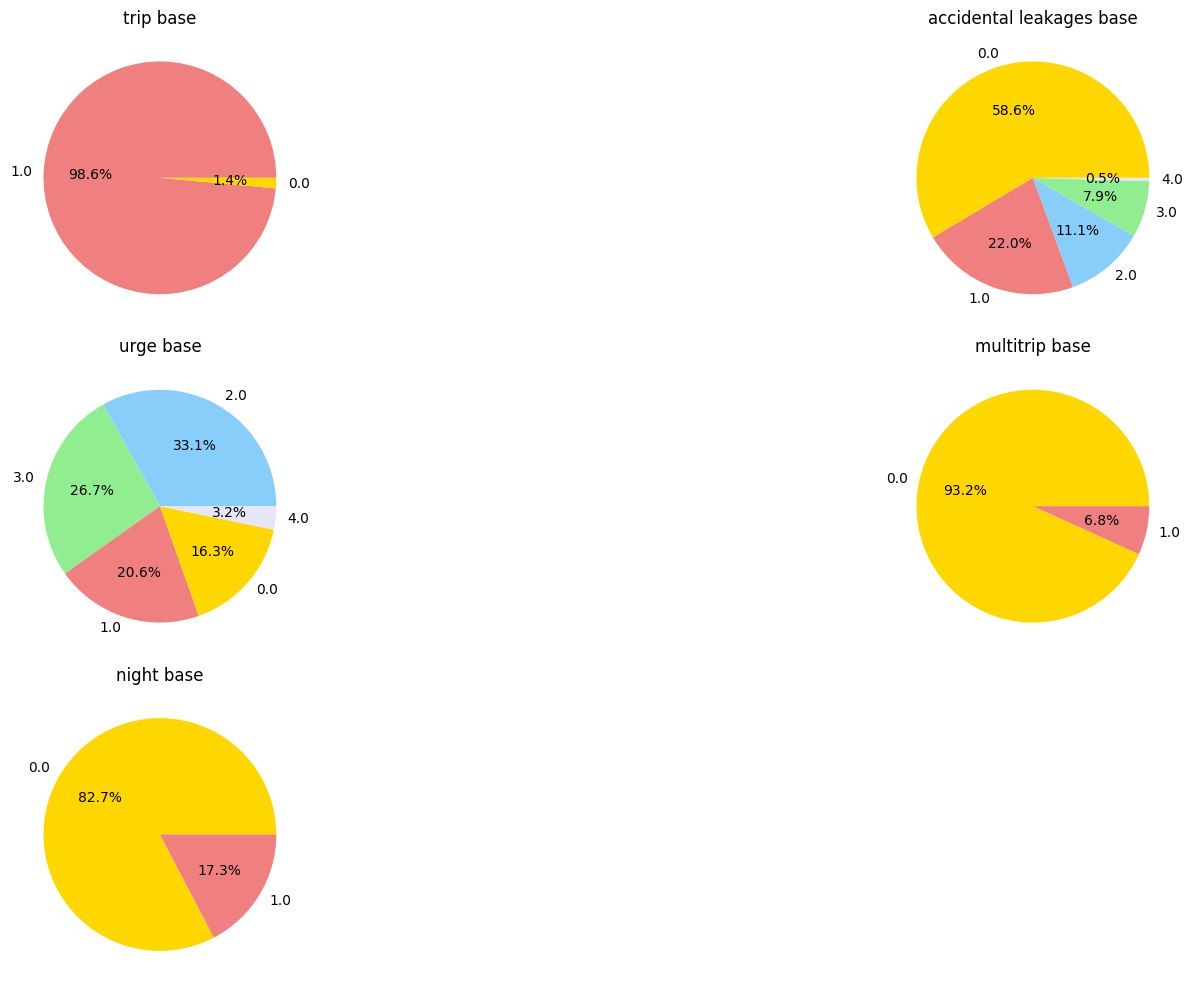

In [ ]:
color_map = {
    0.0: 'gold',
    1.0: 'lightcoral',
    2.0: 'lightskyblue',
    3.0: 'lightgreen',
    4.0: 'lavender'
}

plt.figure(figsize=(20, 10))

for index, column in enumerate(all_statistics_df_base):
    plt.subplot(len(all_labels_base) // 2 + len(all_labels_base) % 2, 2, index + 1)

    value_counts = all_statistics_df_base[column].value_counts(normalize=True)
    unique_values = all_statistics_df_base[column].unique()

    colors_for_this_pie = [color_map[value] for value in value_counts.index]

    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', colors=colors_for_this_pie)
    plt.title(column)

plt.tight_layout()
plt.show()


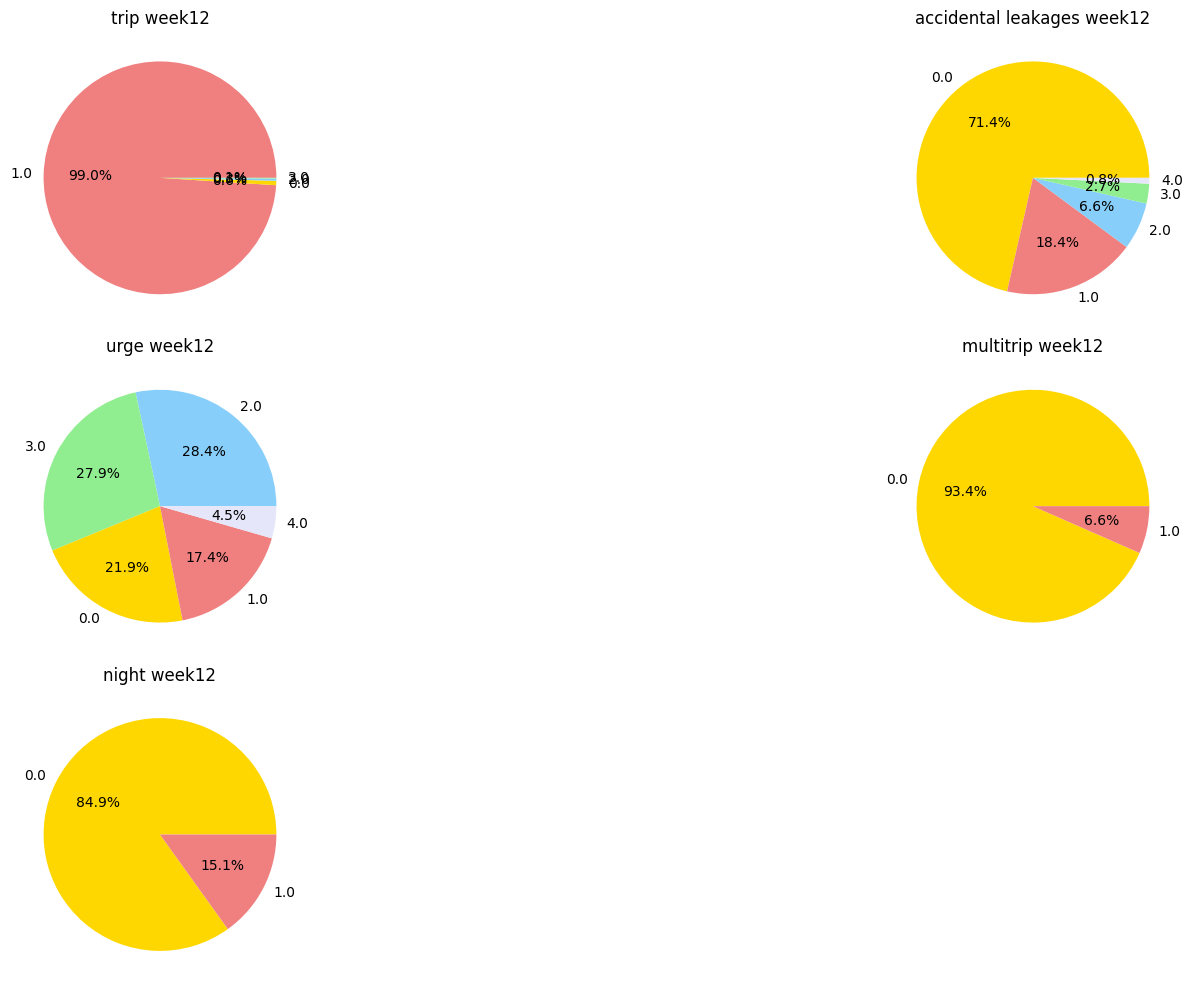

In [ ]:
plt.figure(figsize=(20, 10))

for index, column in enumerate(all_statistics_df_week12):
    plt.subplot(len(all_labels_week12) // 2 + len(all_labels_week12) % 2, 2, index + 1)

    value_counts = all_statistics_df_week12[column].value_counts(normalize=True)
    unique_values = all_statistics_df_week12[column].unique()

    colors_for_this_pie = [color_map[value] for value in value_counts.index]

    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', colors=colors_for_this_pie)
    plt.title(column)

plt.tight_layout()
plt.show()


In [ ]:
def count_num(data):
  data = data.astype(int)
  counts_to_4 = np.bincount(data, minlength=5)

  counts_to_4.tolist()
  return counts_to_4

all_second_columns_Base_num = count_num(all_second_columns_Base)
all_second_columns_week12_num = count_num(all_second_columns_week12)
all_third_columns_Base_num = count_num(all_third_columns_Base)
all_third_columns_week12_num = count_num(all_third_columns_week12)
all_fourth_columns_Base_num = count_num(all_fourth_columns_Base)
all_fourth_columns_week12_num = count_num(all_fourth_columns_week12)
all_fifth_columns_Base_num = count_num(all_fifth_columns_Base)
all_fifth_columns_week12_num = count_num(all_fifth_columns_week12)
all_sixth_columns_Base_num = count_num(all_sixth_columns_Base)
all_sixth_columns_week12_num = count_num(all_sixth_columns_week12)

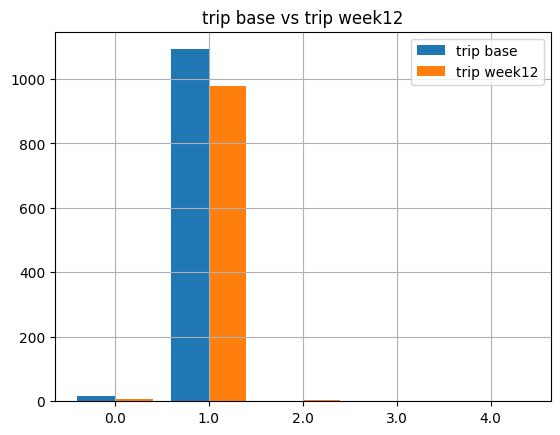

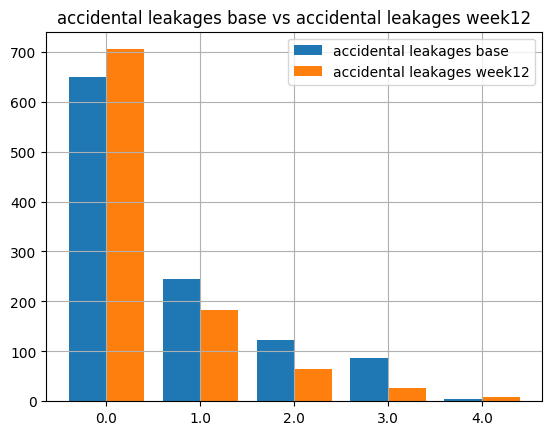

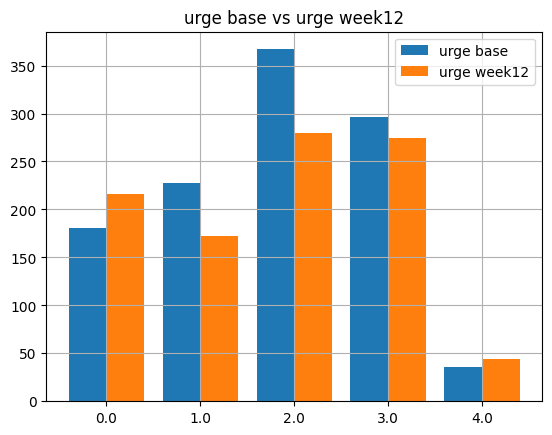

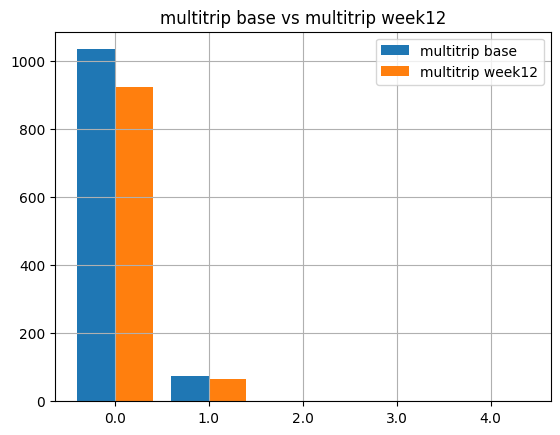

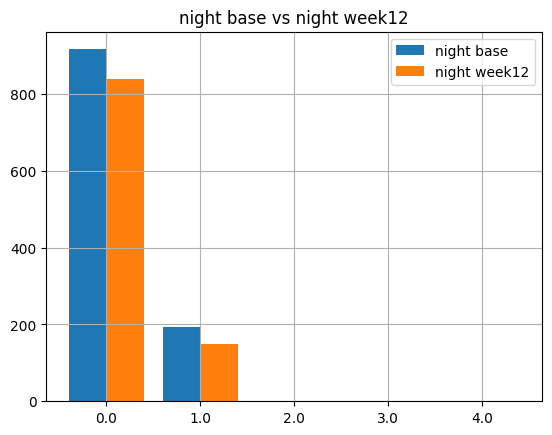

In [ ]:
def num_graph(y1, y2, i):
  x=np.arange(5)
  bar_width=0.4
  y = [0, 0, 0, 0, 0]
  x1 = x - bar_width/2
  x2 = x + bar_width/2
  plt.bar(x1,y1,width=bar_width)
  plt.bar(x2,y2,width=bar_width)
  plt.bar(x,y,tick_label=['0.0','1.0','2.0','3.0','4.0'],width=bar_width)
  plt.legend([all_labels[i], all_labels[i+1]])
  plt.title(f'{all_labels[i]} vs {all_labels[i+1]}')
  plt.grid()
  plt.show()
num_graph(all_second_columns_Base_num, all_second_columns_week12_num, 0)
num_graph(all_third_columns_Base_num, all_third_columns_week12_num, 2)
num_graph(all_fourth_columns_Base_num, all_fourth_columns_week12_num, 4)
num_graph(all_fifth_columns_Base_num, all_fifth_columns_week12_num, 6)
num_graph(all_sixth_columns_Base_num, all_sixth_columns_week12_num, 8)

The correlation matrix is calculated for two different data sets. In statistics and data analysis, the correlation matrix is a very important tool used to measure the linear relationship between different variables. The value of each cell represents the correlation coefficient between the corresponding row and column variables.

The correlation coefficient ranges in value between -1 and 1, where:

1 means a perfect positive correlation, that is, when one variable increases, the other variable also increases accordingly.
-1 means a perfect negative correlation, that is, when one variable increases, the other variable decreases accordingly.
0 means there is no linear relationship.
In data analysis, such a matrix can be used to quickly see which variables have a strong linear relationship with each other, which is very useful for feature selection, model building, and data understanding. For example, if two variables are highly correlated, you might choose to use only one of them to avoid multicollinearity problems. Conversely, if two variables have low correlation, they may provide different information to the model.

In [ ]:
labels = ['trip base', 'accidental leakages base', 'urge base', 'multitrip base','night base']
base_statistics_df = pd.DataFrame(list(zip(all_second_columns_Base, all_third_columns_Base, all_fourth_columns_Base, all_fifth_columns_Base, all_sixth_columns_Base)), columns=labels)
correlation_matrix = base_statistics_df.corr()
correlation_matrix_df = pd.DataFrame(correlation_matrix)
correlation_matrix_df

trip base  accidental leakages base  urge base  \
trip base                  1.000000                 -0.014419  -0.056293   
accidental leakages base  -0.014419                  1.000000   0.232734   
urge base                 -0.056293                  0.232734   1.000000   
multitrip base             0.032616                  0.039665   0.061986   
night base                 0.035430                  0.088629   0.033448   

                          multitrip base  night base  
trip base                       0.032616    0.035430  
accidental leakages base        0.039665    0.088629  
urge base                       0.061986    0.033448  
multitrip base                  1.000000   -0.056918  
night base                     -0.056918    1.000000

In [ ]:
labels = ['trip week12', 'accidental leakages week12','urge week12', 'multitrip week12','night week12']
week12_statistics_df = pd.DataFrame(list(zip(all_second_columns_week12, all_third_columns_week12, all_fourth_columns_week12, all_fifth_columns_week12, all_sixth_columns_week12)), columns=labels)
correlation_matrix = week12_statistics_df.corr()
correlation_matrix_df = pd.DataFrame(correlation_matrix)
correlation_matrix_df

trip week12  accidental leakages week12  \
trip week12                    1.000000                    0.015809   
accidental leakages week12     0.015809                    1.000000   
urge week12                   -0.001792                    0.213775   
multitrip week12               0.180316                   -0.010169   
night week12                   0.077702                    0.073823   

                            urge week12  multitrip week12  night week12  
trip week12                   -0.001792          0.180316      0.077702  
accidental leakages week12     0.213775         -0.010169      0.073823  
urge week12                    1.000000          0.067480      0.095004  
multitrip week12               0.067480          1.000000     -0.032091  
night week12                   0.095004         -0.032091      1.000000

In [ ]:
trips_baseline_data_A = dataset_A.get('BASELINE_Trips', 'Unknown')
urges_baseline_data_A = dataset_A.get('BASELINE_Urges', 'Unknown')
accLeaks_baseline_data_A = dataset_A.get('BASELINE_AccLeaks', 'Unknown')
nocturia_baseline_data_A = dataset_A.get('BASELINE_Nocturia', 'Unknown')

trips_week12_data_A = dataset_A.get('WEEK12_Trips', 'Unknown')
urges_week12_data_A = dataset_A.get('WEEK12_Urges', 'Unknown')
accLeaks_week12_data_A = dataset_A.get('WEEK12_AccLeaks', 'Unknown')
nocturia_week12_data_A = dataset_A.get('WEEK12_Nocturia', 'Unknown')

trips_baseline_data_B = dataset_B.get('BASELINE_Trips', 'Unknown')
urges_baseline_data_B = dataset_B.get('BASELINE_Urges', 'Unknown')
accLeaks_baseline_data_B = dataset_B.get('BASELINE_AccLeaks', 'Unknown')
nocturia_baseline_data_B = dataset_B.get('BASELINE_Nocturia', 'Unknown')

trips_week12_data_B = dataset_B.get('WEEK12_Trips', 'Unknown')
urges_week12_data_B = dataset_B.get('WEEK12_Urges', 'Unknown')
accLeaks_week12_data_B = dataset_B.get('WEEK12_AccLeaks', 'Unknown')
nocturia_week12_data_B = dataset_B.get('WEEK12_Nocturia', 'Unknown')

In [ ]:
print("Array Type:", type(accLeaks_baseline_data_A))
print("Shape:", accLeaks_baseline_data_A.shape)
print("Data Type:", accLeaks_baseline_data_A.dtype)
print("Dimensions:", accLeaks_baseline_data_A.ndim)

for i, item in enumerate(accLeaks_baseline_data_A):
    print(f"Element {i} is a {type(item)}")
    if isinstance(item, np.ndarray):
        print(f"  Shape of element {i}: {item.shape}")
        print(f"  Data type of element {i}: {item.dtype}")
    else:
        print(f"  Content of element {i}: {item}")

Array Type: <class 'numpy.ndarray'>
Shape: (4, 3, 21)
Data Type: uint8
Dimensions: 3
Element 0 is a <class 'numpy.ndarray'>
  Shape of element 0: (3, 21)
  Data type of element 0: uint8
Element 1 is a <class 'numpy.ndarray'>
  Shape of element 1: (3, 21)
  Data type of element 1: uint8
Element 2 is a <class 'numpy.ndarray'>
  Shape of element 2: (3, 21)
  Data type of element 2: uint8
Element 3 is a <class 'numpy.ndarray'>
  Shape of element 3: (3, 21)
  Data type of element 3: uint8


In [ ]:
trips_baseline_data = np.concatenate((trips_baseline_data_A, trips_baseline_data_B), axis=0)
urges_baseline_data = np.concatenate((urges_baseline_data_A, urges_baseline_data_B), axis=2)
accLeaks_baseline_data = np.concatenate((accLeaks_baseline_data_A, accLeaks_baseline_data_B), axis=2)
nocturia_baseline_data = np.concatenate((nocturia_baseline_data_A, nocturia_baseline_data_B), axis=0)

trips_week12_data = np.concatenate((trips_week12_data_A, trips_week12_data_B), axis=0)
urges_week12_data = np.concatenate((urges_week12_data_A, urges_week12_data_B), axis=2)
accLeaks_week12_data = np.concatenate((accLeaks_week12_data_A, accLeaks_week12_data_B), axis=2)
nocturia_week12_data = np.concatenate((nocturia_week12_data_A, nocturia_week12_data_B), axis=0)

In [ ]:
weights = np.array([1, 2, 3, 2])
accLeaks_scores_base = np.tensordot(accLeaks_baseline_data, weights, axes=(0, 0)).sum(axis=0)
accLeaks_scores_week12 = np.tensordot(accLeaks_week12_data, weights, axes=(0, 0)).sum(axis=0)
urges_scores_base = np.tensordot(urges_baseline_data, weights, axes=(0, 0)).sum(axis=0)
urges_scores_week12 = np.tensordot(urges_week12_data, weights, axes=(0, 0)).sum(axis=0)
trips_scores_base = np.sum(trips_baseline_data, axis=1)
trips_scores_week12 = np.sum(trips_week12_data, axis=1)
nocturia_scores_base = np.sum(nocturia_baseline_data, axis=1)
nocturia_scores_week12 = np.sum(nocturia_week12_data, axis=1)

In [ ]:
def compute_cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx - 1) * np.std(x, ddof=1) ** 2 + (ny - 1) * np.std(y, ddof=1) ** 2) / dof)
def compute_percentage_change(x):
  return np.max(x), np.min(x), np.average(x)
def z_score_normalization(arr):
    mean = np.mean(arr)
    std = np.std(arr)
    normalized_arr = (arr - mean) / std
    return normalized_arr

In [ ]:
average_accLeaks_scores_base = np.sum(accLeaks_scores_base)/len(accLeaks_scores_base)/3
average_accLeaks_scores_week12 = np.sum(accLeaks_scores_week12)/len(accLeaks_scores_week12)/3
pc_average_accLeaks = (average_accLeaks_scores_week12 - average_accLeaks_scores_base)/average_accLeaks_scores_base * 100

average_urges_scores_base = np.sum(urges_scores_base)/len(urges_scores_base)/3
average_urges_scores_week12 = np.sum(urges_scores_week12)/len(urges_scores_week12)/3
pc_average_urges = (average_urges_scores_week12 - average_urges_scores_base)/average_urges_scores_base * 100

average_trips_scores_base = np.sum(trips_scores_base)/len(trips_scores_base)/3
average_trips_scores_week12 = np.sum(trips_scores_week12)/len(trips_scores_week12)/3
pc_average_trips = (average_trips_scores_week12 - average_trips_scores_base)/average_trips_scores_base * 100

average_nocturia_scores_base = np.sum(nocturia_scores_base)/len(nocturia_scores_base)/3
average_nocturia_scores_week12 = np.sum(nocturia_scores_week12)/len(nocturia_scores_week12)/3
pc_average_nocturia = (average_nocturia_scores_week12 - average_nocturia_scores_base)/average_nocturia_scores_base * 100

print(f"accLeaks average scores: base: {average_accLeaks_scores_base:.2f}, week12: {average_accLeaks_scores_week12:.2f}, percentage change: {pc_average_accLeaks:.2f}%")
print(f"urges average scores: base: {average_urges_scores_base:.2f}, week12: {average_urges_scores_week12:.2f}, percentage change: {pc_average_urges:.2f}%")
print(f"trips average scores: base: {average_trips_scores_base:.2f}, week12: {average_trips_scores_week12:.2f}, percentage change: {pc_average_trips:.2f}%")
print(f"nocturia average scores: base: {average_nocturia_scores_base:.2f}, week12: {average_nocturia_scores_week12:.2f}, percentage change: {pc_average_nocturia:.2f}%")

accLeaks average scores: base: 7.25, week12: 3.90, percentage change: -46.25%
urges average scores: base: 18.30, week12: 15.67, percentage change: -14.41%
trips average scores: base: 10.40, week12: 9.39, percentage change: -9.71%
nocturia average scores: base: 1.83, week12: 1.42, percentage change: -22.40%


In [ ]:
accLeaks_differences = accLeaks_scores_week12 - accLeaks_scores_base
accLeaks_sum_of_differences = np.sum(accLeaks_differences)
accLeaks_percentage_change = (accLeaks_differences / np.where(accLeaks_scores_base != 0, accLeaks_scores_base, 1) * 100)
accLeaks_percentage_change_max, accLeaks_percentage_change_min, accLeaks_percentage_change_average = compute_percentage_change(accLeaks_percentage_change)
accLeaks_t_statistic, accLeaks_p_value = stats.ttest_rel(accLeaks_scores_base, accLeaks_scores_week12)
accLeaks_compute_cohens_d = compute_cohens_d(accLeaks_scores_base, accLeaks_scores_week12)
#The t-statistic: whether the difference between sample groups is unlikely to occur by chance; A high t-value usually indicates a significant difference between groups.
#the p-value: if the p-value is less than the significance level (usually 0.05), we consider the result to be statistically significant
#Cohen's d: how unusual the difference is in practice What an impact, 0.2 to 0.3 can be considered a small effect, 0.5 a medium effect, and above 0.8 a large effect.


print(f"accLeaks percentage change: {accLeaks_percentage_change}")
print(f"accLeaks sum of differences: {accLeaks_sum_of_differences}")
print(f"accLeaks percentage change max & min & average: {accLeaks_percentage_change_max}, {accLeaks_percentage_change_min}, {accLeaks_percentage_change_average}")
print(f"accLeaks t-statistic & p_value: {accLeaks_t_statistic}, {accLeaks_p_value}")
print(f"accLeaks cohens_d: {accLeaks_compute_cohens_d}")

accLeaks percentage change: [ -85.71428571  -55.26315789  -14.28571429  -82.          175.
  -80.           -3.125       -37.5         -82.60869565   16.66666667
  100.          -26.5625     -100.          -31.03448276  -91.66666667
  -64.28571429  -40.          -17.64705882  -21.73913043  200.
  -13.95348837  -44.44444444  -20.83333333    0.           50.
  -92.30769231    0.          -74.19354839    0.          -50.
   35.71428571    0.          -66.66666667    0.          -90.        ]
accLeaks sum of differences: -352
accLeaks percentage change max & min & average: 200.0, -100.0, -20.241446504188527
accLeaks t-statistic & p_value: 4.3828526002736, 0.00010672785320978853
accLeaks cohens_d: 0.5993908929324363


In [ ]:
urges_differences = urges_scores_week12 - urges_scores_base
urges_sum_of_differences = np.sum(urges_differences)
urges_percentage_change = (urges_differences / np.where(urges_scores_base != 0, urges_scores_base, 1) * 100)
urges_percentage_change_max, urges_percentage_change_min, urges_percentage_change_average = compute_percentage_change(urges_percentage_change)
urges_t_statistic, urges_p_value = stats.ttest_rel(urges_scores_base, urges_scores_week12)
urges_compute_cohens_d = compute_cohens_d(urges_scores_base, urges_scores_week12)


print(f"urges percentage change: {urges_percentage_change}")
print(f"urges sum of differences: {urges_sum_of_differences}")
print(f"urges percentage change max & min & average: {urges_percentage_change_max}, {urges_percentage_change_min}, {urges_percentage_change_average}")
print(f"urges t-statistic & p_value: {urges_t_statistic}, {urges_p_value}")
print(f"urges cohens_d: {urges_compute_cohens_d}")

urges percentage change: [ -75.40983607  -45.76271186  -22.85714286  -51.85185185   35.8490566
   49.05660377   10.52631579  -46.51162791  -70.37037037   24.
  -54.38596491   30.76923077   19.40298507    8.33333333  -75.
   -7.69230769  -14.66666667   -8.64197531   -3.22580645   -1.42857143
   -8.88888889  -22.72727273  -30.           23.         -100.
  -29.41176471  -61.71875     -93.61702128   -4.          -11.40350877
   47.05882353   -6.25         -7.84313725   12.85714286    9.375     ]
urges sum of differences: -277
urges percentage change max & min & average: 49.056603773584904, -100.0, -16.66961957917993
urges t-statistic & p_value: 2.086282792078343, 0.044526007491538185
urges cohens_d: 0.2686904083524366


In [ ]:
trips_scores_base = trips_scores_base.astype(float)
trips_scores_week12 = trips_scores_week12.astype(float)
trips_differences = trips_scores_week12 - trips_scores_base
trips_sum_of_differences = np.sum(trips_differences)
trips_percentage_change = (trips_differences / np.where(trips_scores_base != 0, trips_scores_base, 1) * 100)
trips_percentage_change_max, trips_percentage_change_min, trips_percentage_change_average = compute_percentage_change(trips_percentage_change)
trips_t_statistic, trips_p_value = stats.ttest_rel(trips_scores_base, trips_scores_week12)
trips_compute_cohens_d = compute_cohens_d(trips_scores_base, trips_scores_week12)


print(f"trips percentage change: {trips_percentage_change}")
print(f"trips sum of differences: {trips_sum_of_differences}")
print(f"trips percentage change max & min & average: {trips_percentage_change_max}, {trips_percentage_change_min}, {trips_percentage_change_average}")
print(f"trips t-statistic & p_value: {trips_t_statistic}, {trips_p_value}")
print(f"trips cohens_d: {trips_compute_cohens_d}")

trips percentage change: [-13.15789474  -7.40740741   3.57142857 -12.90322581   3.44827586
  16.          -4.54545455   3.57142857 -19.23076923  13.04347826
 -17.5         -2.           0.           6.66666667 -12.5
 -14.28571429 -18.75       -19.51219512 -16.66666667  -5.26315789
 -11.53846154 -16.21621622 -17.39130435  17.14285714  -2.04081633
 -40.         -42.30769231 -30.76923077  23.33333333   0.
 -23.33333333 -20.         -17.39130435 -13.88888889 -10.52631579]
trips sum of differences: -106.0
trips percentage change max & min & average: 23.333333333333332, -42.30769230769231, -9.209959461509161
trips t-statistic & p_value: 3.424073868380428, 0.001626271584464205
trips cohens_d: 0.29197016068617493


In [ ]:
nocturia_scores_base = nocturia_scores_base.astype(float)
nocturia_scores_week12 = nocturia_scores_week12.astype(float)
nocturia_differences = nocturia_scores_week12 - nocturia_scores_base
nocturia_sum_of_differences = np.sum(nocturia_differences)
nocturia_percentage_change = (nocturia_differences / np.where(nocturia_scores_base != 0, nocturia_scores_base, 1) * 100)
nocturia_percentage_change_max, nocturia_percentage_change_min, nocturia_percentage_change_average = compute_percentage_change(nocturia_percentage_change)
nocturia_t_statistic, nocturia_p_value = stats.ttest_rel(nocturia_scores_base, nocturia_scores_week12)
nocturia_compute_cohens_d = compute_cohens_d(nocturia_scores_base, nocturia_scores_week12)


print(f"nocturia percentage change: {nocturia_percentage_change}")
print(f"nocturia sum of differences: {nocturia_sum_of_differences}")
print(f"nocturia percentage change max & min & average: {nocturia_percentage_change_max}, {nocturia_percentage_change_min}, {nocturia_percentage_change_average}")
print(f"nocturia t-statistic & p_value: {nocturia_t_statistic}, {nocturia_p_value}")
print(f"nocturia cohens_d: {nocturia_compute_cohens_d}")

#50% improvement, freqency/day, 4 symtoms, 4 tables summarize, 35 patients baseline week12 percentage change @only count 2 & 3

nocturia percentage change: [  16.66666667  -80.          -50.          -40.          -25.
  -10.          -33.33333333  -25.          -66.66666667  -16.66666667
  -66.66666667   87.5           0.          -40.          100.
  -71.42857143  -50.          -50.         -100.           33.33333333
  400.           33.33333333 -100.          100.          -14.28571429
    0.         -100.         -100.          -16.66666667   -7.69230769
  -40.          -36.36363636  -33.33333333   20.         -100.        ]
nocturia sum of differences: -43.0
nocturia percentage change max & min & average: 400.0, -100.0, -13.779149422006563
nocturia t-statistic & p_value: 2.6174669800125416, 0.013127710259387838
nocturia cohens_d: 0.3370605747179368


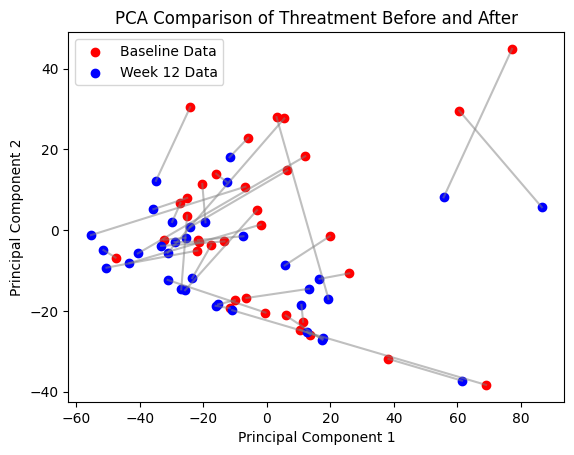

In [ ]:
base_data = np.column_stack([trips_scores_base, accLeaks_scores_base, urges_scores_base, nocturia_scores_base])
week12_data = np.column_stack([trips_scores_week12, accLeaks_scores_week12, urges_scores_week12, nocturia_scores_week12])

pca = PCA(n_components=2)
data1_pca = pca.fit_transform(base_data)
data2_pca = pca.transform(week12_data)

plt.scatter(data1_pca[:, 0], data1_pca[:, 1], color='r', label='Baseline Data')
plt.scatter(data2_pca[:, 0], data2_pca[:, 1], color='b', label='Week 12 Data')

for i in range(len(data1_pca)):
    plt.plot([data1_pca[i, 0], data2_pca[i, 0]], [data1_pca[i, 1], data2_pca[i, 1]], 'gray', alpha=0.5)

plt.legend()
plt.title('PCA Comparison of Threatment Before and After')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show()

In [ ]:
print("Principal component loadings (Loadings):")
print(pca.components_)
print("Proportion of variance explained by each principal component:")
print(pca.explained_variance_ratio_)

Principal component loadings (Loadings):
[[ 0.25775223  0.22729328  0.93901392  0.01242596]
 [ 0.00538228  0.9712147  -0.23688836  0.02443262]]
Proportion of variance explained by each principal component:
[0.62490154 0.31588197]


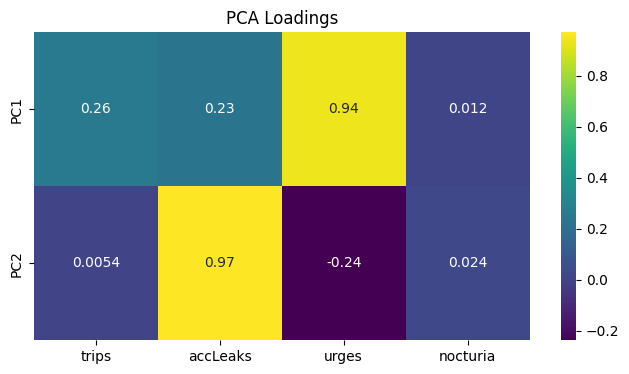

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.heatmap(pca.components_,
            cmap='viridis',
            annot=True,
            cbar=True,
            xticklabels=['trips', 'accLeaks', 'urges', 'nocturia'],
            yticklabels=['PC1', 'PC2'])
plt.title('PCA Loadings')
plt.show()

In [ ]:
base_average_trip_per_day = trips_scores_base/3
week12_average_trip_per_day = trips_scores_week12/3
trips_percentage_change_per_day = -(week12_average_trip_per_day - base_average_trip_per_day)/base_average_trip_per_day * 100

trips_df = pd.DataFrame({'Trip per day base data': base_average_trip_per_day, 'Trip per day week12 data': week12_average_trip_per_day, '% Change (improvement)': trips_percentage_change_per_day})
trips_df.round(2)

Trip per day base data  Trip per day week12 data  % Change (improvement)
0                    12.67                     11.00                   13.16
1                     9.00                      8.33                    7.41
2                     9.33                      9.67                   -3.57
3                    10.33                      9.00                   12.90
4                     9.67                     10.00                   -3.45
5                     8.33                      9.67                  -16.00
6                     7.33                      7.00                    4.55
7                     9.33                      9.67                   -3.57
8                     8.67                      7.00                   19.23
9                     7.67                      8.67                  -13.04
10                   13.33                     11.00                   17.50
11                   16.67                     16.33                    2.00
12                    9.00                      9.00                   -0.00
13                    5.00                      5.33                   -6.67
14                    8.00                      7.00                   12.50
15                    9.33                      8.00                   14.29
16                   10.67                      8.67                   18.75
17                   13.67                     11.00                   19.51
18                    4.00                      3.33                   16.67
19                   12.67                     12.00                    5.26
20                    8.67                      7.67                   11.54
21                   12.33                     10.33                   16.22
22                    7.67                      6.33                   17.39
23                   11.67                     13.67                  -17.14
24                   16.33                     16.00                    2.04
25                   10.00                      6.00                   40.00
26                   17.33                     10.00                   42.31
27                    8.67                      6.00                   30.77
28                   10.00                     12.33                  -23.33
29                   20.67                     20.67                   -0.00
30                   10.00                      7.67                   23.33
31                   10.00                      8.00                   20.00
32                    7.67                      6.33                   17.39
33                   12.00                     10.33                   13.89
34                    6.33                      5.67                   10.53

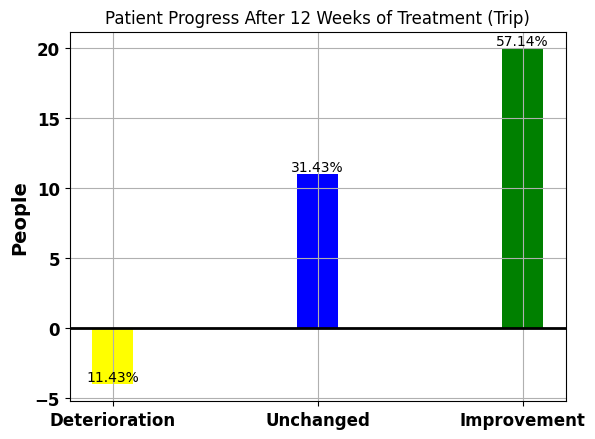

In [ ]:
def categorize_numbers(arr, threshold):
    less_than_zero = -1 * sum(1 for i in arr if i < -1 * threshold)
    zero_to_threshold = sum(1 for i in arr if -1 * threshold <= i <= threshold)
    greater_than_threshold = sum(1 for i in arr if i > threshold)

    return [less_than_zero, zero_to_threshold, greater_than_threshold]

def label_numbers(arr, threshold):
    labels = []
    for i in arr:
        if i < -1 * threshold:
            labels.append(-1)
        elif -1 * threshold <= i <= threshold:
            labels.append(0)
        else:
            labels.append(1)
    return labels


def num_graph_trip(y1, i):
  x=np.arange(3)
  bar_width=0.2
  y = [0, 0, 0]
  x1 = x
  colors = ['yellow'] + ['blue'] + ['green']
  bars = plt.bar(x1,y1,width=bar_width, color=colors)
  plt.bar(x,y,tick_label=['Deterioration','Unchanged','Improvement'],width=bar_width)
  for bar in bars:
    a = np.absolute(y1)
    yval = bar.get_height()
    yval_1 = bar.get_height()/np.sum(a)
    yval_1 = (yval_1 * 100).round(2)
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{np.absolute(yval_1)}%', va='bottom', ha='center')
  #plt.xlabel('Category', fontsize=14, fontweight='bold')
  plt.ylabel('People', fontsize=14, fontweight='bold')

  plt.xticks(fontsize=12, fontweight='bold')
  plt.yticks(fontsize=12, fontweight='bold')
  plt.axhline(y=0, color='black', linewidth=2)

  plt.title(f'Patient Progress After 12 Weeks of Treatment (Trip)')
  plt.grid()
  plt.show()

trip_arr = categorize_numbers(trips_percentage_change_per_day, 9)
num_graph_trip(trip_arr, 2)

In [ ]:
base_average_nocturia_per_day = nocturia_scores_base/3
week12_average_nocturia_per_day = nocturia_scores_week12/3
nocturia_percentage_change_per_day = -(week12_average_nocturia_per_day - base_average_nocturia_per_day)/np.where(base_average_nocturia_per_day != 0, base_average_nocturia_per_day, 1) * 100

nocturia_df = pd.DataFrame({'Nocturia per day base data': base_average_nocturia_per_day, 'Nocturia per day week12 data': week12_average_nocturia_per_day, '% Change (improvement)': nocturia_percentage_change_per_day})
nocturia_df.round(2)

Nocturia per day base data  Nocturia per day week12 data  \
0                         2.00                          2.33   
1                         1.67                          0.33   
2                         1.33                          0.67   
3                         1.67                          1.00   
4                         1.33                          1.00   
5                         3.33                          3.00   
6                         2.00                          1.33   
7                         1.33                          1.00   
8                         1.00                          0.33   
9                         2.00                          1.67   
10                        4.00                          1.33   
11                        2.67                          5.00   
12                        1.00                          1.00   
13                        1.67                          1.00   
14                        1.00                          2.00   
15                        2.33                          0.67   
16                        2.67                          1.33   
17                        2.00                          1.00   
18                        0.67                          0.00   
19                        2.00                          2.67   
20                        0.00                          1.33   
21                        2.00                          2.67   
22                        0.67                          0.00   
23                        0.00                          0.33   
24                        4.67                          4.00   
25                        0.00                          0.00   
26                        1.33                          0.00   
27                        0.67                          0.00   
28                        2.00                          1.67   
29                        4.33                          4.00   
30                        3.33                          2.00   
31                        3.67                          2.33   
32                        1.00                          0.67   
33                        1.67                          2.00   
34                        1.00                          0.00   

    % Change (improvement)  
0                   -16.67  
1                    80.00  
2                    50.00  
3                    40.00  
4                    25.00  
5                    10.00  
6                    33.33  
7                    25.00  
8                    66.67  
9                    16.67  
10                   66.67  
11                  -87.50  
12                   -0.00  
13                   40.00  
14                 -100.00  
15                   71.43  
16                   50.00  
17                   50.00  
18                  100.00  
19                  -33.33  
20                 -133.33  
21                  -33.33  
22                  100.00  
23                  -33.33  
24                   14.29  
25                   -0.00  
26                  100.00  
27                  100.00  
28                   16.67  
29                    7.69  
30                   40.00  
31                   36.36  
32                   33.33  
33                  -20.00  
34                  100.00

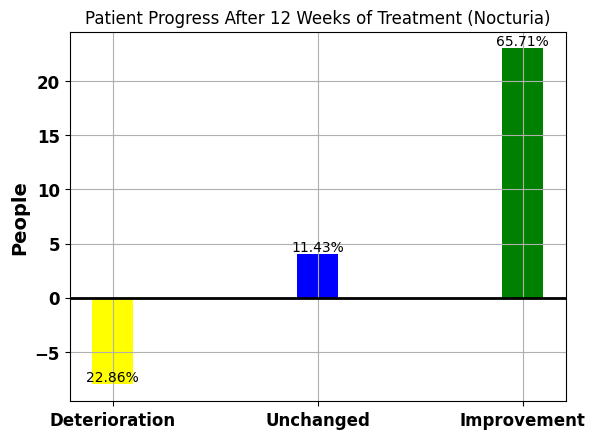

In [ ]:
def num_graph_night(y1, i):
  x=np.arange(3)
  bar_width=0.2
  y = [0, 0, 0]
  x1 = x
  colors = ['yellow'] + ['blue'] + ['green']
  bars = plt.bar(x1,y1,width=bar_width, color=colors)
  plt.bar(x,y,tick_label=['Deterioration','Unchanged','Improvement'],width=bar_width)
  for bar in bars:
    a = np.absolute(y1)
    yval = bar.get_height()
    yval_1 = bar.get_height()/np.sum(a)
    yval_1 = (yval_1 * 100).round(2)
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{np.absolute(yval_1)}%', va='bottom', ha='center')
  #plt.xlabel('Category', fontsize=14, fontweight='bold')
  plt.ylabel('People', fontsize=14, fontweight='bold')

  plt.xticks(fontsize=12, fontweight='bold')
  plt.yticks(fontsize=12, fontweight='bold')
  plt.axhline(y=0, color='black', linewidth=2)

  plt.title(f'Patient Progress After 12 Weeks of Treatment (Nocturia)')
  plt.grid()
  plt.show()

nocturia_arr = categorize_numbers(nocturia_percentage_change_per_day, 13)
num_graph_night(nocturia_arr, 5)

In [ ]:
#non-weighted total
#weighted total
#2 & 3 total
weights = np.array([1, 2, 3, 2])
non_weights = np.array([1, 1, 1, 1])
two_three_weights = np.array([0, 2, 3, 0])

weight_accLeaks_scores_base = np.tensordot(accLeaks_baseline_data, weights, axes=(0, 0)).sum(axis=0)
weight_accLeaks_scores_week12 = np.tensordot(accLeaks_week12_data, weights, axes=(0, 0)).sum(axis=0)
weight_urges_scores_base = np.tensordot(urges_baseline_data, weights, axes=(0, 0)).sum(axis=0)
weight_urges_scores_week12 = np.tensordot(urges_week12_data, weights, axes=(0, 0)).sum(axis=0)

non_weight_accLeaks_scores_base = np.tensordot(accLeaks_baseline_data, non_weights, axes=(0, 0)).sum(axis=0)
non_weight_accLeaks_scores_week12 = np.tensordot(accLeaks_week12_data, non_weights, axes=(0, 0)).sum(axis=0)
non_weight_urges_scores_base = np.tensordot(urges_baseline_data, non_weights, axes=(0, 0)).sum(axis=0)
non_weight_urges_scores_week12 = np.tensordot(urges_week12_data, non_weights, axes=(0, 0)).sum(axis=0)

two_three_weight_accLeaks_scores_base = np.tensordot(accLeaks_baseline_data, two_three_weights, axes=(0, 0)).sum(axis=0)
two_three_weight_accLeaks_scores_week12 = np.tensordot(accLeaks_week12_data, two_three_weights, axes=(0, 0)).sum(axis=0)
two_three_weight_urges_scores_base = np.tensordot(urges_baseline_data, two_three_weights, axes=(0, 0)).sum(axis=0)
two_three_weight_urges_scores_week12 = np.tensordot(urges_week12_data, two_three_weights, axes=(0, 0)).sum(axis=0)

In [ ]:
weighted_base_average_accLeaks_per_day = weight_accLeaks_scores_base/3
non_weighted_base_average_accLeaks_per_day = non_weight_accLeaks_scores_base/3
two_three_weighted_base_average_accLeaks_per_day = two_three_weight_accLeaks_scores_base/3

weighted_week12_average_accLeaks_per_day = weight_accLeaks_scores_week12/3
non_weighted_week12_average_accLeaks_per_day = non_weight_accLeaks_scores_week12/3
two_three_weighted_week12_average_accLeaks_per_day = two_three_weight_accLeaks_scores_week12/3


weighted_accLeaks_percentage_change_per_day = -(weighted_week12_average_accLeaks_per_day - weighted_base_average_accLeaks_per_day)/np.where(weighted_base_average_accLeaks_per_day != 0, weighted_base_average_accLeaks_per_day, 1) * 100
non_weighted_accLeaks_percentage_change_per_day = -(non_weighted_week12_average_accLeaks_per_day - non_weighted_base_average_accLeaks_per_day)/np.where(non_weighted_base_average_accLeaks_per_day != 0, non_weighted_base_average_accLeaks_per_day, 1) * 100
two_three_weighted_accLeaks_percentage_change_per_day = -(two_three_weighted_week12_average_accLeaks_per_day - two_three_weighted_base_average_accLeaks_per_day)/np.where(two_three_weighted_base_average_accLeaks_per_day != 0, two_three_weighted_base_average_accLeaks_per_day, 1) * 100

accLeaks_df = pd.DataFrame({'Weighted accLeaks baseline': weighted_base_average_accLeaks_per_day, 'Weighted accLeaks week12': weighted_week12_average_accLeaks_per_day, '% Change 1': weighted_accLeaks_percentage_change_per_day,
                            'Non weighted accLeaks baseline': non_weighted_base_average_accLeaks_per_day, 'Non weighted accLeaks week12': non_weighted_week12_average_accLeaks_per_day, '% Change 2': non_weighted_accLeaks_percentage_change_per_day,
                            '2 & 3 weighted accLeaks baseline': two_three_weighted_base_average_accLeaks_per_day, '2 & 3 weighted accLeaks week12': two_three_weighted_week12_average_accLeaks_per_day, '% Change 3': two_three_weighted_accLeaks_percentage_change_per_day})
accLeaks_df.round(2)

Weighted accLeaks baseline  Weighted accLeaks week12  % Change 1  \
0                        14.00                      2.00       85.71   
1                        12.67                      5.67       55.26   
2                         4.67                      4.00       14.29   
3                        16.67                      3.00       82.00   
4                         1.33                      3.67     -175.00   
5                        16.67                      3.33       80.00   
6                        10.67                     10.33        3.12   
7                         5.33                      3.33       37.50   
8                         7.67                      1.33       82.61   
9                         4.00                      4.67      -16.67   
10                        0.33                      0.67     -100.00   
11                       21.33                     15.67       26.56   
12                        1.00                      0.00      100.00   
13                        9.67                      6.67       31.03   
14                        4.00                      0.33       91.67   
15                        4.67                      1.67       64.29   
16                        8.33                      5.00       40.00   
17                        5.67                      4.67       17.65   
18                        7.67                      6.00       21.74   
19                        0.67                      2.00     -200.00   
20                       14.33                     12.33       13.95   
21                       15.00                      8.33       44.44   
22                        8.00                      6.33       20.83   
23                        0.00                      0.00       -0.00   
24                        0.67                      1.00      -50.00   
25                        8.67                      0.67       92.31   
26                        0.00                      0.00       -0.00   
27                       10.33                      2.67       74.19   
28                        0.00                      0.00       -0.00   
29                       27.33                     13.67       50.00   
30                        4.67                      6.33      -35.71   
31                        0.00                      0.00       -0.00   
32                        1.00                      0.33       66.67   
33                        0.00                      0.00       -0.00   
34                        6.67                      0.67       90.00   

    Non weighted accLeaks baseline  Non weighted accLeaks week12  % Change 2  \
0                             7.33                          1.67       77.27   
1                             8.33                          5.00       40.00   
2                             2.67                          3.67      -37.50   
3                             8.33                          2.67       68.00   
4                             0.67                          3.00     -350.00   
5                             8.33                          1.33       84.00   
6                             7.00                          5.33       23.81   
7                             4.33                          1.67       61.54   
8                             3.33                          1.00       70.00   
9                             2.00                          2.67      -33.33   
10                            0.33                          0.67     -100.00   
11                           12.00                         13.00       -8.33   
12                            1.00                          0.00      100.00   
13                            4.00                          2.33       41.67   
14                            3.00                          0.33       88.89   
15                            3.67                          1.00       72.73   
16                            3.33                 

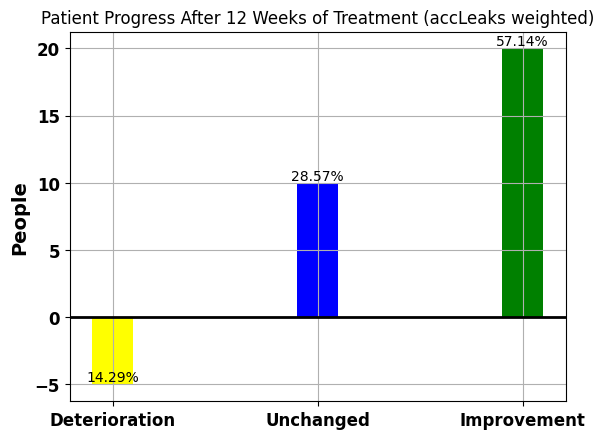

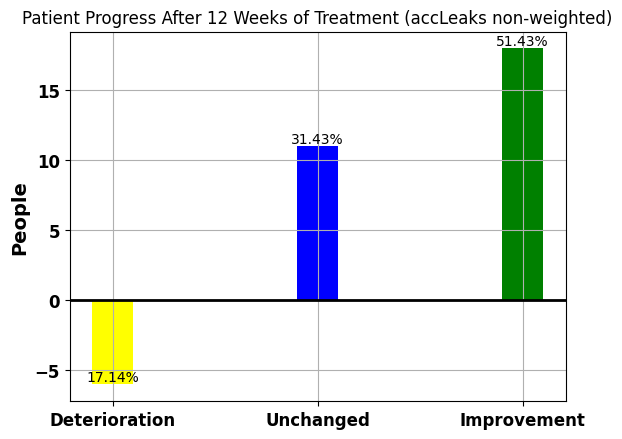

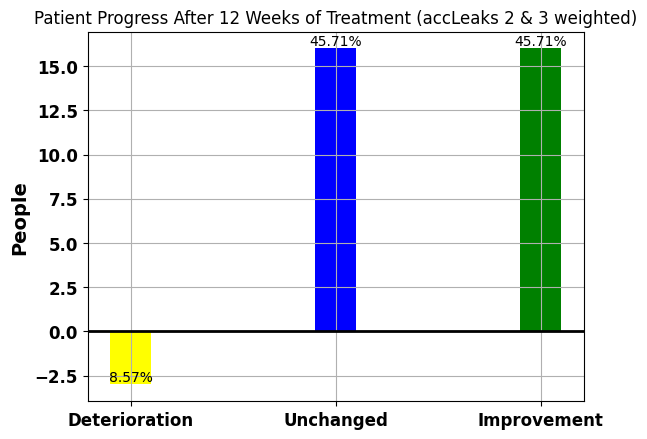

In [ ]:
def num_graph_accLeaks(y1, i):
  x=np.arange(3)
  bar_width=0.2
  y = [0, 0, 0]
  x1 = x
  colors = ['yellow'] + ['blue'] + ['green']
  bars = plt.bar(x1,y1,width=bar_width, color=colors)
  plt.bar(x,y,tick_label=['Deterioration','Unchanged','Improvement'],width=bar_width)
  for bar in bars:
    a = np.absolute(y1)
    yval = bar.get_height()
    yval_1 = bar.get_height()/np.sum(a)
    yval_1 = (yval_1 * 100).round(2)
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{np.absolute(yval_1)}%', va='bottom', ha='center')
  #plt.xlabel('Category', fontsize=14, fontweight='bold')
  plt.ylabel('People', fontsize=14, fontweight='bold')

  plt.xticks(fontsize=12, fontweight='bold')
  plt.yticks(fontsize=12, fontweight='bold')
  plt.axhline(y=0, color='black', linewidth=2)
  if i == 1:
    plt.title(f'Patient Progress After 12 Weeks of Treatment (accLeaks weighted)')
  elif i == 2:
    plt.title(f'Patient Progress After 12 Weeks of Treatment (accLeaks non-weighted)')
  else:
    plt.title(f'Patient Progress After 12 Weeks of Treatment (accLeaks 2 & 3 weighted)')
  plt.grid()
  plt.show()

nocturia_1 = categorize_numbers(weighted_accLeaks_percentage_change_per_day, np.average(weighted_accLeaks_percentage_change_per_day))
nocturia_2 = categorize_numbers(non_weighted_accLeaks_percentage_change_per_day, np.average(non_weighted_accLeaks_percentage_change_per_day))
nocturia_3 = categorize_numbers(two_three_weighted_accLeaks_percentage_change_per_day, np.average(two_three_weighted_accLeaks_percentage_change_per_day))
num_graph_accLeaks(nocturia_1, 1)
num_graph_accLeaks(nocturia_2, 2)
num_graph_accLeaks(nocturia_3, 3)

In [ ]:
weighted_base_average_urges_per_day = weight_urges_scores_base/3
non_weighted_base_average_urges_per_day = non_weight_urges_scores_base/3
two_three_weighted_base_average_urges_per_day = two_three_weight_urges_scores_base/3

weighted_week12_average_urges_per_day = weight_urges_scores_week12/3
non_weighted_week12_average_urges_per_day = non_weight_urges_scores_week12/3
two_three_weighted_week12_average_urges_per_day = two_three_weight_urges_scores_week12/3


weighted_urges_percentage_change_per_day = -(weighted_week12_average_urges_per_day - weighted_base_average_urges_per_day)/np.where(weighted_base_average_urges_per_day != 0, weighted_base_average_urges_per_day, 1) * 100
non_weighted_urges_percentage_change_per_day = -(non_weighted_week12_average_urges_per_day - non_weighted_base_average_urges_per_day)/np.where(non_weighted_base_average_urges_per_day != 0, non_weighted_base_average_urges_per_day, 1) * 100
two_three_weighted_urges_percentage_change_per_day = -(two_three_weighted_week12_average_urges_per_day - two_three_weighted_base_average_urges_per_day)/np.where(two_three_weighted_base_average_urges_per_day != 0, two_three_weighted_base_average_urges_per_day, 1) * 100

urges_df = pd.DataFrame({'Weighted urges baseline': weighted_base_average_urges_per_day, 'Weighted urges week12': weighted_week12_average_urges_per_day, '% Change 1': weighted_urges_percentage_change_per_day,
                            'Non weighted urges baseline': non_weighted_base_average_urges_per_day, 'Non weighted urges week12': non_weighted_week12_average_urges_per_day, '% Change 2': non_weighted_urges_percentage_change_per_day,
                            '2 & 3 weighted urges baseline': two_three_weighted_base_average_urges_per_day, '2 & 3 weighted urges week12': two_three_weighted_week12_average_urges_per_day, '% Change 3': two_three_weighted_urges_percentage_change_per_day})
urges_df.round(2)

Weighted urges baseline  Weighted urges week12  % Change 1  \
0                     20.33                   5.00       75.41   
1                     19.67                  10.67       45.76   
2                     11.67                   9.00       22.86   
3                     18.00                   8.67       51.85   
4                     17.67                  24.00      -35.85   
5                     17.67                  26.33      -49.06   
6                     12.67                  14.00      -10.53   
7                     14.33                   7.67       46.51   
8                     18.00                   5.33       70.37   
9                      8.33                  10.33      -24.00   
10                    19.00                   8.67       54.39   
11                    34.67                  45.33      -30.77   
12                    22.33                  26.67      -19.40   
13                    12.00                  13.00       -8.33   
14                    12.00                   3.00       75.00   
15                    13.00                  12.00        7.69   
16                    25.00                  21.33       14.67   
17                    27.00                  24.67        8.64   
18                    10.33                  10.00        3.23   
19                    23.33                  23.00        1.43   
20                    15.00                  13.67        8.89   
21                     7.33                   5.67       22.73   
22                    10.00                   7.00       30.00   
23                    33.33                  41.00      -23.00   
24                     1.33                   0.00      100.00   
25                    17.00                  12.00       29.41   
26                    42.67                  16.33       61.72   
27                    15.67                   1.00       93.62   
28                    25.00                  24.00        4.00   
29                    38.00                  33.67       11.40   
30                    11.33                  16.67      -47.06   
31                    16.00                  15.00        6.25   
32                    17.00                  15.67        7.84   
33                    23.33                  26.33      -12.86   
34                    10.67                  11.67       -9.38   

    Non weighted urges baseline  Non weighted urges week12  % Change 2  \
0                         11.33                       5.00       55.88   
1                          9.00                       8.33        7.41   
2                          5.00                       5.00       -0.00   
3                          8.67                       4.33       50.00   
4                          8.67                      10.33      -19.23   
5                          8.00                       9.33      -16.67   
6                          7.00                       7.00       -0.00   
7                          8.67                       5.67       34.62   
8                          8.67                       2.67       69.23   
9                          4.67                       5.67      -21.43   
10                         9.33                       5.00       46.43   
11                        16.67                      16.67       -0.00   
12                         8.33                       9.00       -8.00   
13                         5.00                       5.33       -6.67   
14                         4.00                       1.67       58.33   
15                         9.00                       7.33       18.52   
16                        10.67                       8.67       18.75   
17                        11.33                       9.33       17.65   
18                         3.67                       3.33        9.09   
19                        12.00                      11.67        2.78   
20                         7.67                       7.00        8.70   

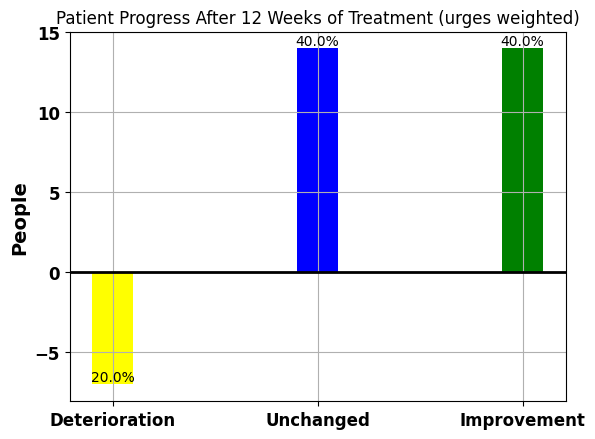

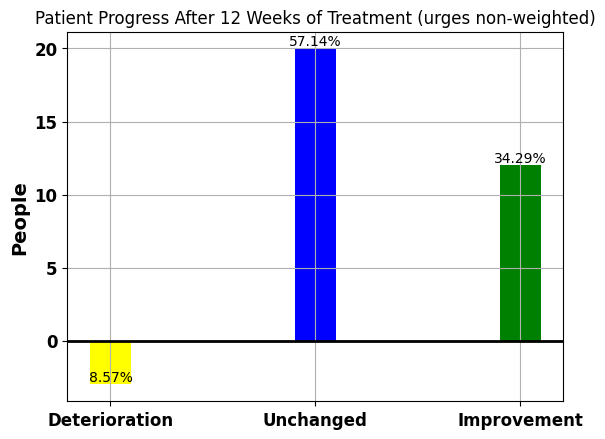

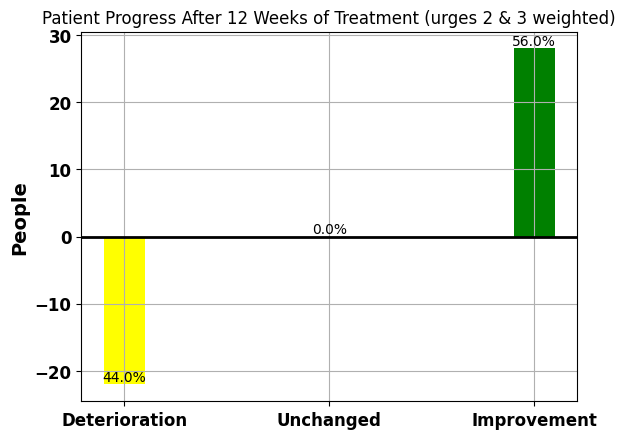

(16.66961957917993, 17.738652294697037, -25.078606802518067)

In [ ]:
def num_graph_urges(y1, i):
  x=np.arange(3)
  bar_width=0.2
  y = [0, 0, 0]
  x1 = x
  colors = ['yellow'] + ['blue'] + ['green']
  bars = plt.bar(x1,y1,width=bar_width, color=colors)
  plt.bar(x,y,tick_label=['Deterioration','Unchanged','Improvement'],width=bar_width)
  for bar in bars:
    a = np.absolute(y1)
    yval = bar.get_height()
    yval_1 = bar.get_height()/np.sum(a)
    yval_1 = (yval_1 * 100).round(2)
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{np.absolute(yval_1)}%', va='bottom', ha='center')
  #plt.xlabel('Category', fontsize=14, fontweight='bold')
  plt.ylabel('People', fontsize=14, fontweight='bold')

  plt.xticks(fontsize=12, fontweight='bold')
  plt.yticks(fontsize=12, fontweight='bold')
  plt.axhline(y=0, color='black', linewidth=2)
  if i == 1:
    plt.title(f'Patient Progress After 12 Weeks of Treatment (urges weighted)')
  elif i == 2:
    plt.title(f'Patient Progress After 12 Weeks of Treatment (urges non-weighted)')
  else:
    plt.title(f'Patient Progress After 12 Weeks of Treatment (urges 2 & 3 weighted)')
  plt.grid()
  plt.show()

urges_1 = categorize_numbers(weighted_urges_percentage_change_per_day, np.average(weighted_urges_percentage_change_per_day))
urges_2 = categorize_numbers(non_weighted_urges_percentage_change_per_day, np.average(non_weighted_urges_percentage_change_per_day))
urges_3 = categorize_numbers(two_three_weighted_urges_percentage_change_per_day, np.average(two_three_weighted_urges_percentage_change_per_day))
num_graph_urges(urges_1, 1)
num_graph_urges(urges_2, 2)
num_graph_urges(urges_3, 3)
np.average(weighted_urges_percentage_change_per_day), np.average(non_weighted_urges_percentage_change_per_day), np.average(two_three_weighted_urges_percentage_change_per_day)

In [ ]:
day1 = [0.3125, 0.395833333333333, 0.479166666666667, 0.541666666666667,
    0.625, 0.694444444444445, 0.722222222222222, 0.861111111111111,
    0.888888888888889, 0.9375, 1.0625]
day2 = [1.354166666666667, 1.395833333333333, 1.444444444444444, 1.472222222222222,
    1.5625, 1.604166666666667, 1.645833333333333, 1.819444444444445,
    1.847222222222222, 1.895833333333333, 2.0208333333333333, 2.145833333333333,
    2.291666666666667]
day3 = [2.354166666666667, 2.395833333333333, 2.4375, 2.5, 2.541666666666667,
    2.625, 2.708333333333333, 2.777777777777778, 2.805555555555556,
    2.875, 2.9375, 3.0208333333333333, 3.149305555555556, 3.229166666666667]

normalized_time_patient_1 = np.array(day1 + day2 + day3) - 0.3
trips_patient_1 = np.ones(38)
accLeaks_patient_1 = [3, 3, 0, 0, 1, 0, 0, 2, 2, 3, 3, 3, 0, 0, 0, 0, 0, 1, 2, 2, 1, 2, 1, 1, 2, 3, 0, 0, 2, 1, 0, 0, 0, 0, 0, 1, 2, 1]
urges_patient_1 = [3, 3, 1, 1, 2, 2, 1, 3, 3, 3, 3, 3, 0, 0, 0, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 0, 2, 2, 2]
night_patient_1 = [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1]
night_patient_1_post = [0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0]

def draw_graph(x, y1, label):
  plt.figure(figsize=(24, 3))
  bar_width=0.01
  bar_centers = x - bar_width / 2
  #print("Bar centers:", bar_centers)
  plt.bar(bar_centers, y1, width=bar_width)
  plt.title(label)
  #plt.plot(bar_centers, [0] * len(bar_centers), 'r.')
  plt.grid()
  plt.show()

In [ ]:
normalized_time_patient_1_post = [0.368055555555556, 0.381944444444444, 0.447916666666667, 0.500000000000000,
    0.541666666666667, 0.583333333333333, 0.666666666666667, 0.750000000000000,
    0.819444444444445, 0.847222222222222, 0.895833333333333, 1.0208333333333333,
    1.166666666666667, 1.229166666666667,
    1.375000000000000, 1.500000000000000, 1.541666666666667, 1.611111111111111,
    1.638888888888889, 1.708333333333333, 1.875000000000000, 2.0208333333333333,
    2.187500000000000,
    2.375000000000000, 2.458333333333333, 2.541666666666667, 2.645833333333333,
    2.736111111111111, 2.763888888888889, 2.916666666666667, 3.0625000000000000,
    3.187500000000000, 3.291666666666667]


normalized_time_patient_1_post = np.array(normalized_time_patient_1_post) - 0.3

trips_patient_1_post = np.ones(33)
accLeaks_patient_1_post = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
urges_patient_1_post = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]

# draw_graph(normalized_time_patient_1, trips_patient_1, 'Patient 1 trips baseline')
# draw_graph(normalized_time_patient_1_post, trips_patient_1_post, 'Patient 1 trips week 12')
# draw_graph(normalized_time_patient_1, accLeaks_patient_1, 'Patient 1 accLeaks baseline')
# draw_graph(normalized_time_patient_1_post, accLeaks_patient_1_post, 'Patient 1 accLeaks week 12')
# draw_graph(normalized_time_patient_1, urges_patient_1, 'Patient 1 urges baseline')
# draw_graph(normalized_time_patient_1_post, urges_patient_1_post, 'Patient 1 urges week 12')
# draw_graph(normalized_time_patient_1, night_patient_1, 'Patient 1 nocturia baseline')
# draw_graph(normalized_time_patient_1_post, night_patient_1_post, 'Patient 1 nocturia week 12')

In [ ]:
def stack_participant_data(x):
  result_array = []
  for i in range(len(x[0])):
    combined_array = np.vstack((x[0][i][0],x[0][i][1],x[0][i][2]))
    transposed_array = combined_array.T

    new_array = np.copy(transposed_array[0])
    counter = 0
    for i in range(1, len(transposed_array[0])):
        if transposed_array[0][i] < transposed_array[0][i - 1] and counter < 3:
            new_array[i:] += 1
            counter += 1
    transposed_array[0] = new_array
    transposed_array = transposed_array[[0, 2, 3, 5]]
    result_array.append(transposed_array)

  return result_array

stacked_participant_baseline = stack_participant_data(participant_baseline_data_A) + stack_participant_data(participant_baseline_data_B)
stacked_participant_week12 = stack_participant_data(participant_12_weeks_data_A) + stack_participant_data(participant_12_weeks_data_B)

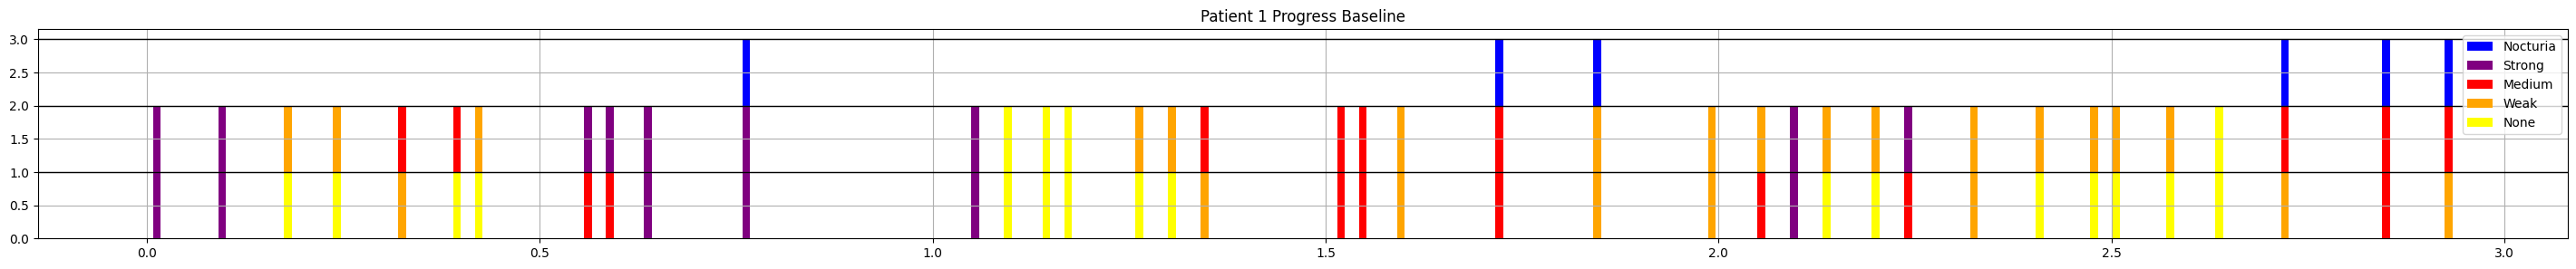

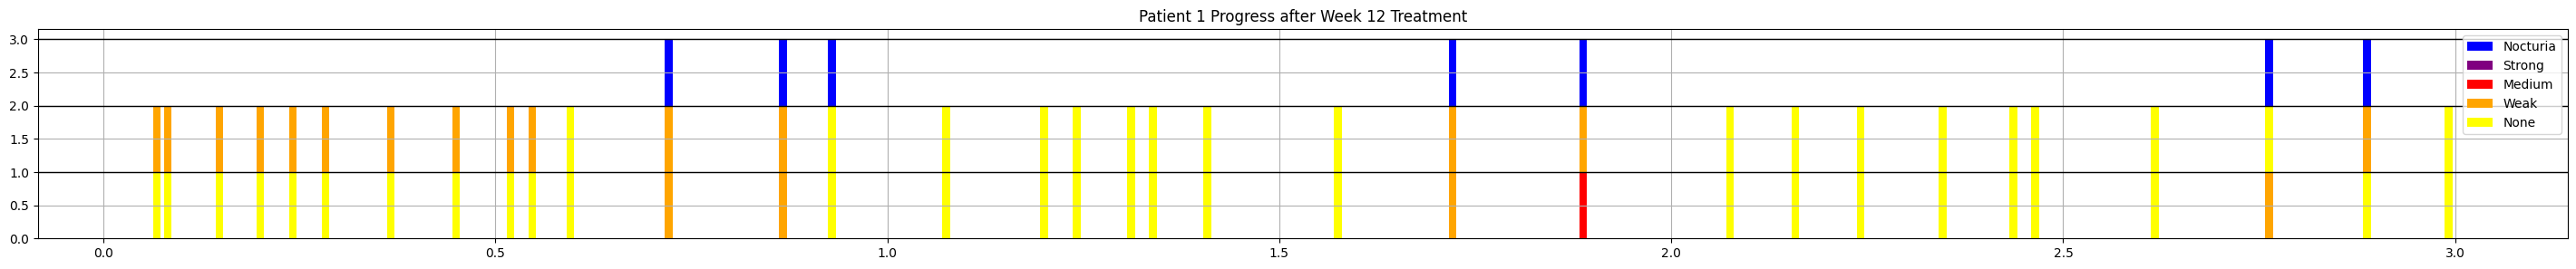

In [ ]:
import matplotlib.patches as mpatches

stacked_array = np.vstack((accLeaks_patient_1, urges_patient_1, night_patient_1))
stacked_array_2 = np.vstack((accLeaks_patient_1_post, urges_patient_1_post, night_patient_1_post))

def draw_graph_stack(x, data, y, z):
  plt.figure(figsize=(36, 3))
  color_map_1 = {0: 'yellow', 1: 'orange', 2: 'red', 3: 'purple', 4:'red'}
  color_map_2 = {0: 'white', 1: 'blue'}

  bottom_height = np.zeros(len(x))
  bar_width=0.01

  for i, series in enumerate(data):
    series[~np.isin(series, [0, 1, 2, 3, 4])] = 0
    colors = [color_map_1[value] for value in series]
    if i > 1:
      colors = [color_map_2[value] for value in series]
    bars = plt.bar(x, 1, bottom=bottom_height, color=colors, width = bar_width)
    bottom_height += 1
    i+=1

  plt.axhline(y=1, color='black', linewidth=1)
  plt.axhline(y=2, color='black', linewidth=1)
  plt.axhline(y=3, color='black', linewidth=1)

  plt.bar(2.5, 0, color='blue', label='Nocturia')
  plt.bar(2.5, 0, color='purple', label='Strong')
  plt.bar(2.5, 0, color='red', label='Medium')
  plt.bar(2.5, 0, color='orange', label='Weak')
  plt.bar(2.5, 0, color='yellow', label='None')

  plt.legend(loc='upper right')
  plt.grid()
  if y == 0:
    plt.title(f'Patient {z} Progress Baseline')
    plt.savefig(f"Patient {z} Progress Baseline.png")
  else:
    plt.title(f'Patient {z} Progress after Week 12 Treatment')
    plt.savefig(f"Patient {z} Progress after Week 12 Treatment.png")

  plt.show()

draw_graph_stack(normalized_time_patient_1, stacked_array, 0, 1)
draw_graph_stack(normalized_time_patient_1_post, stacked_array_2, 1, 1)

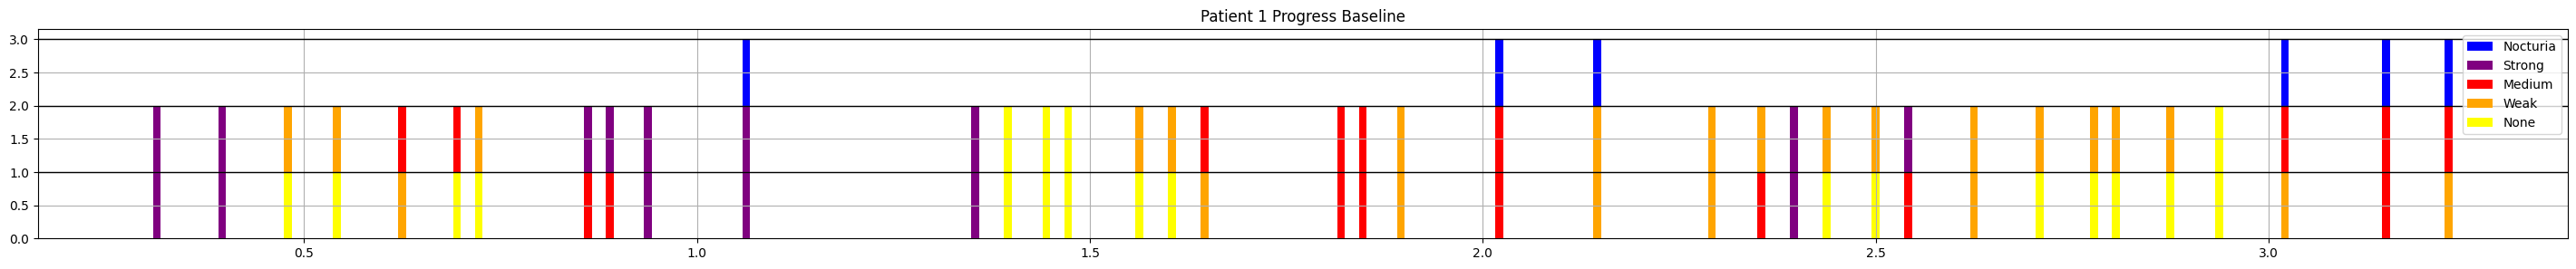

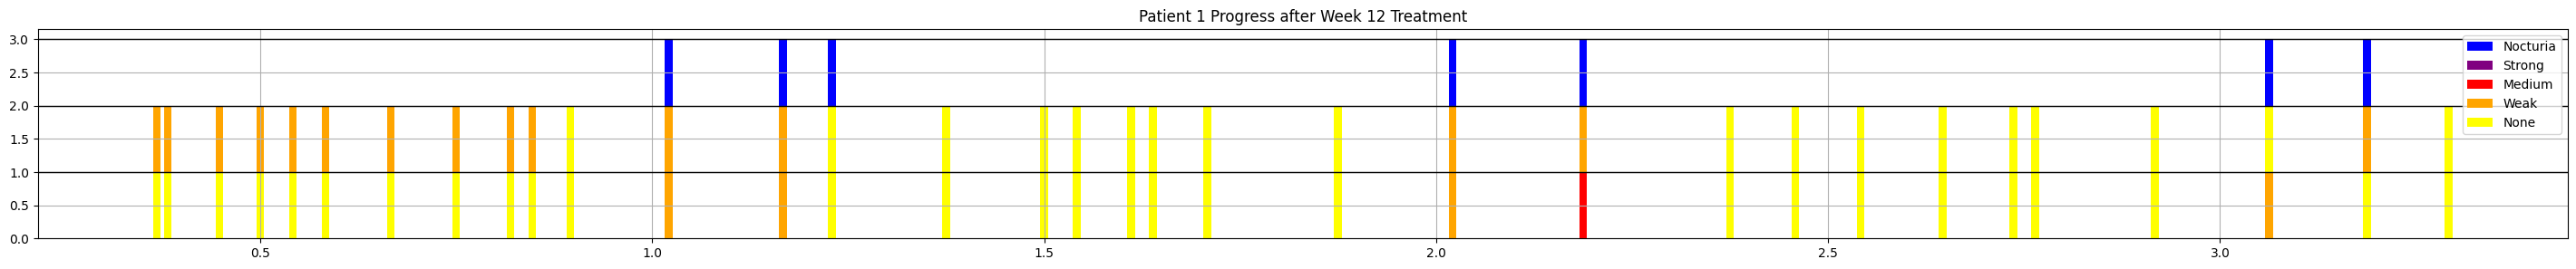

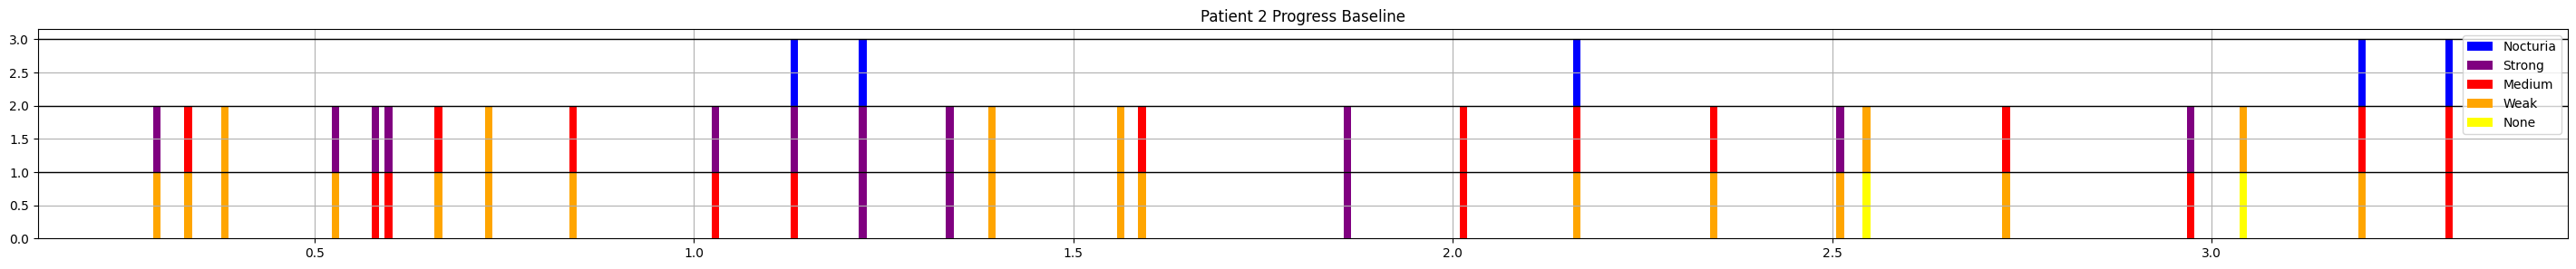

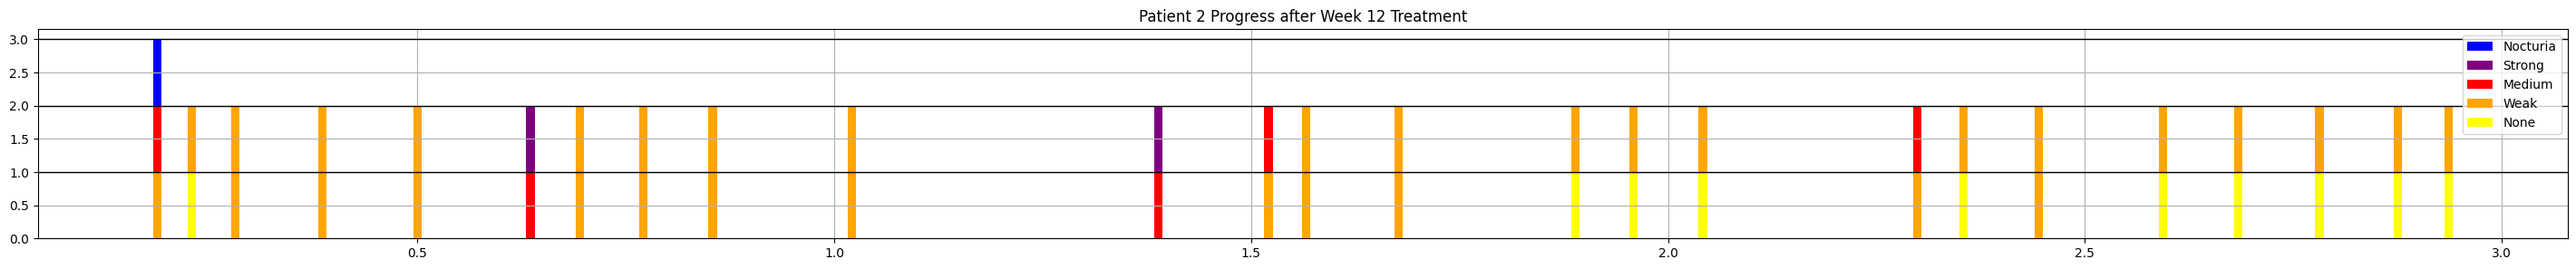

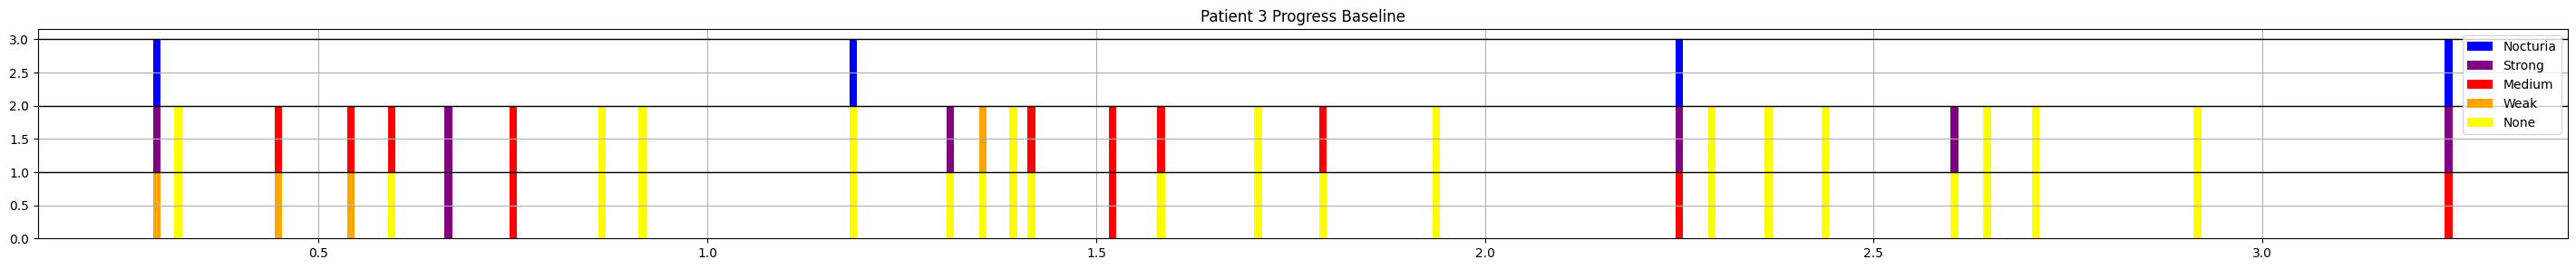

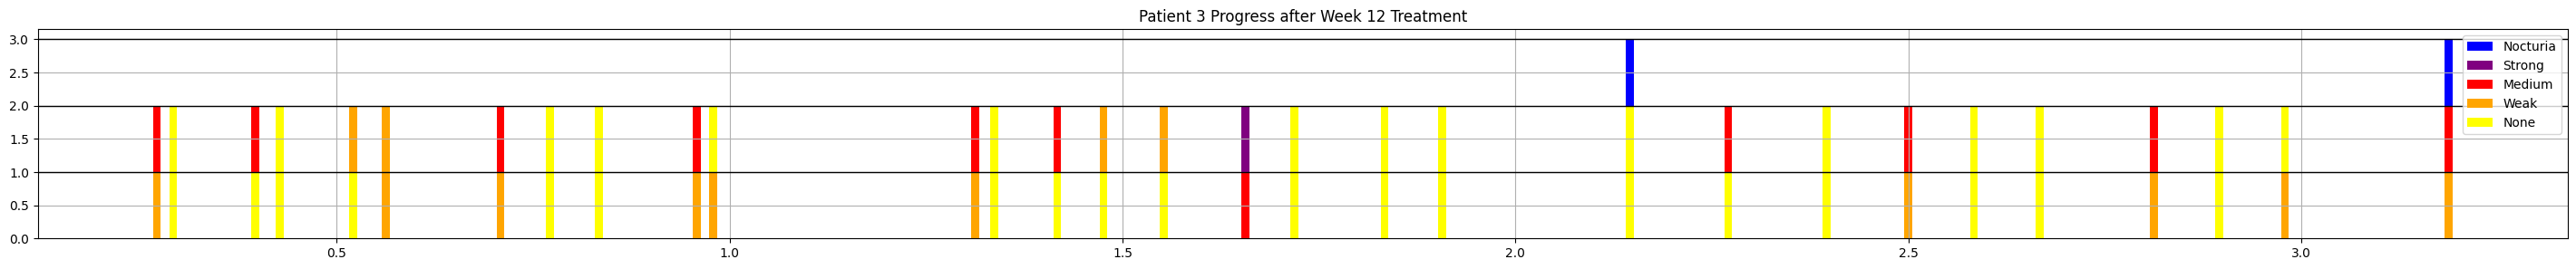

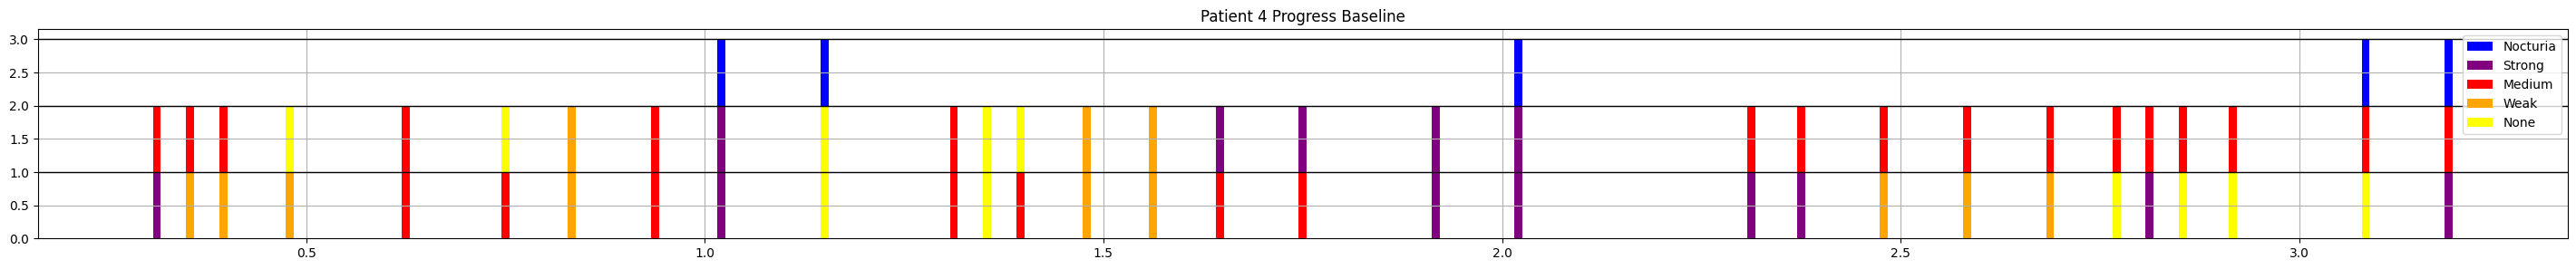

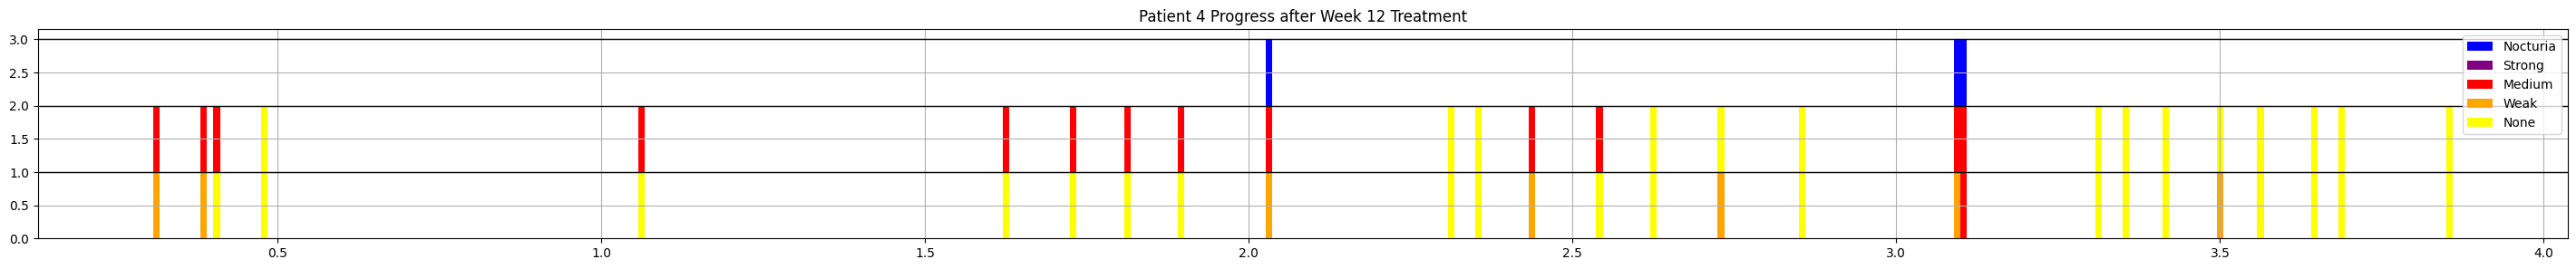

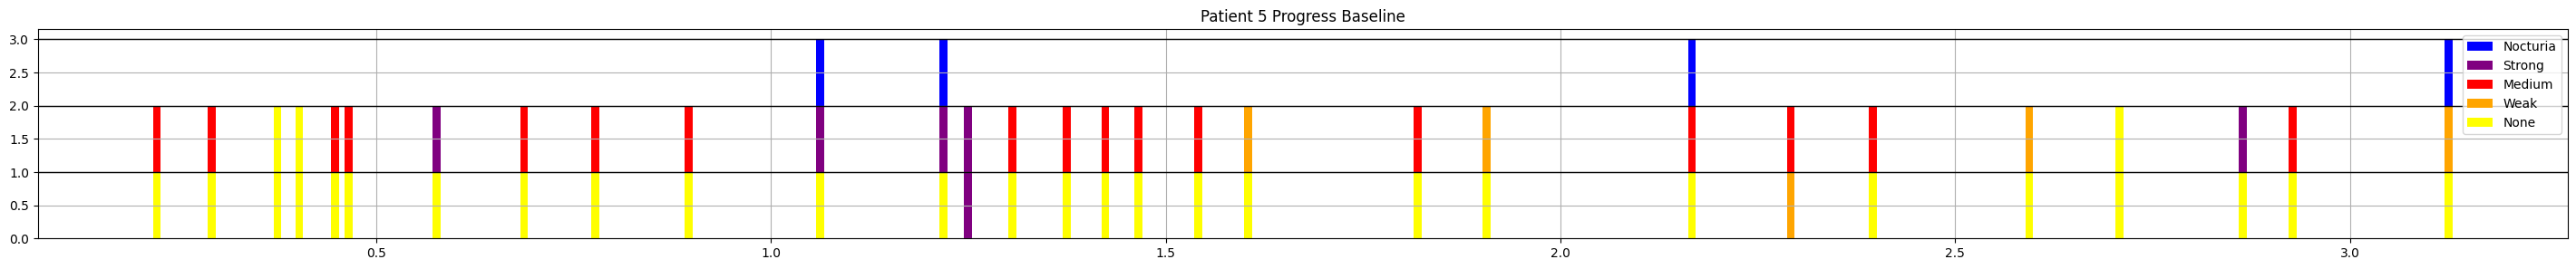

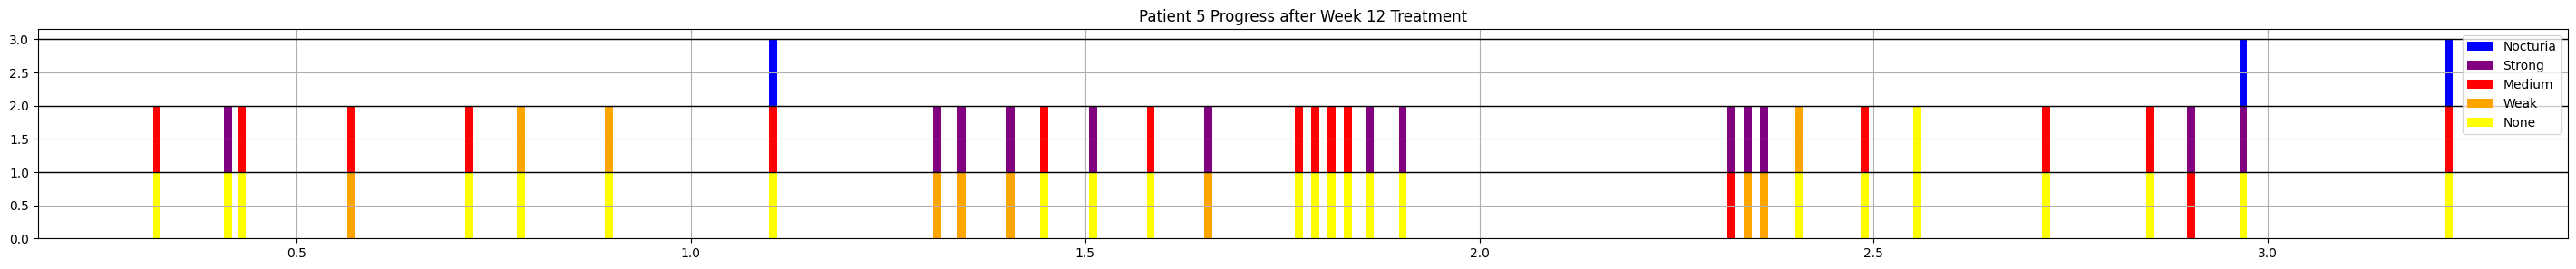

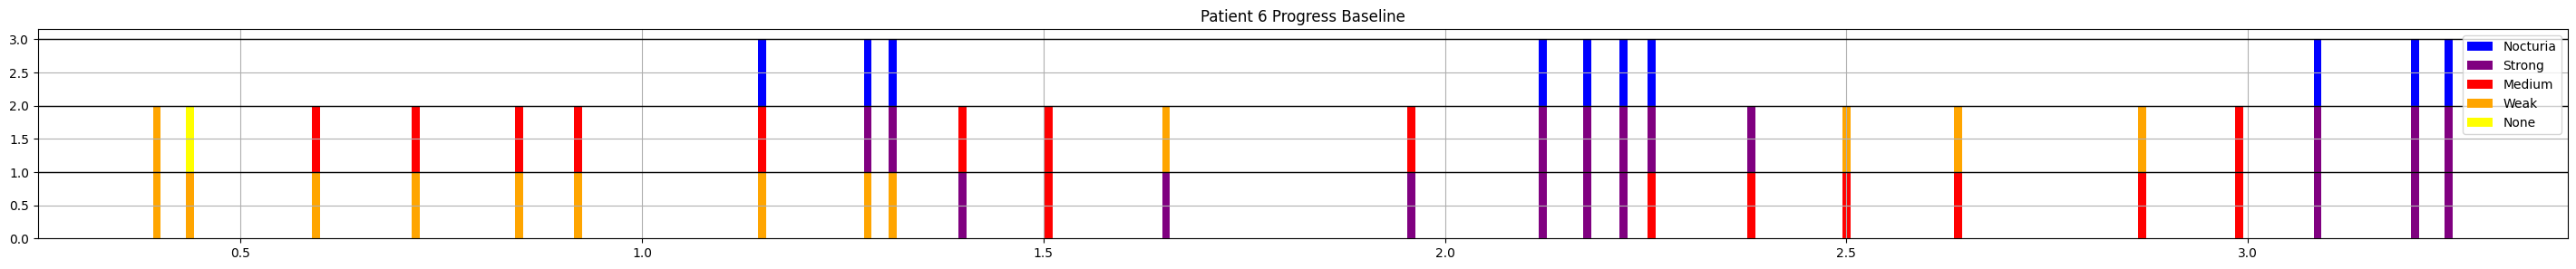

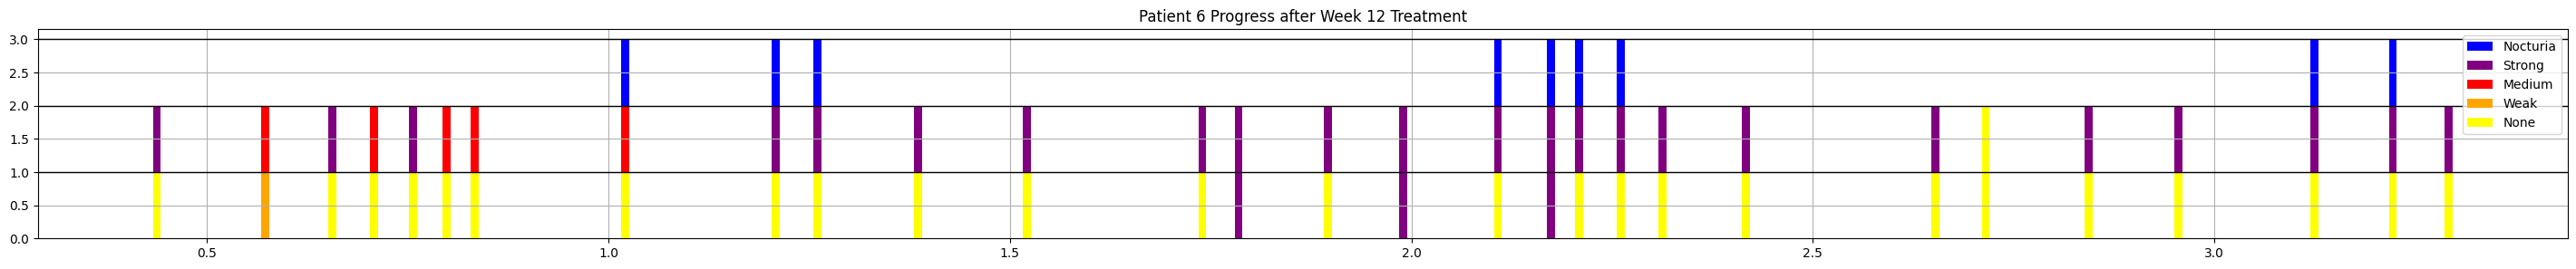

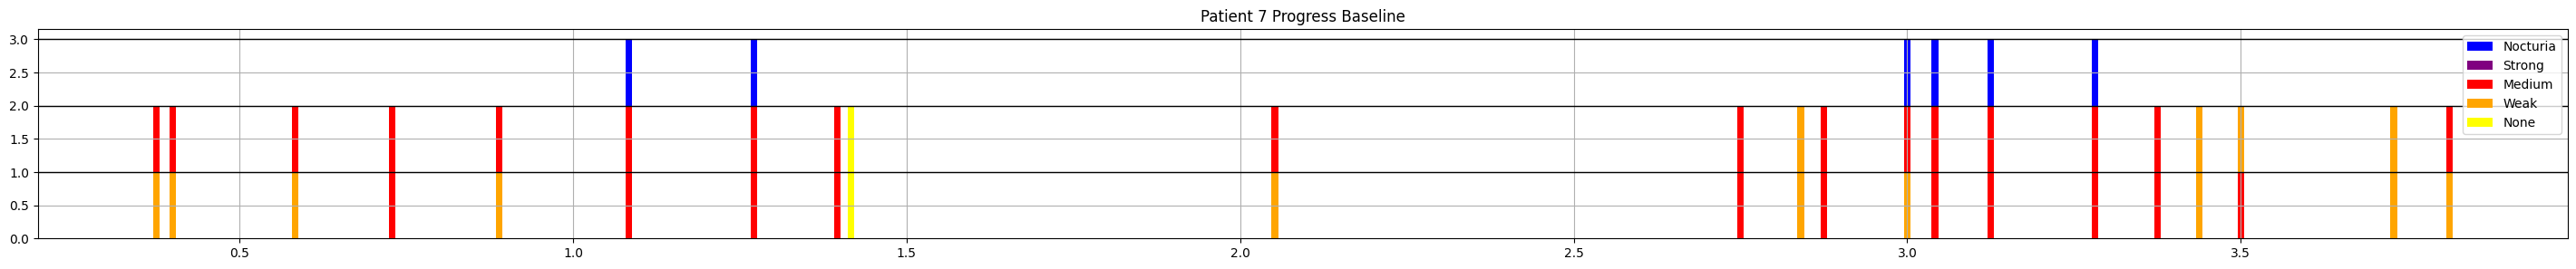

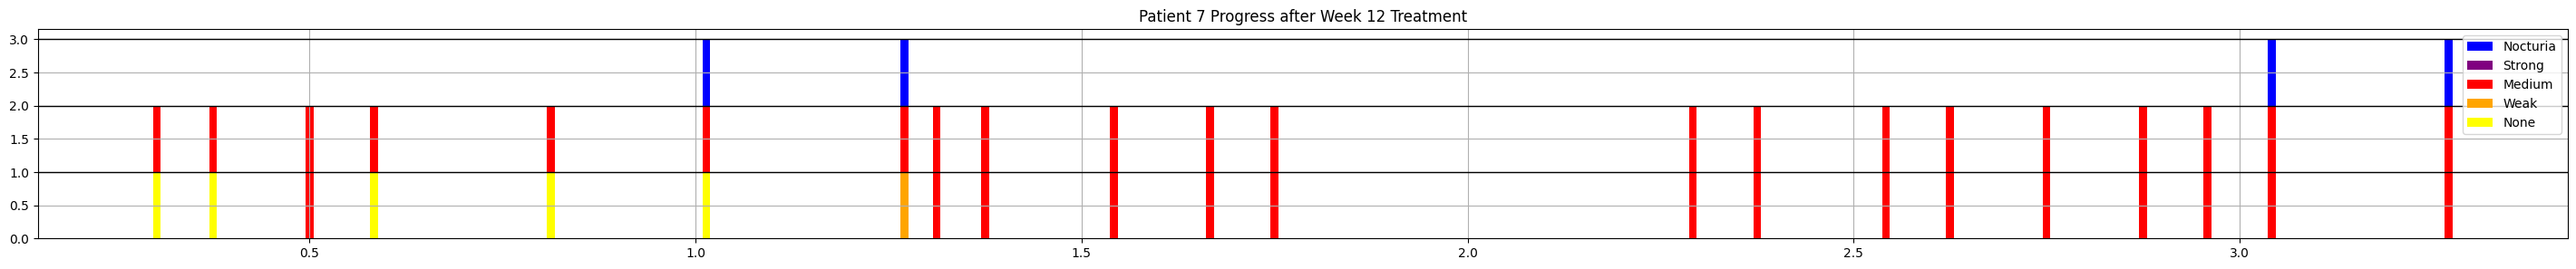

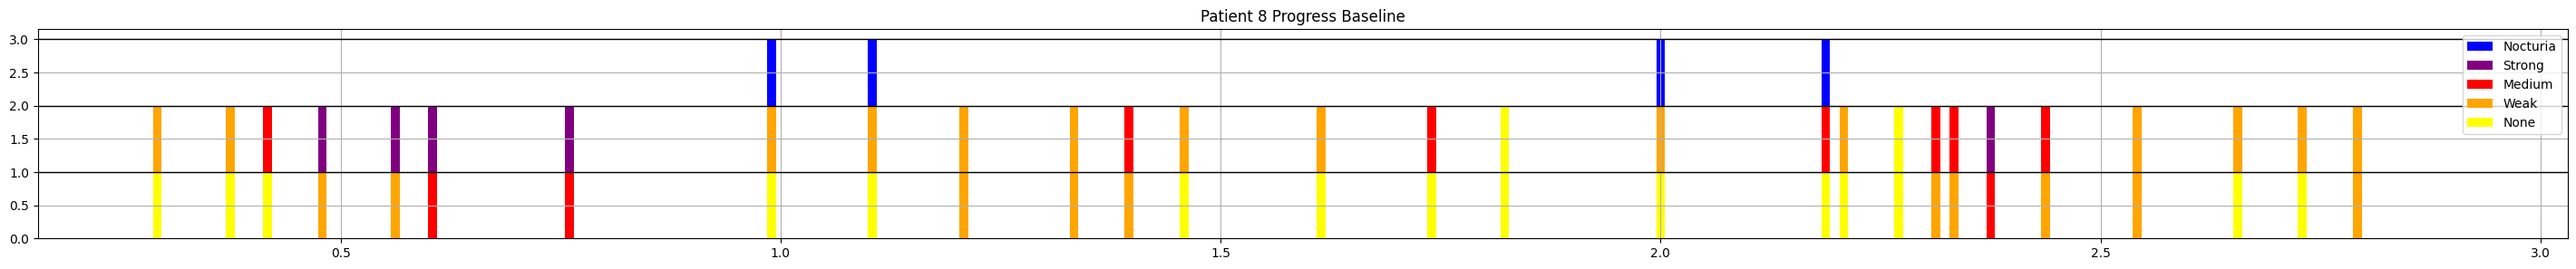

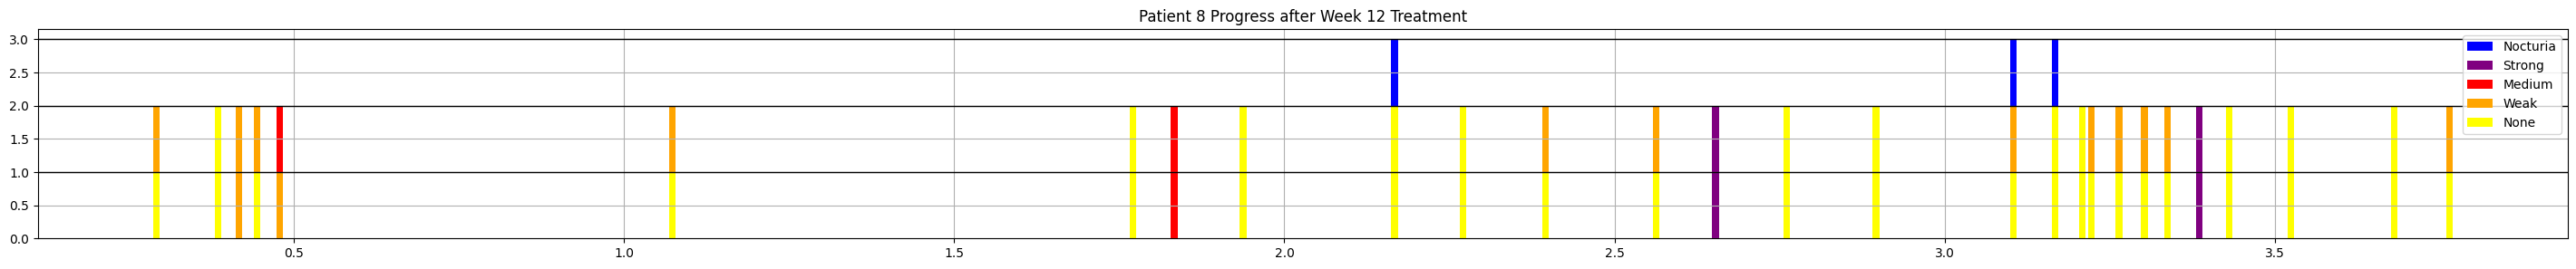

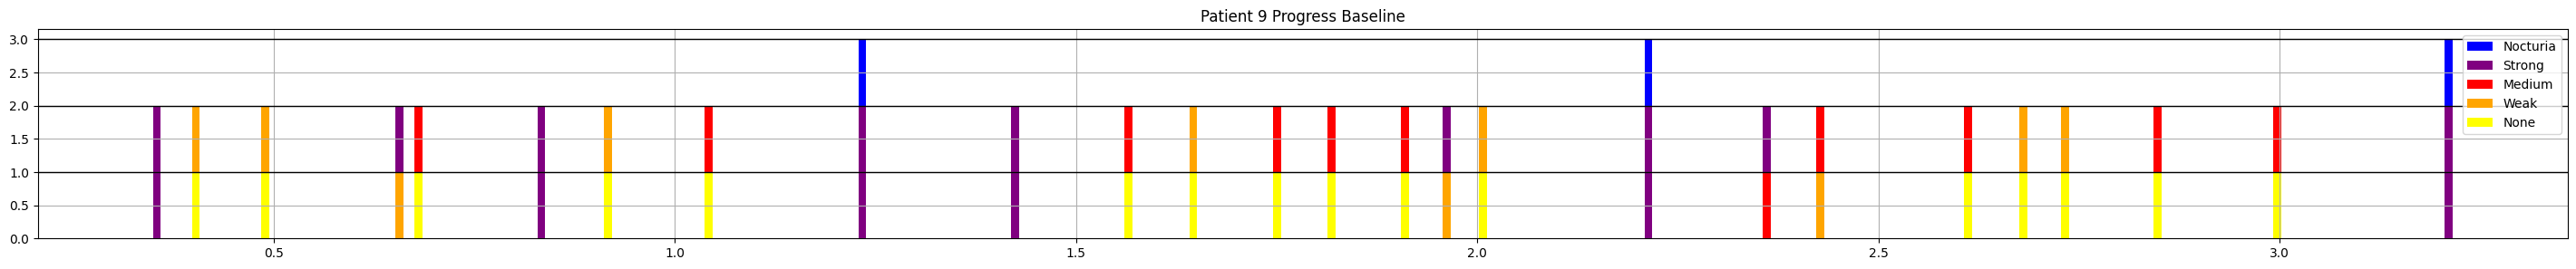

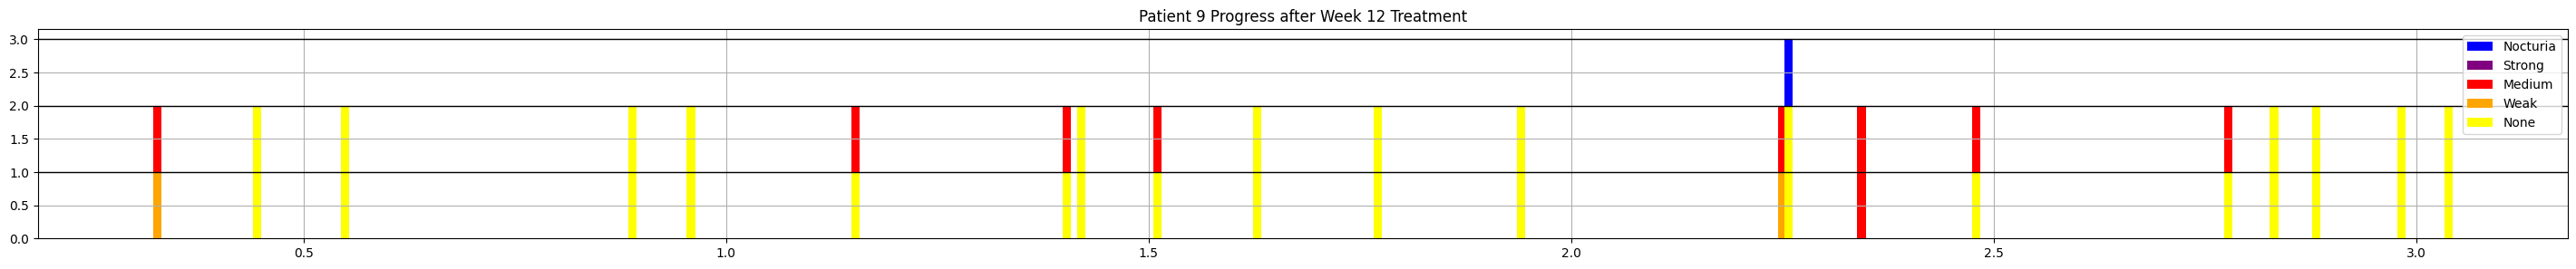

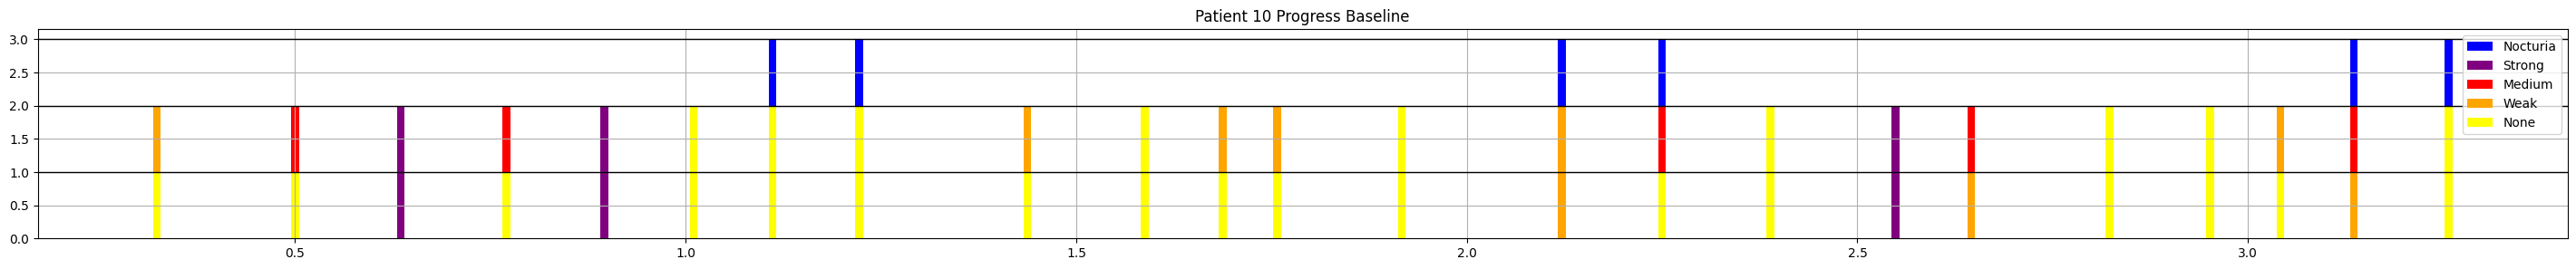

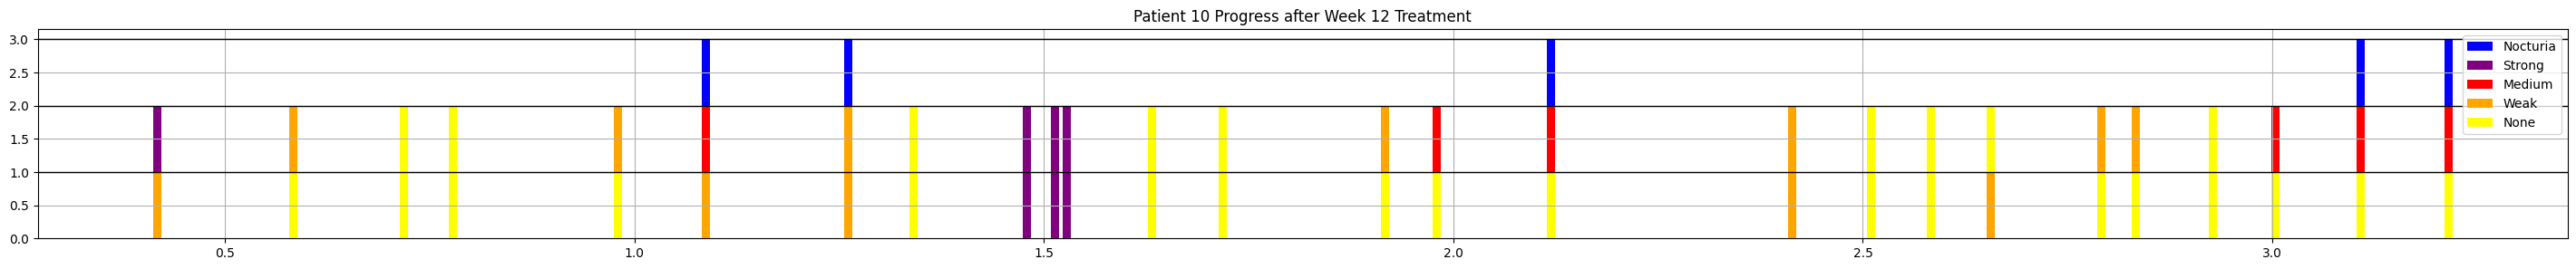

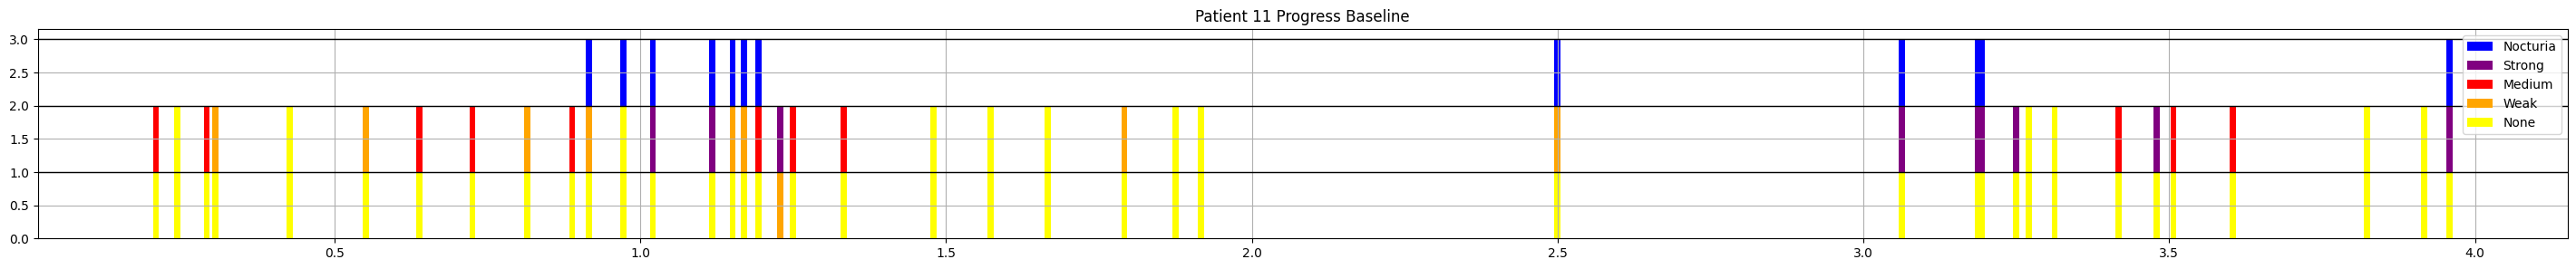

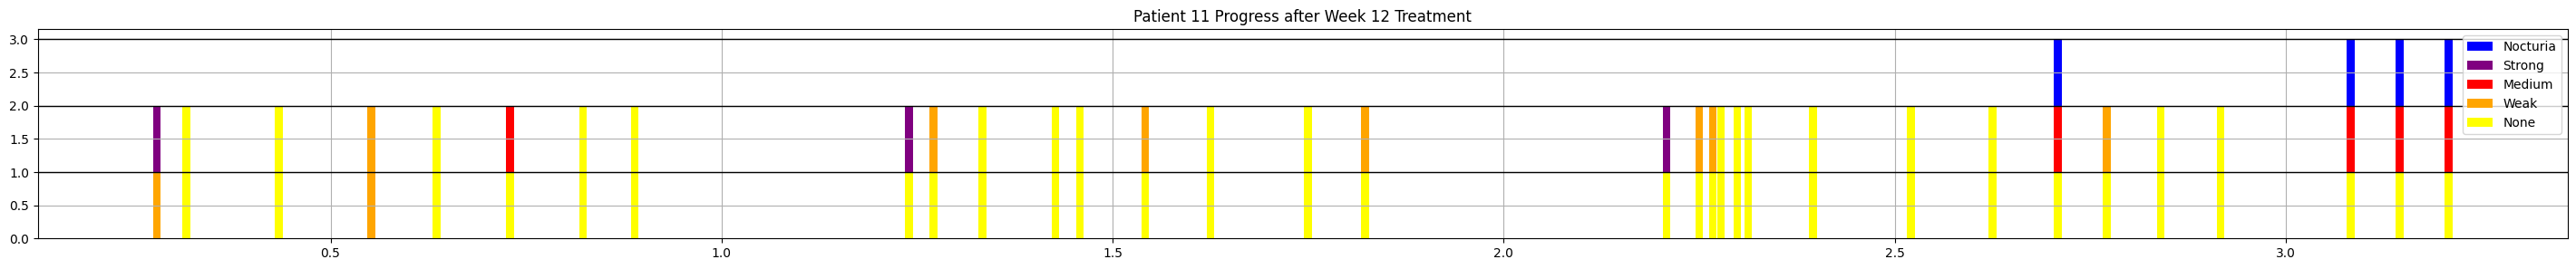

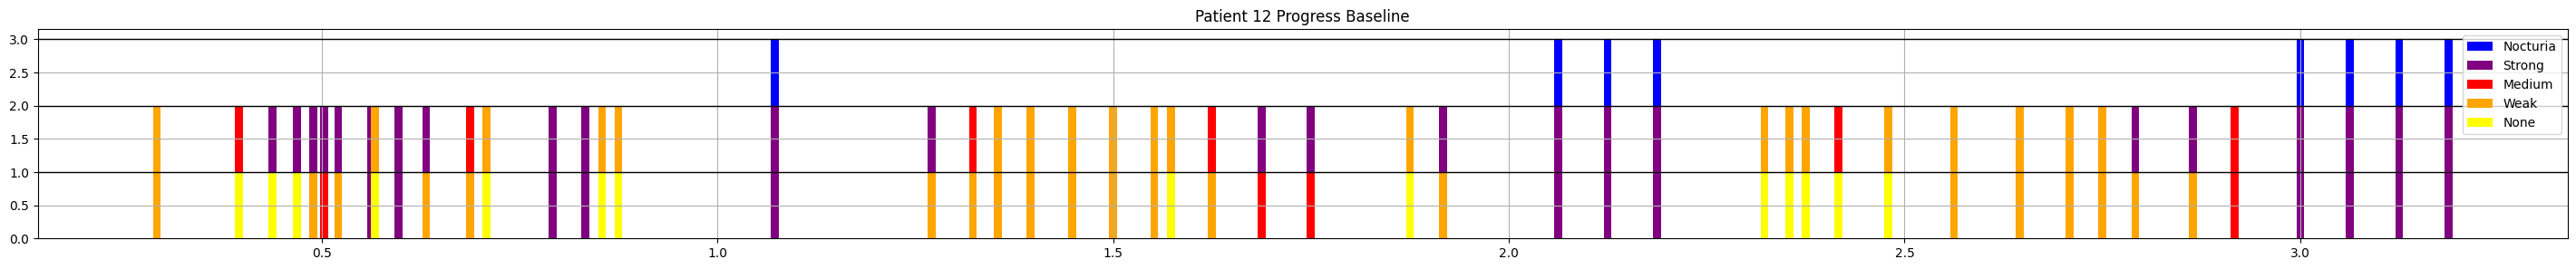

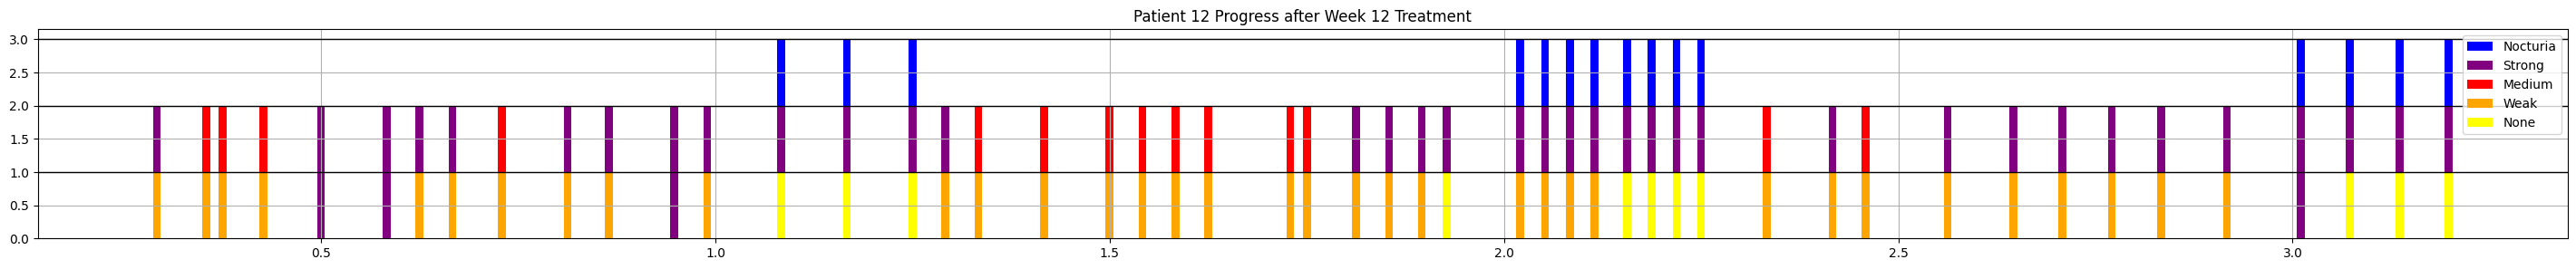

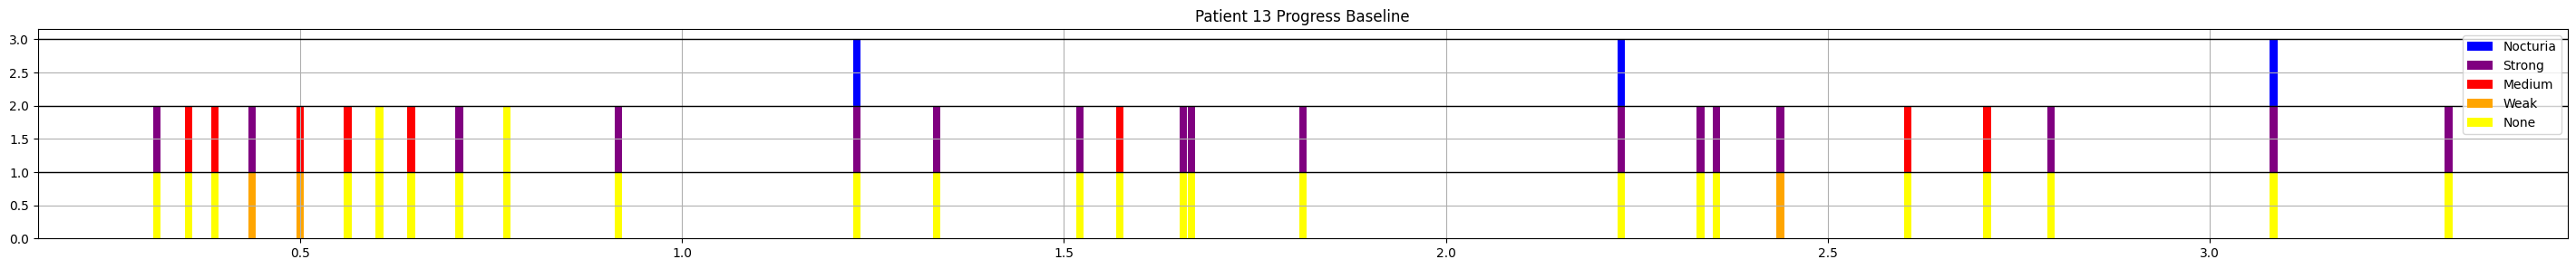

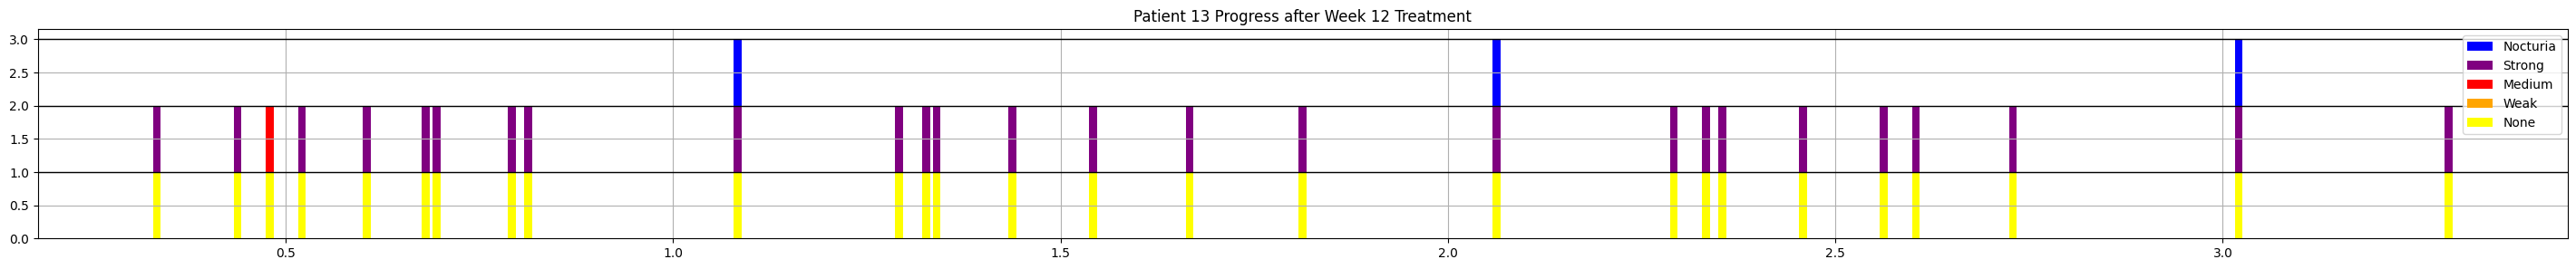

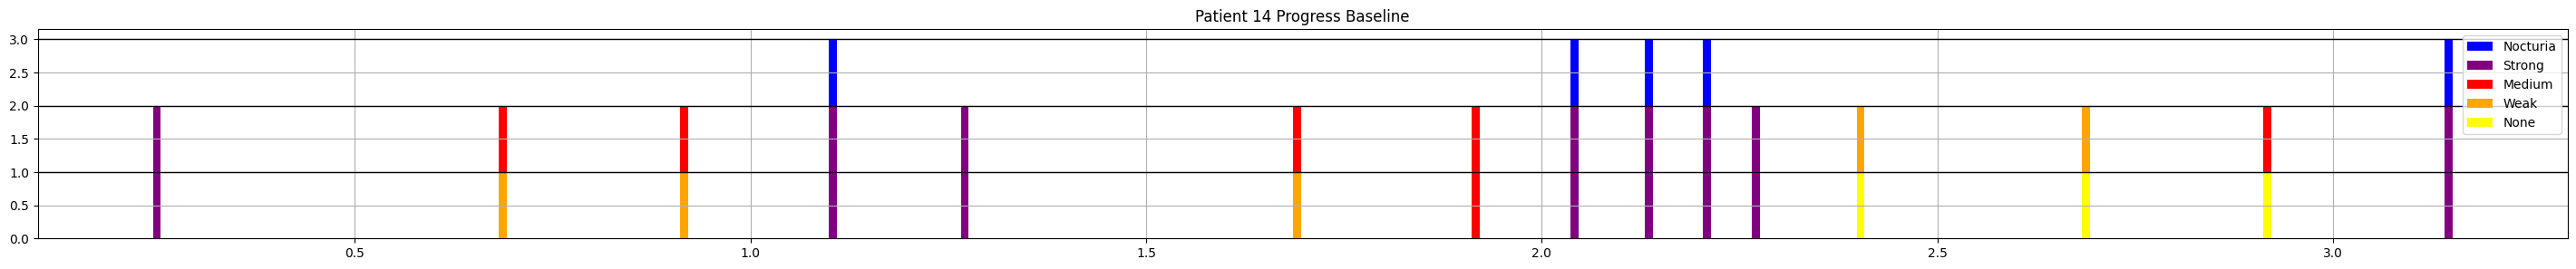

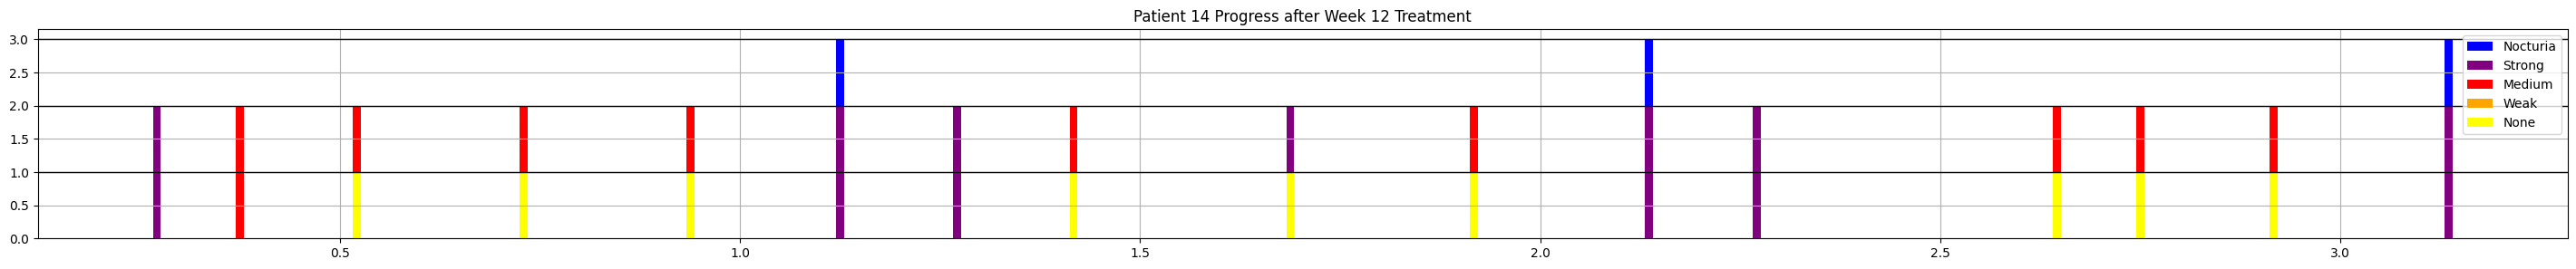

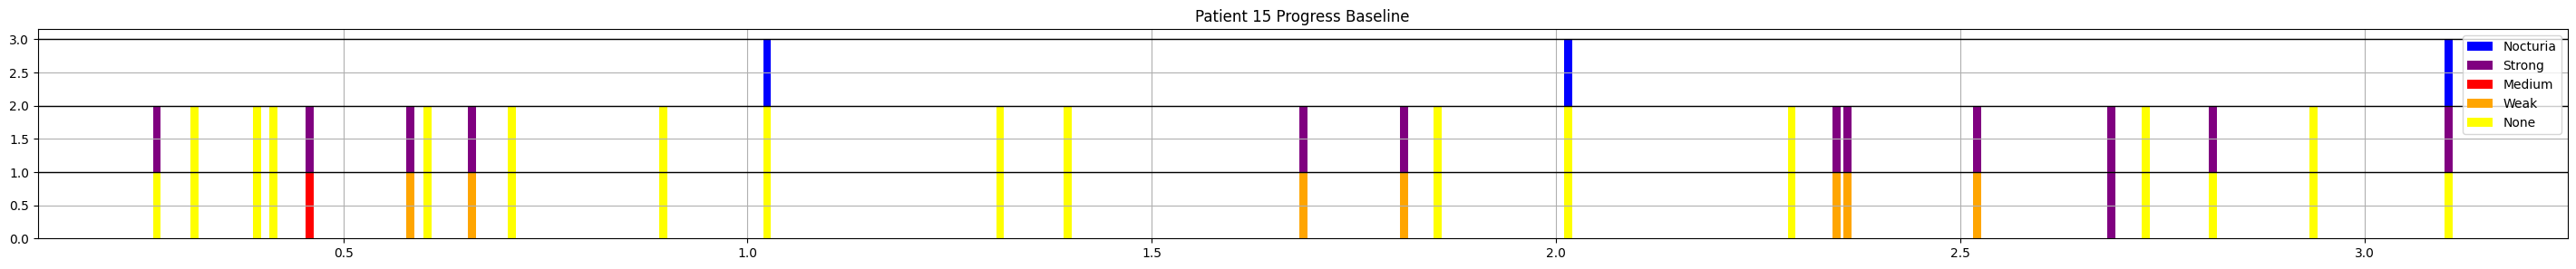

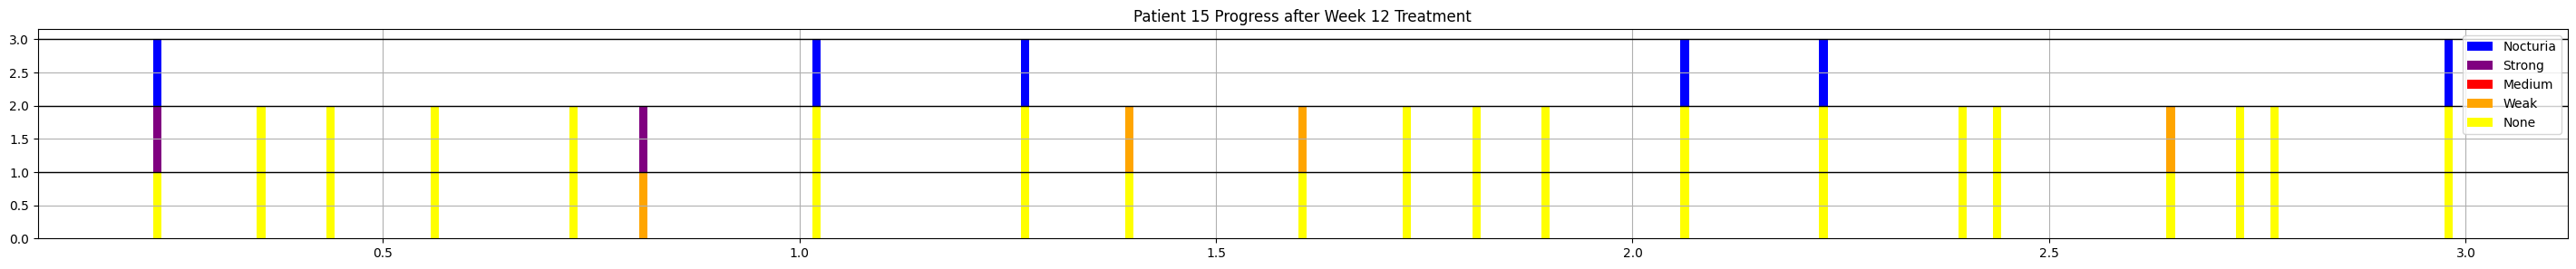

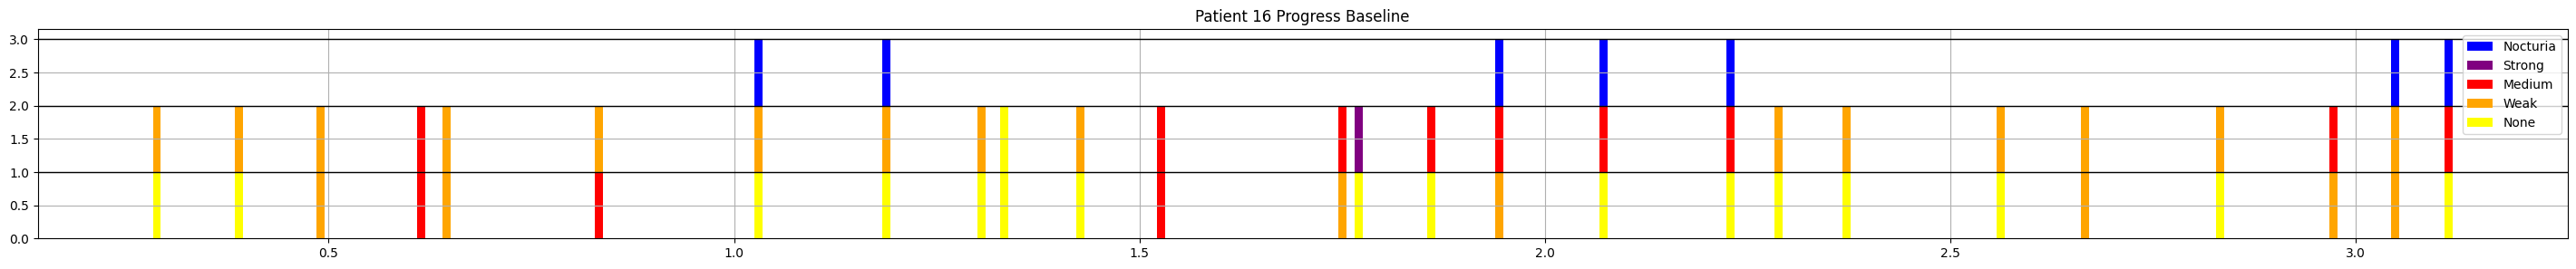

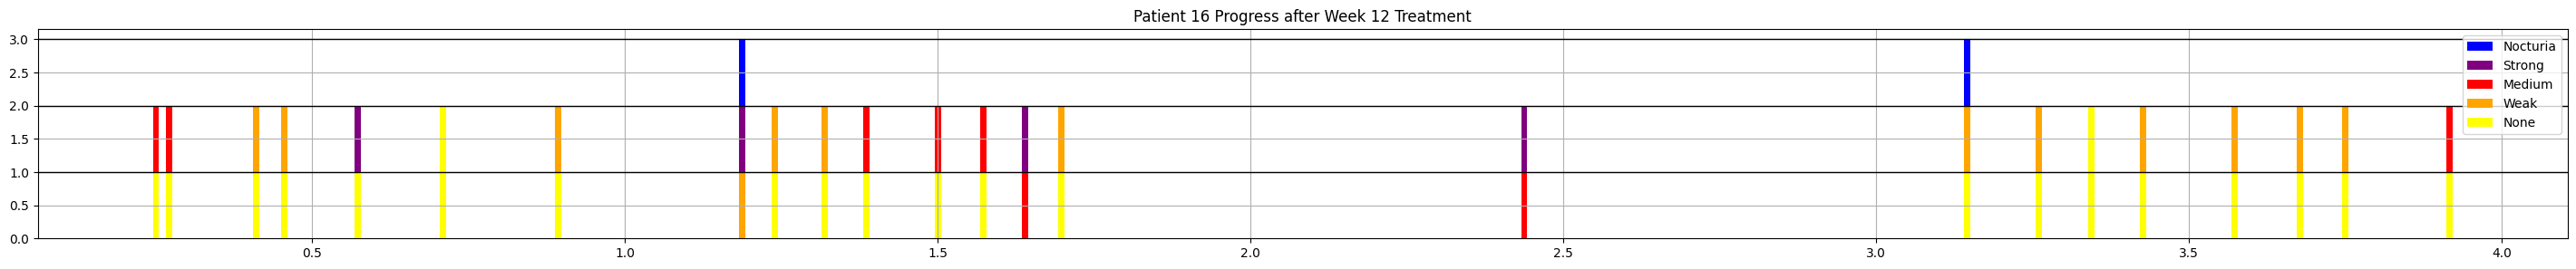

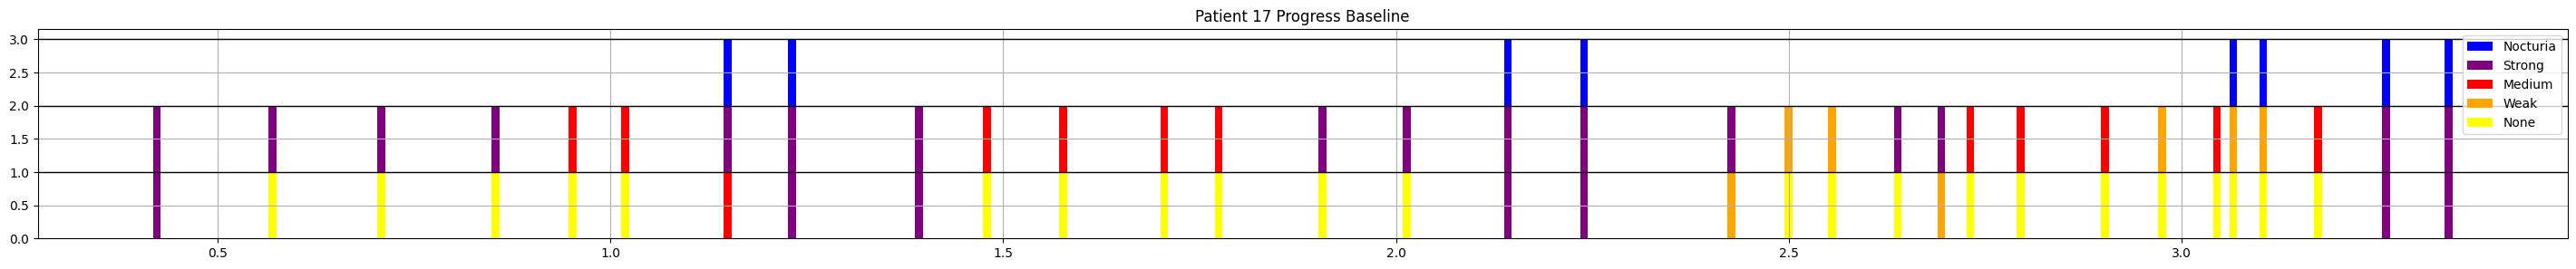

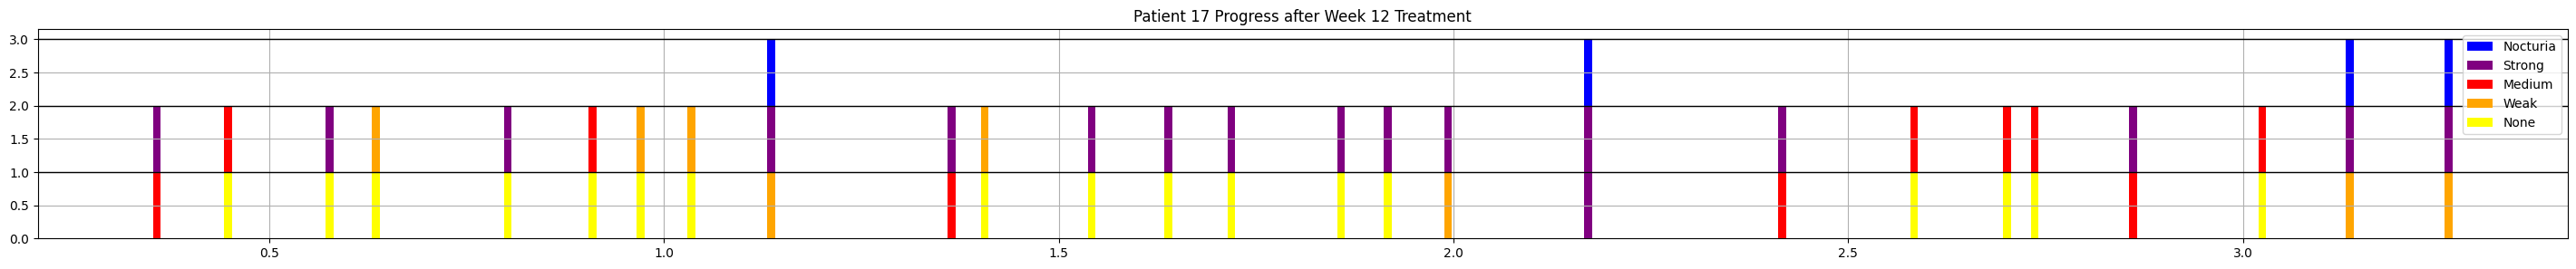

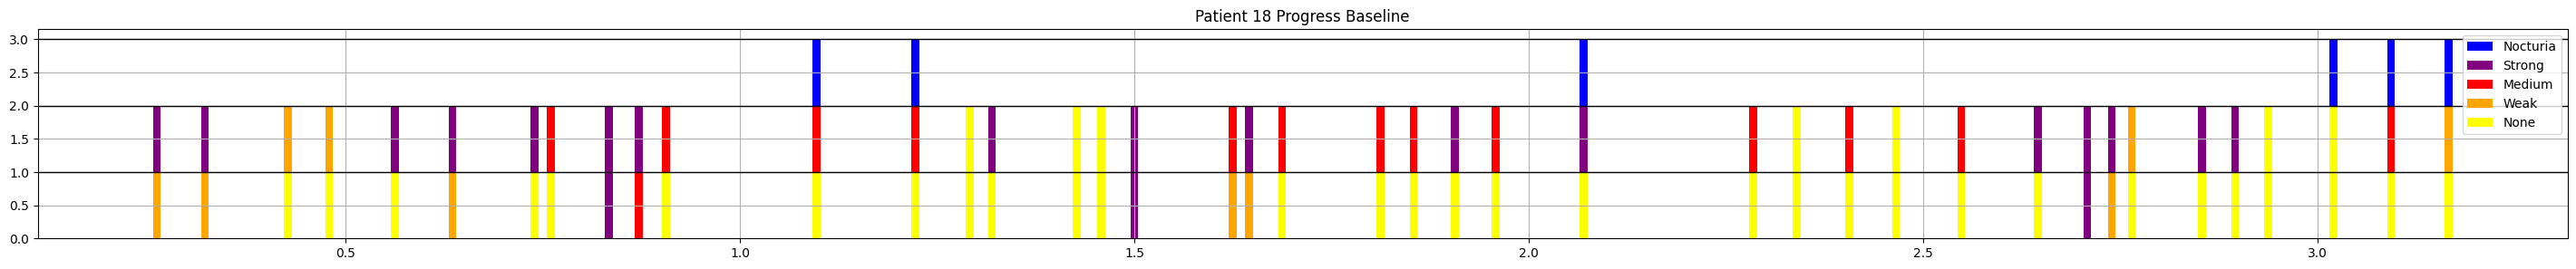

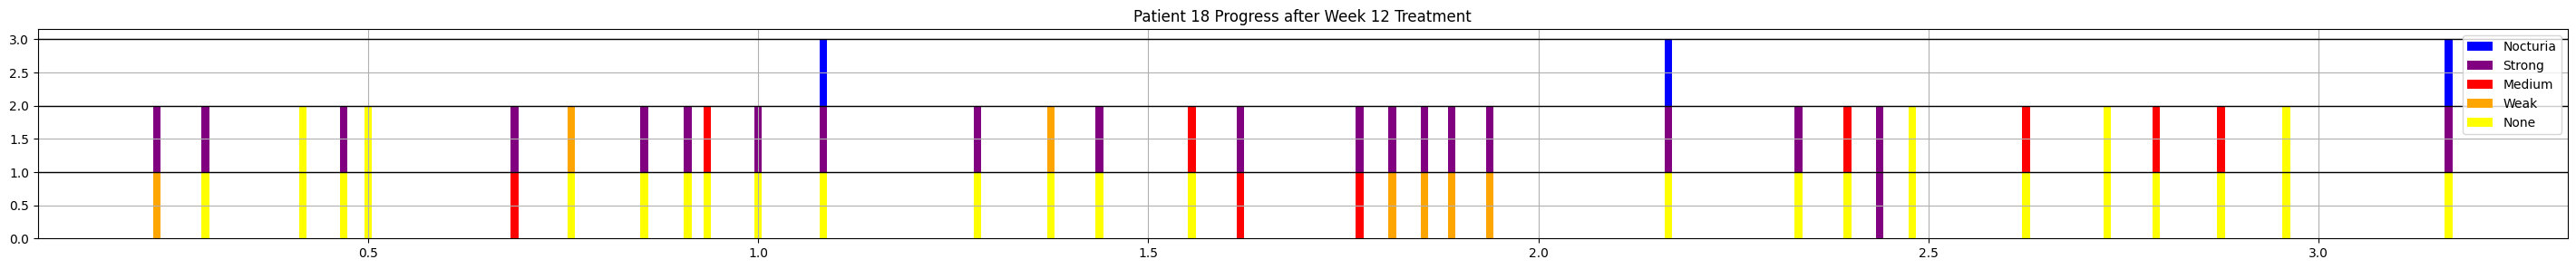

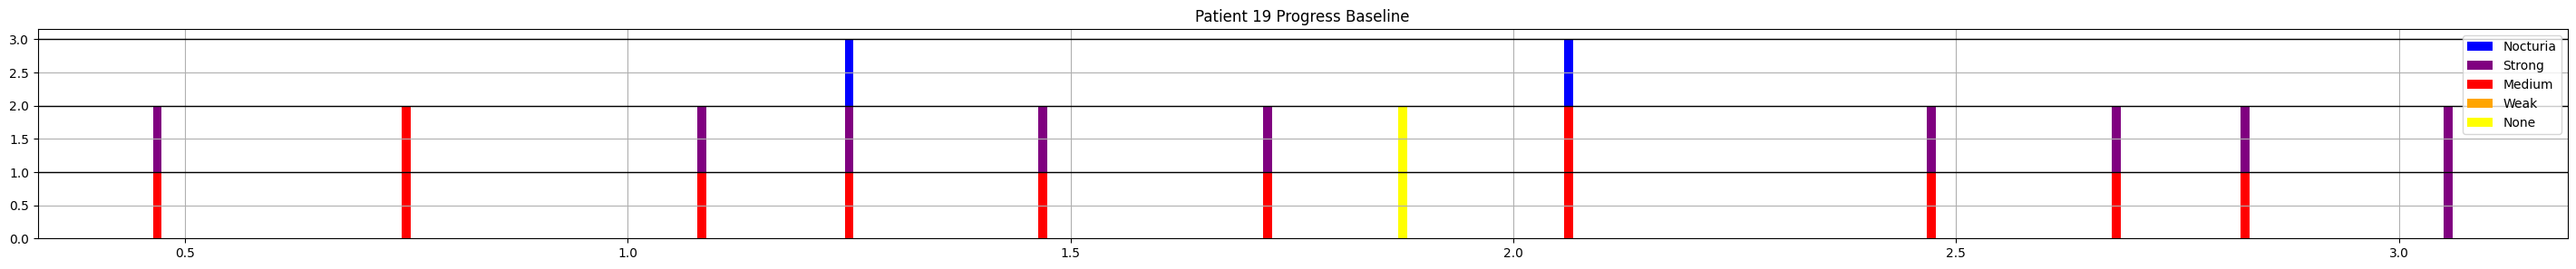

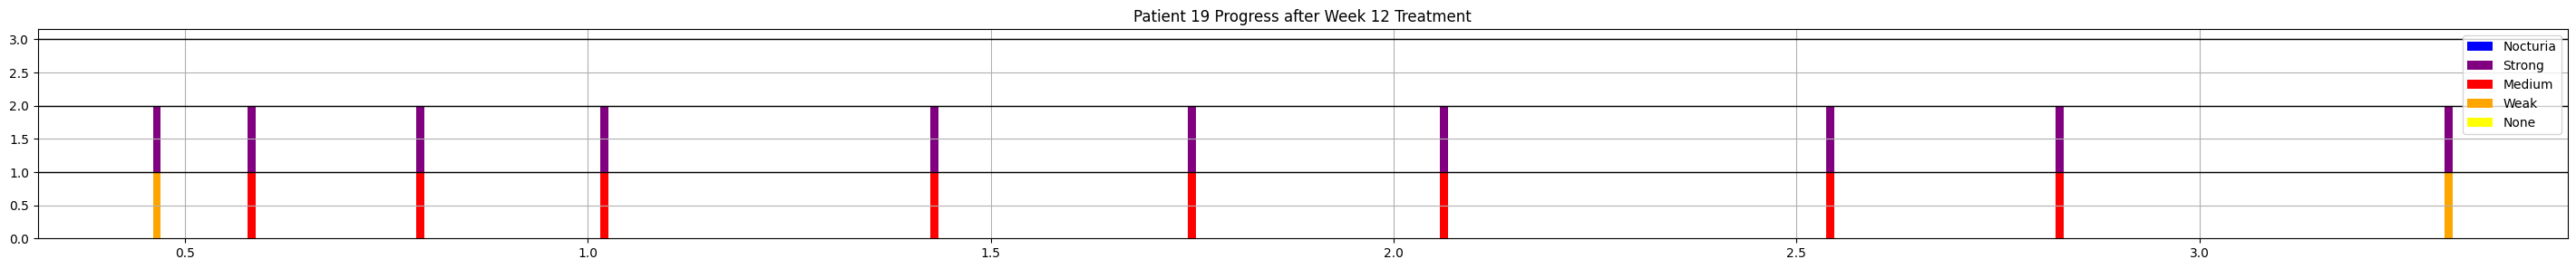

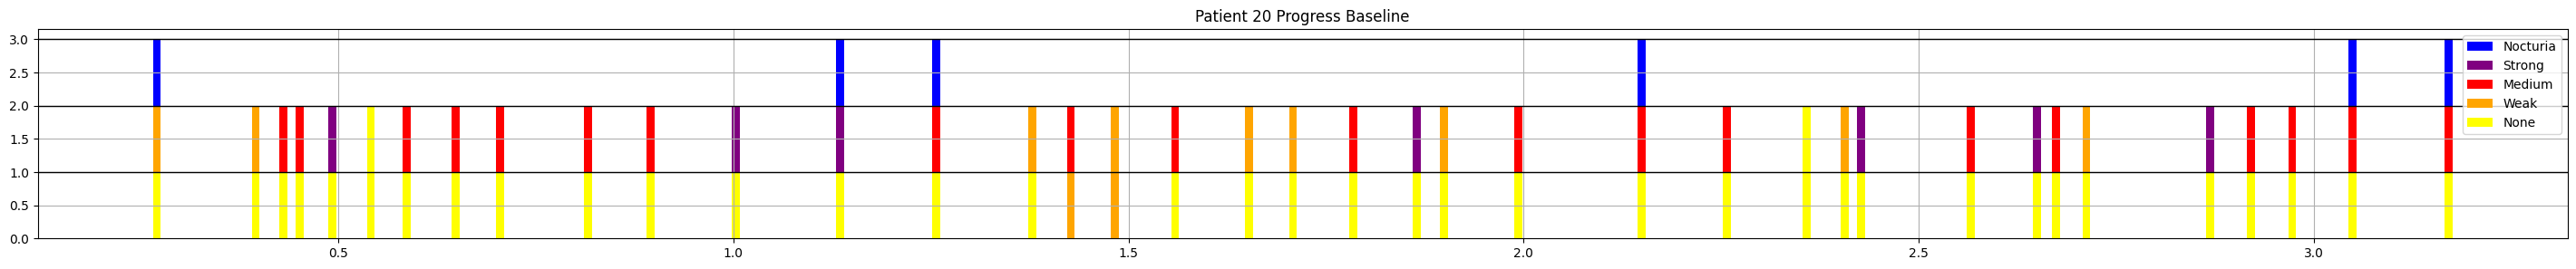

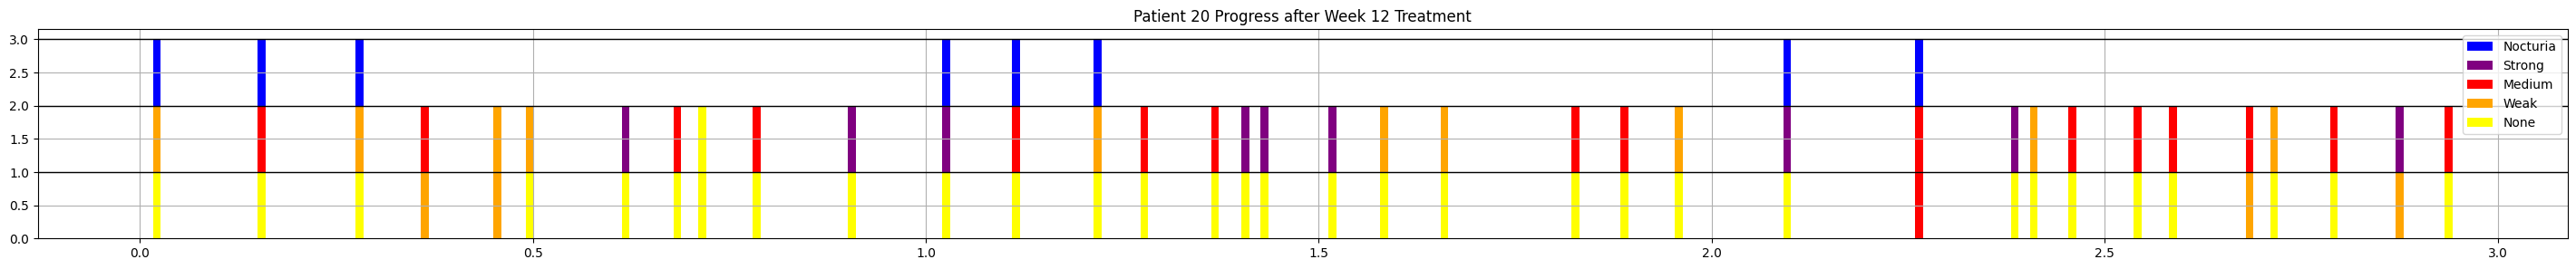

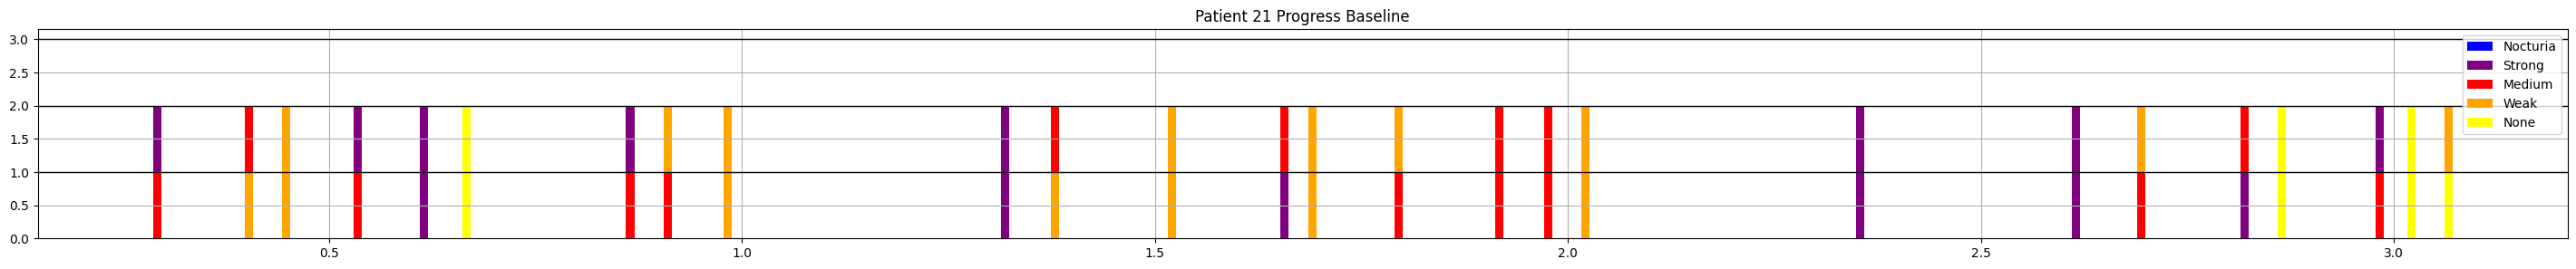

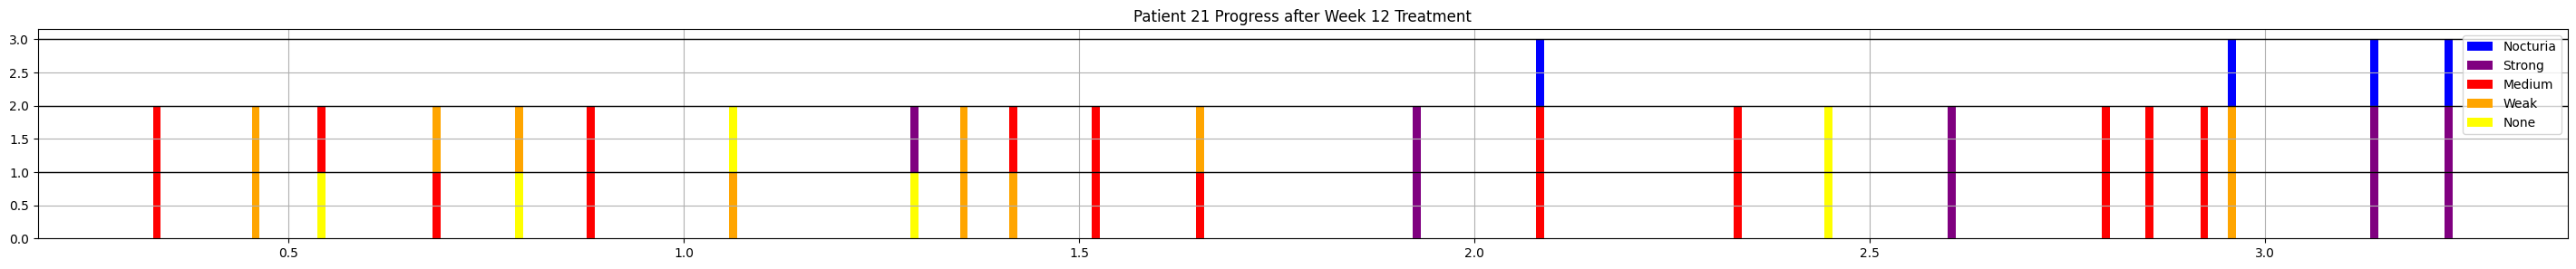

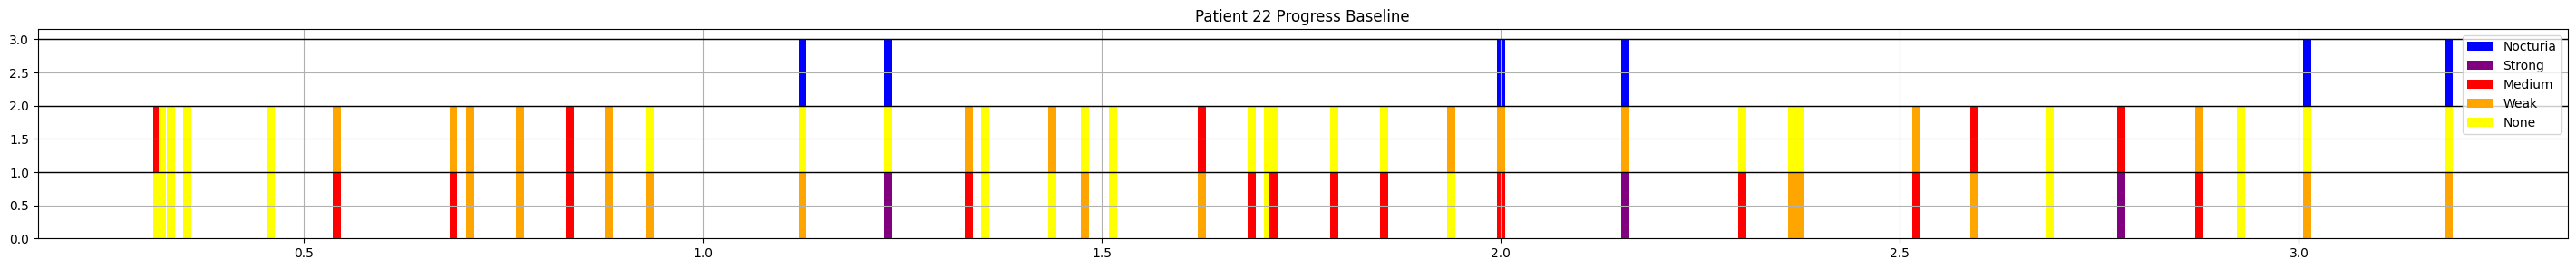

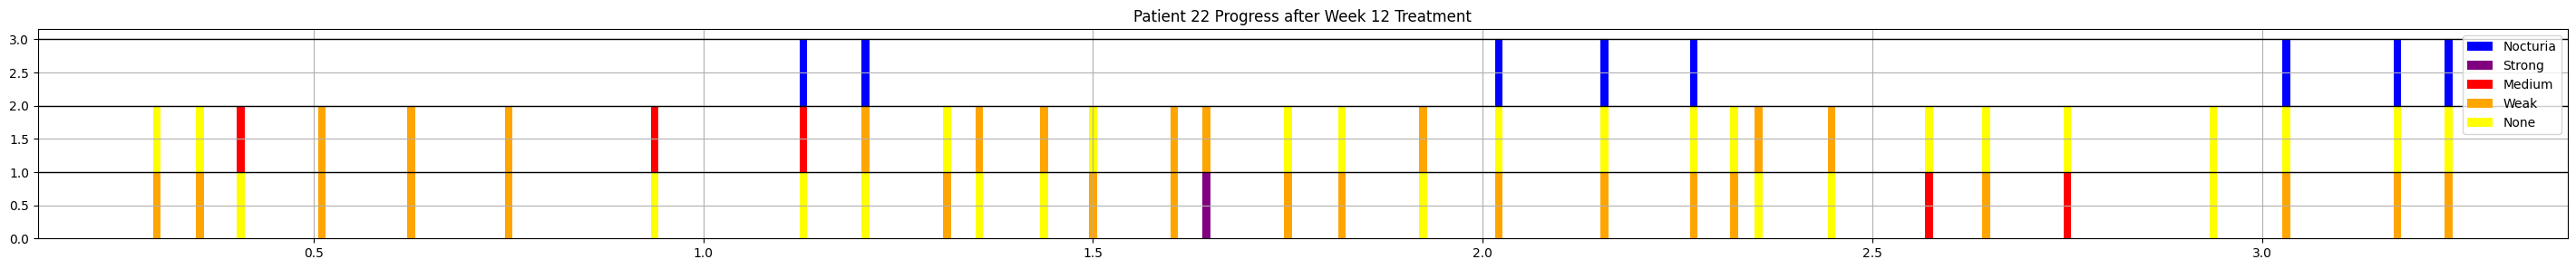

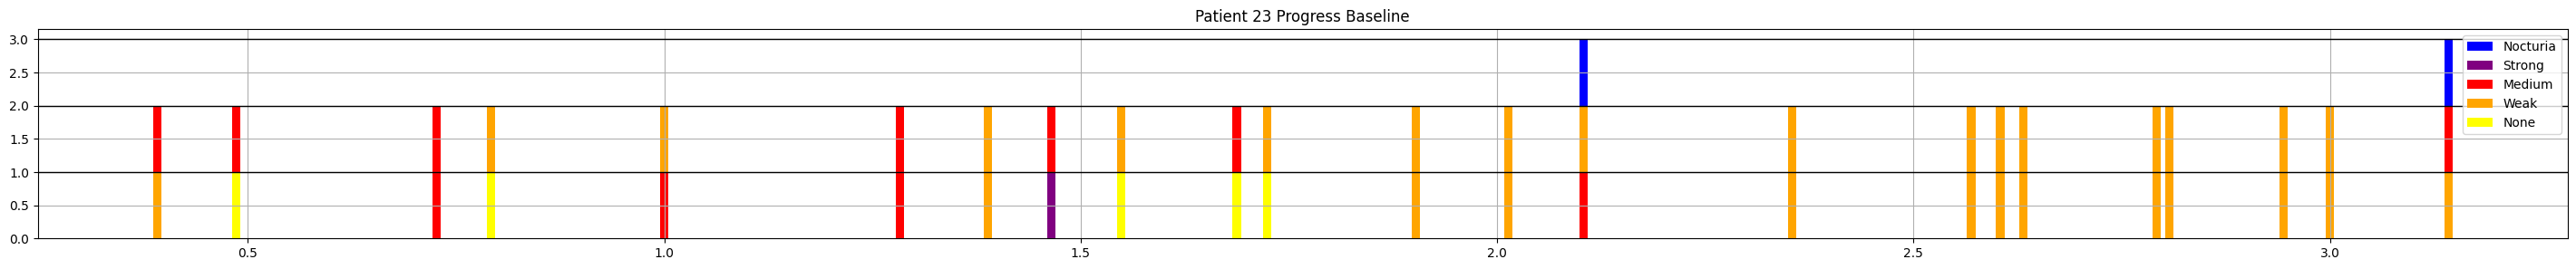

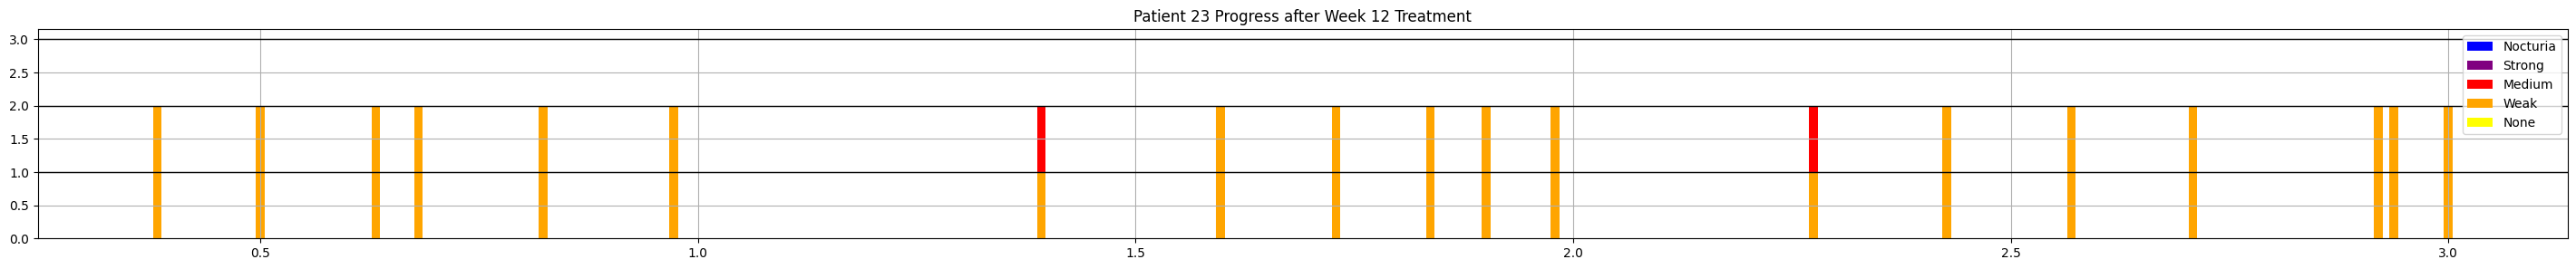

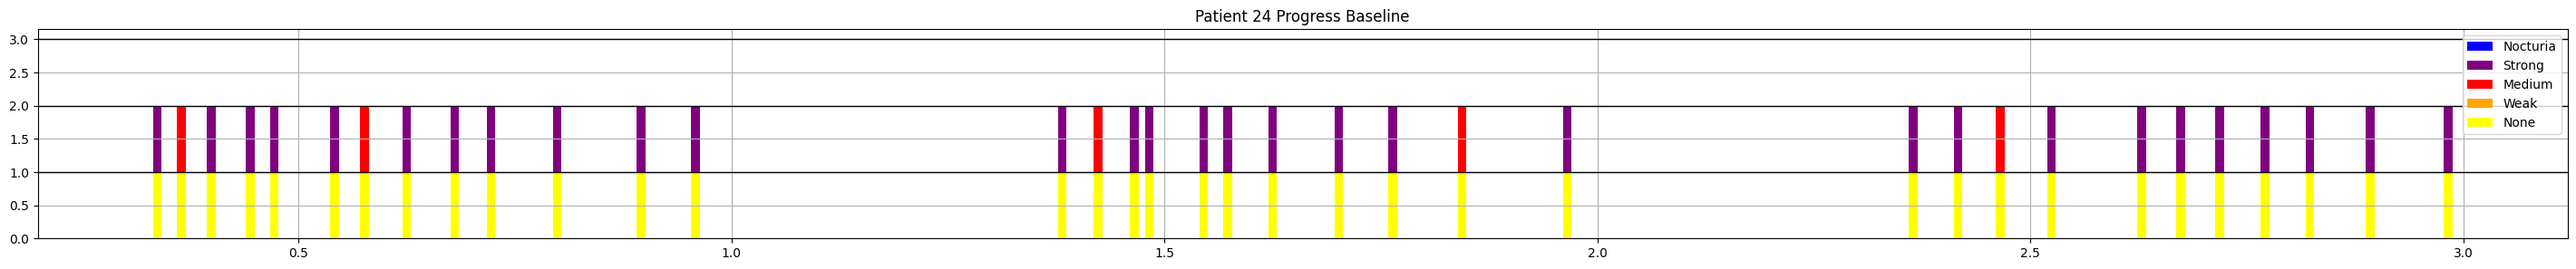

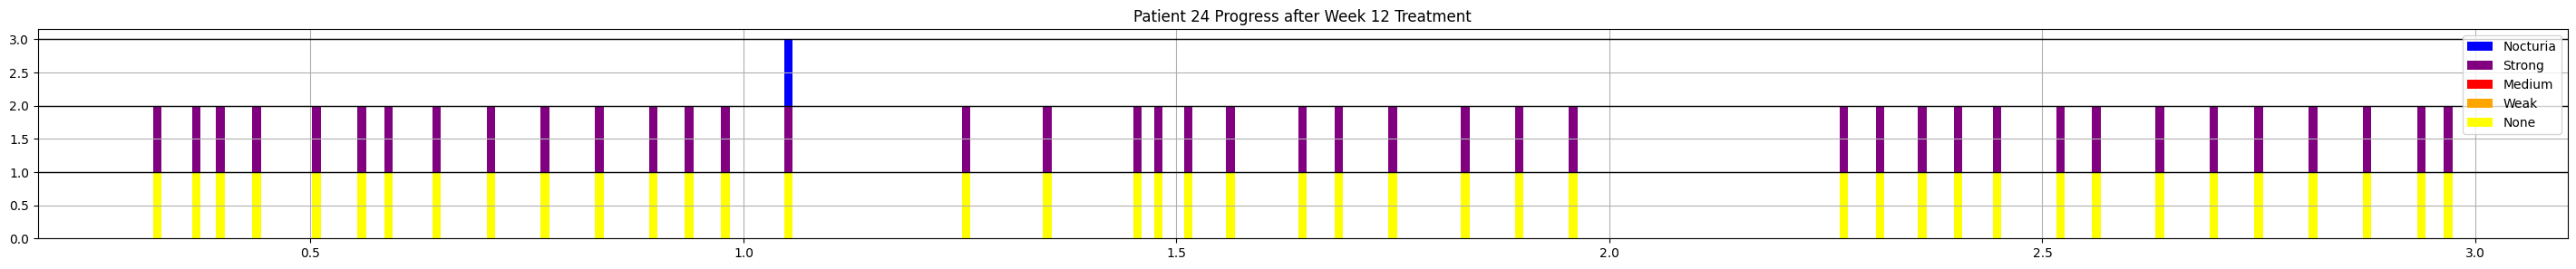

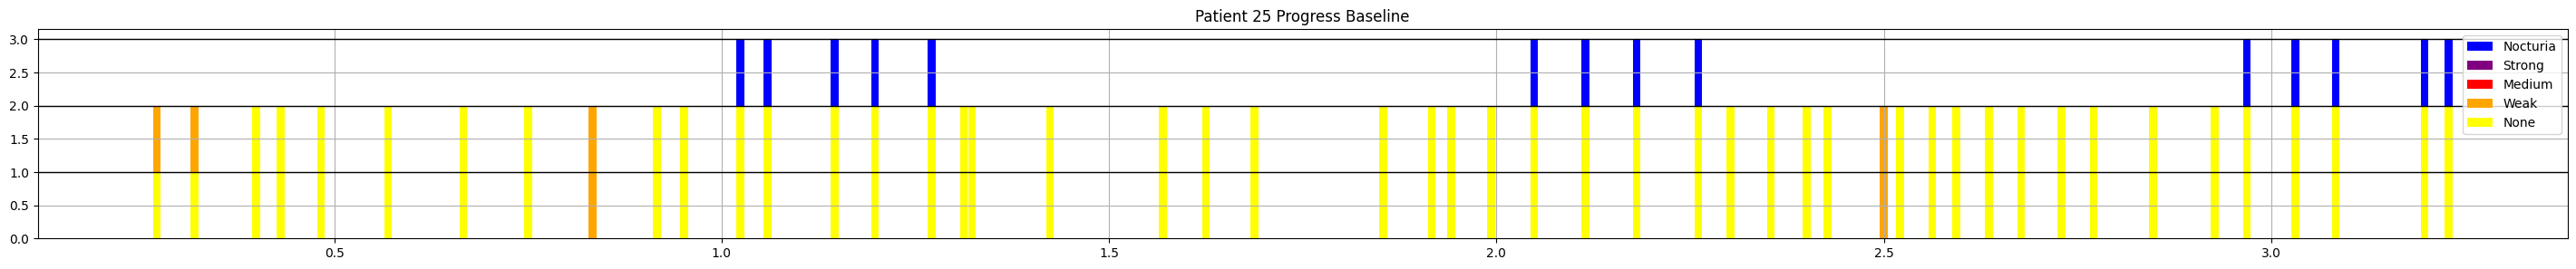

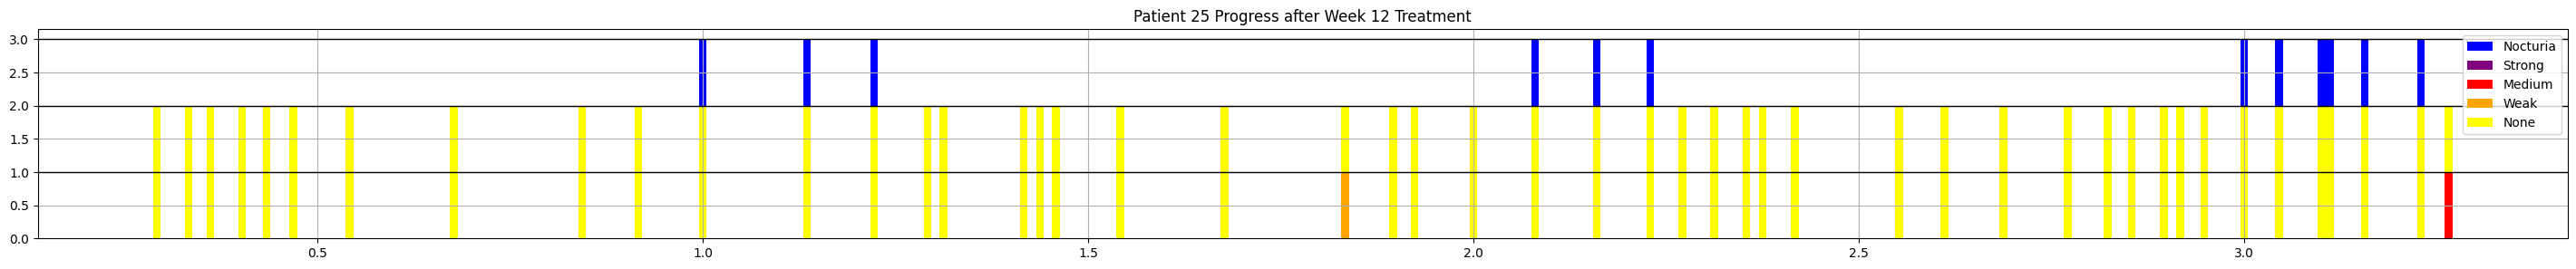

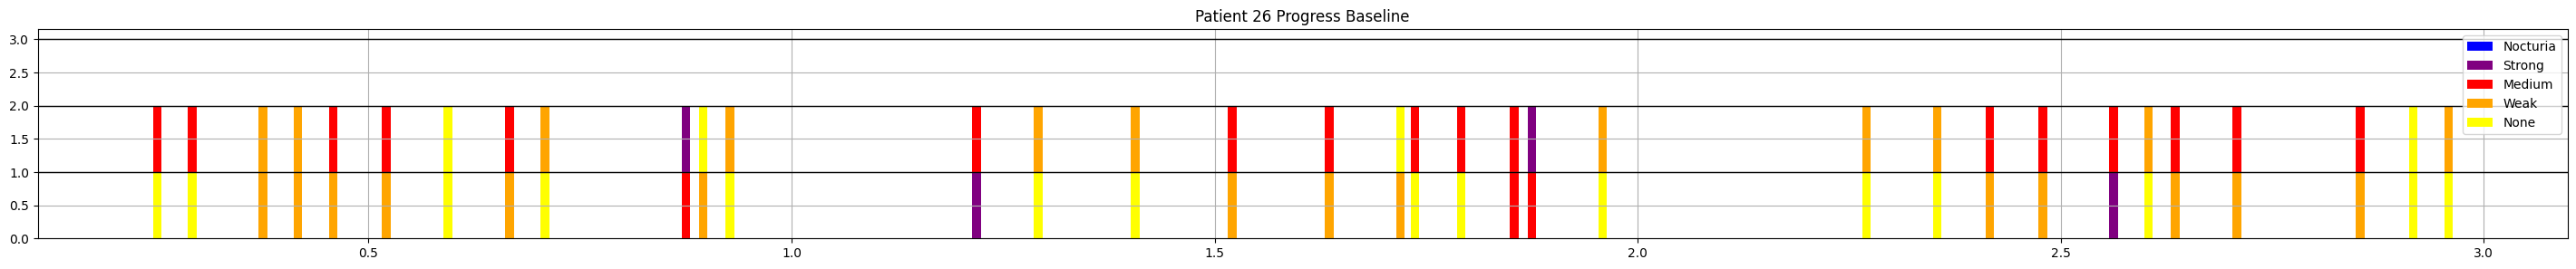

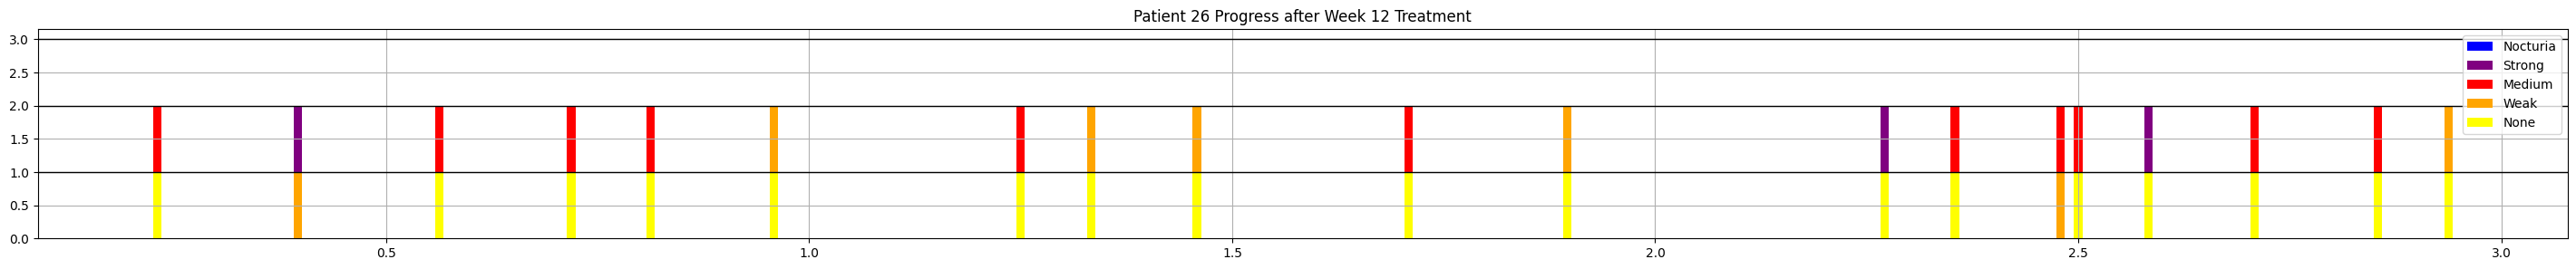

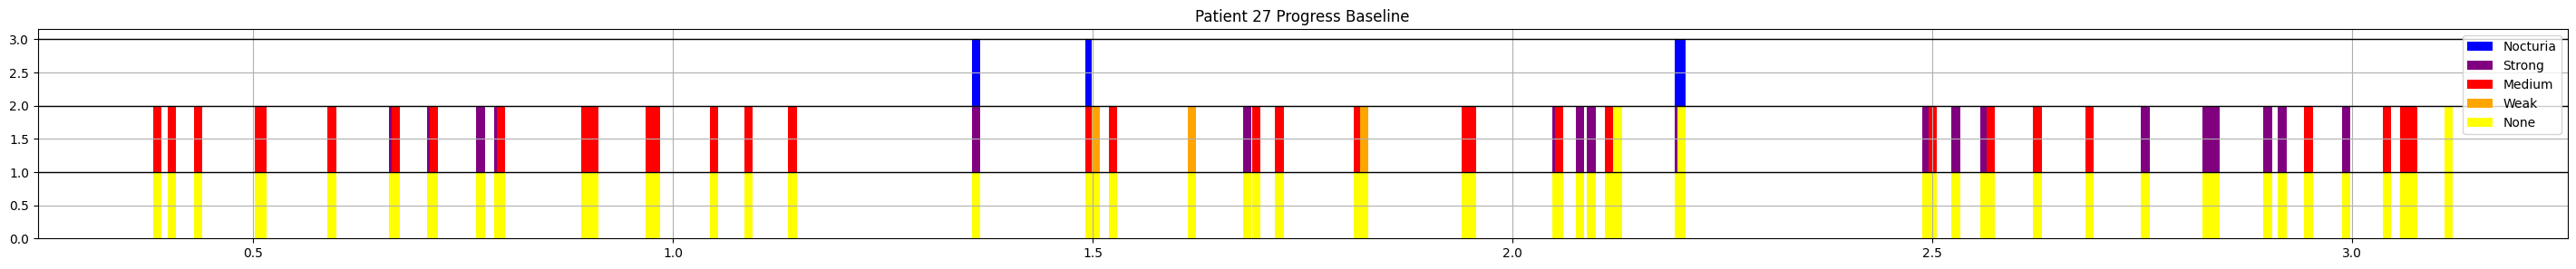

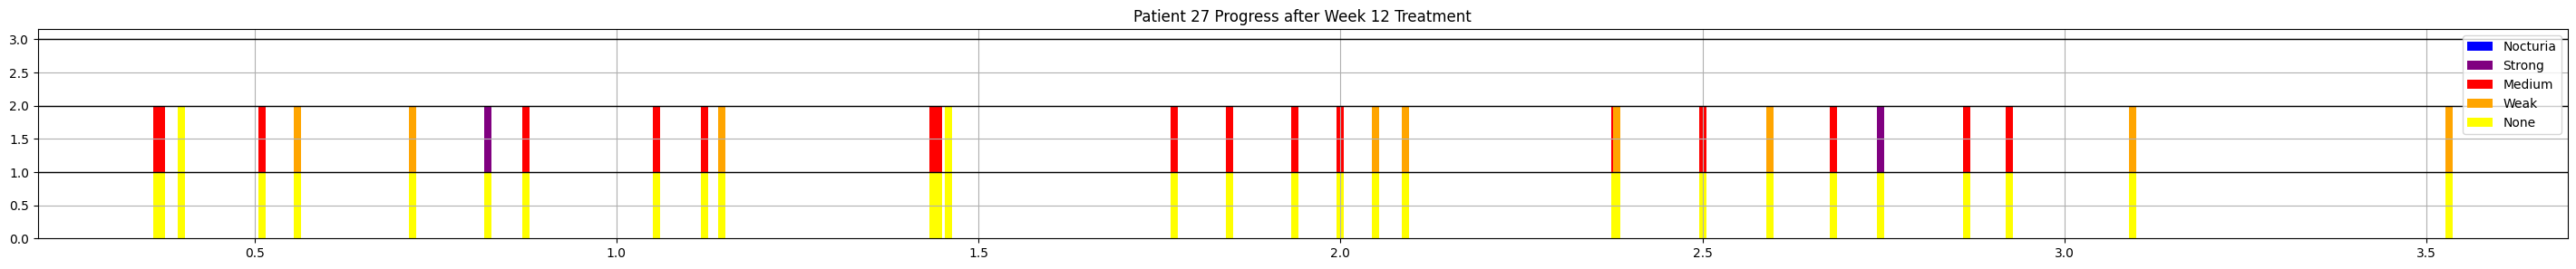

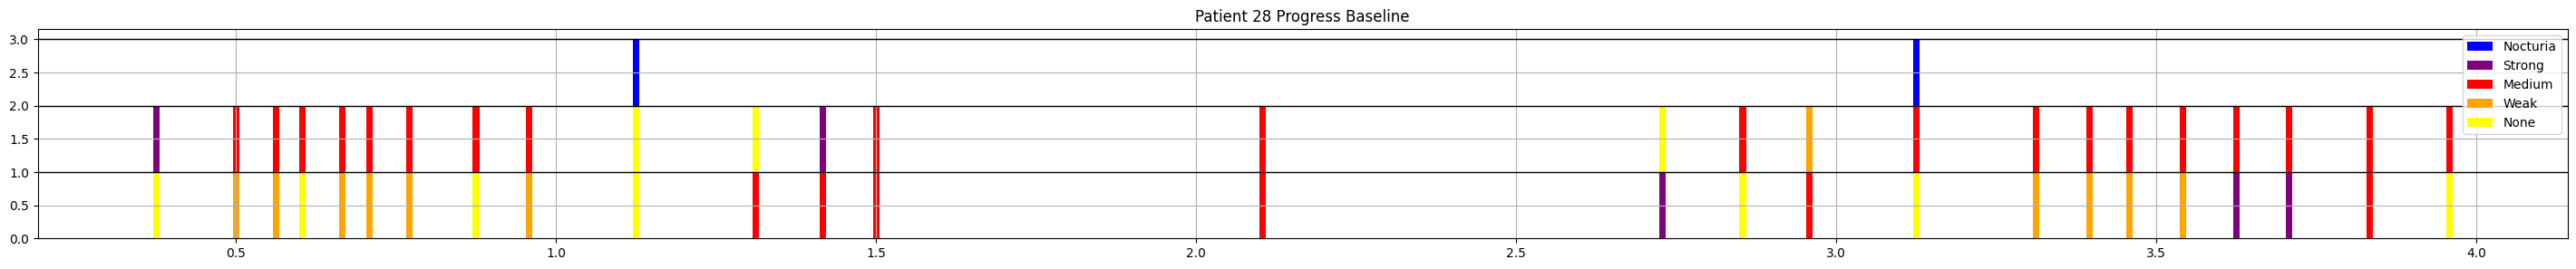

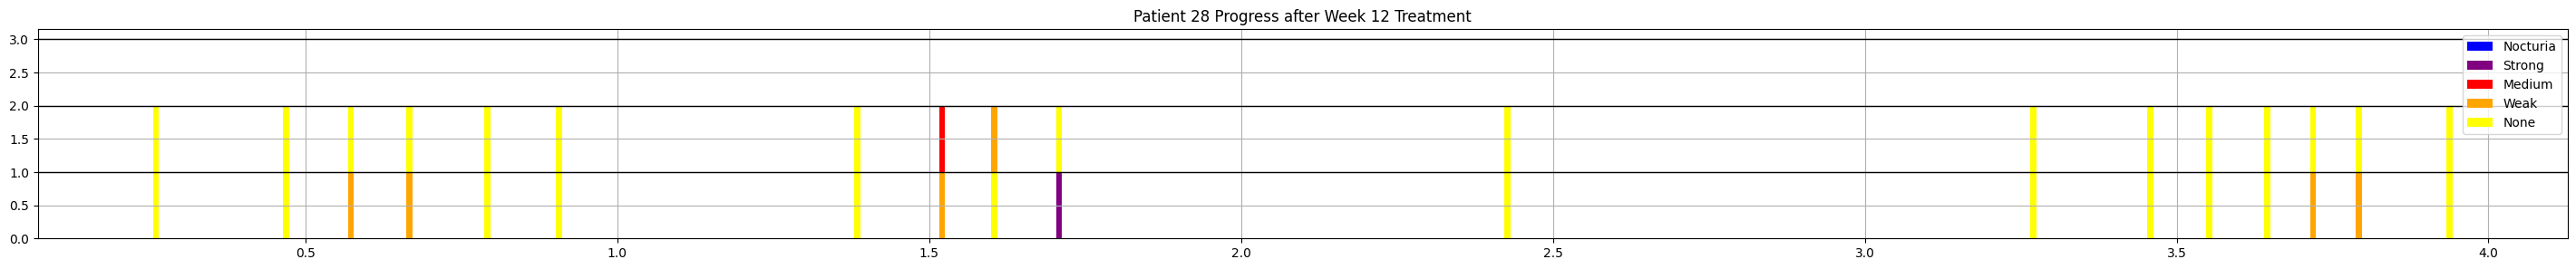

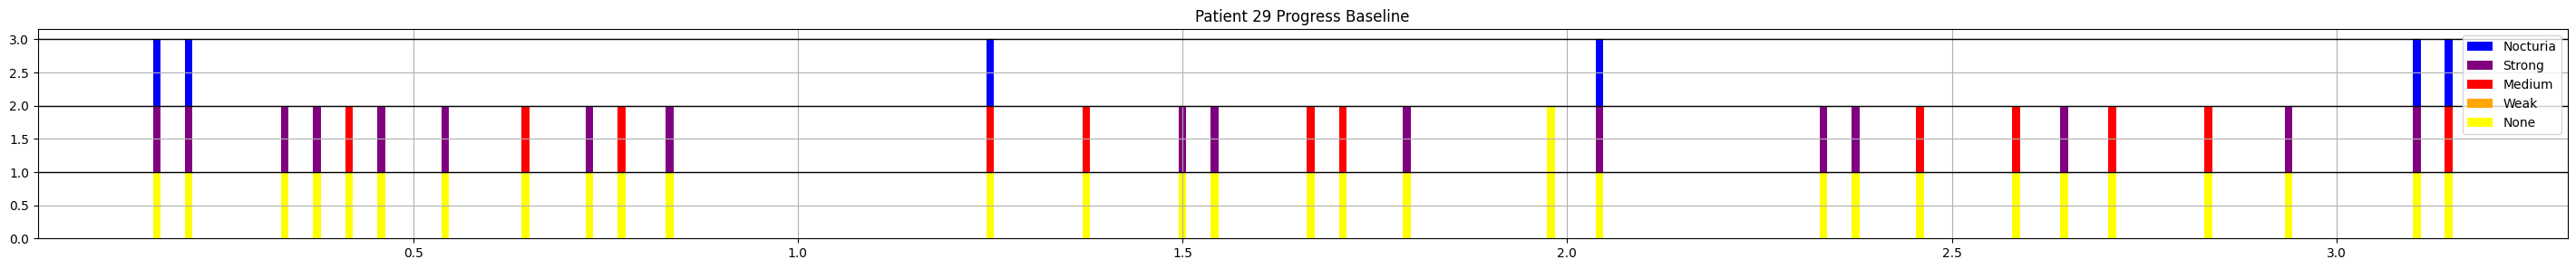

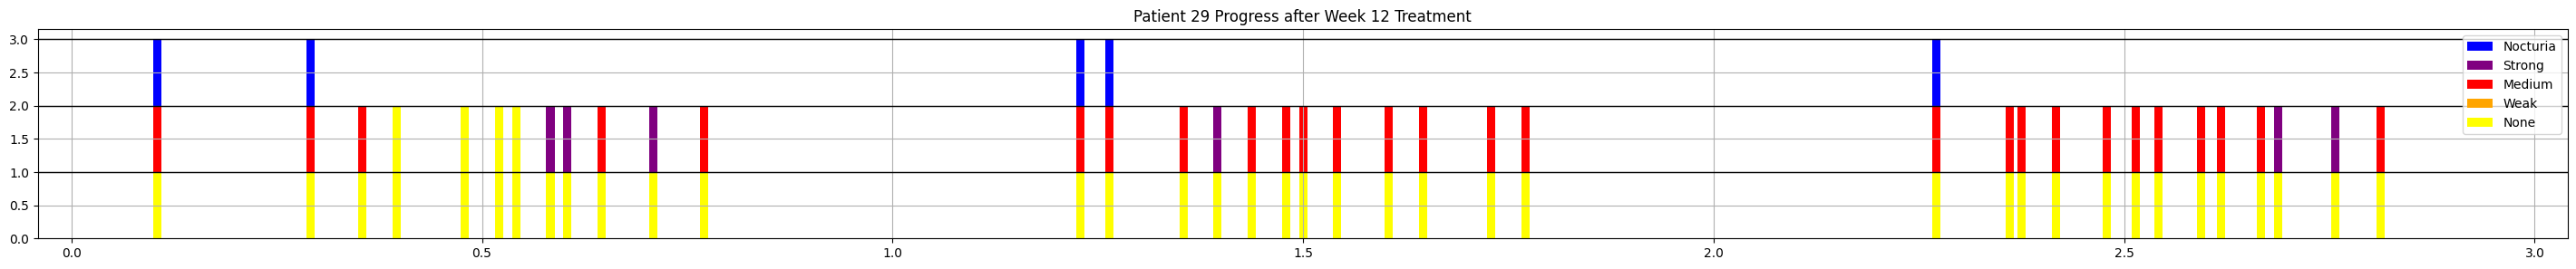

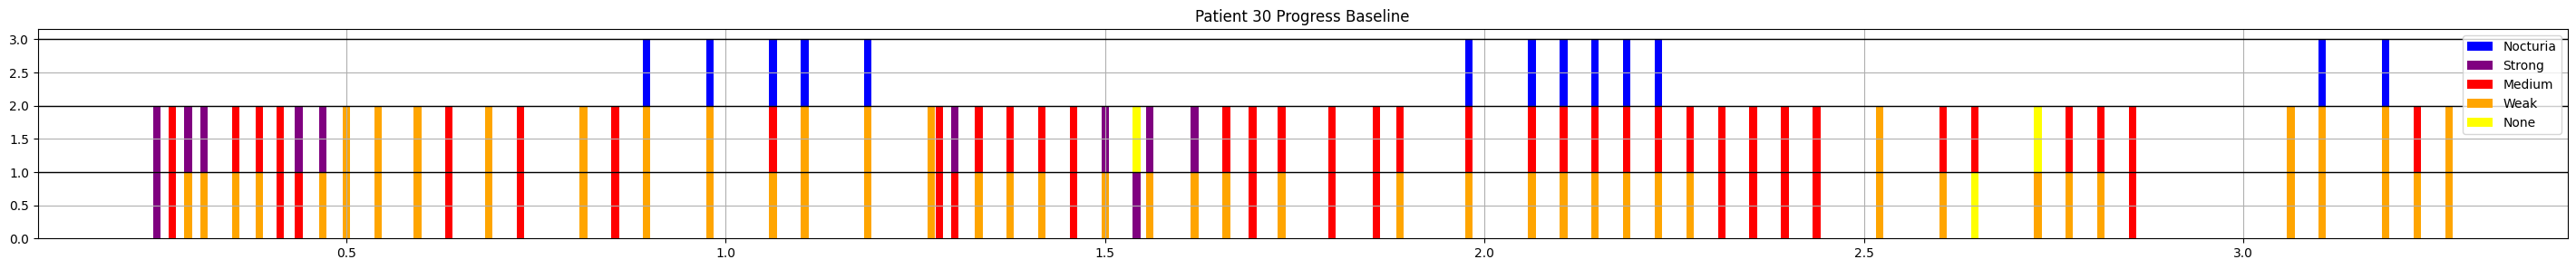

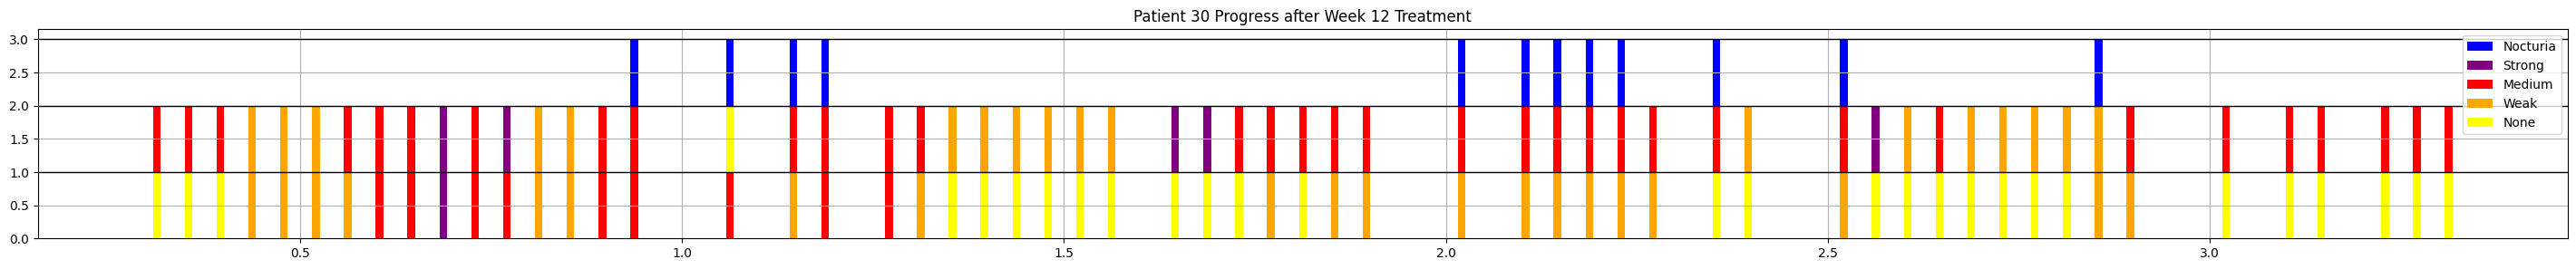

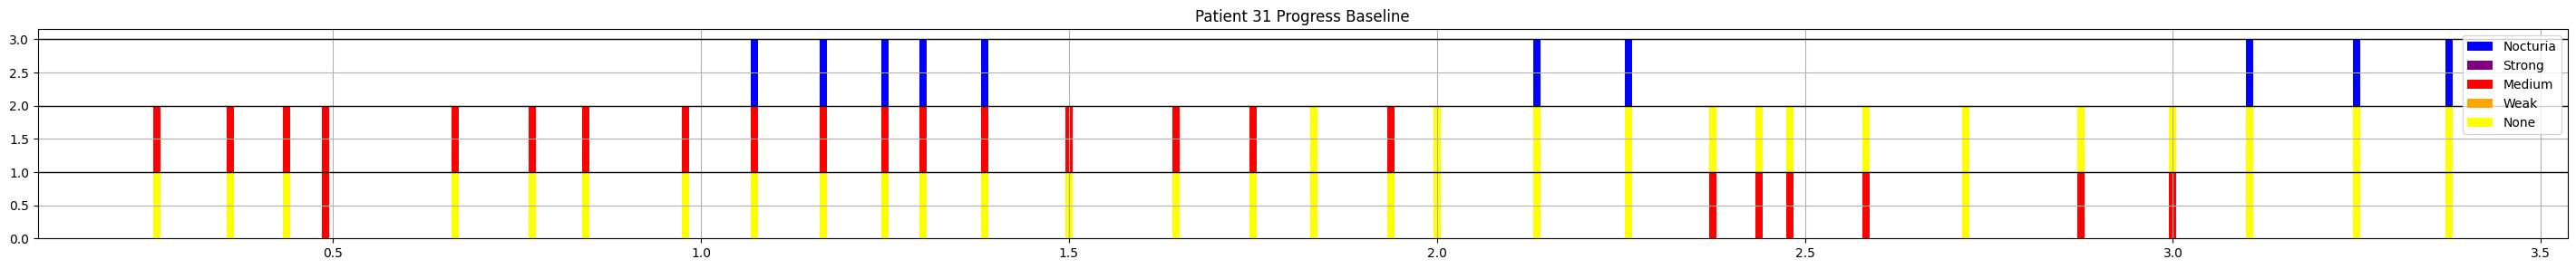

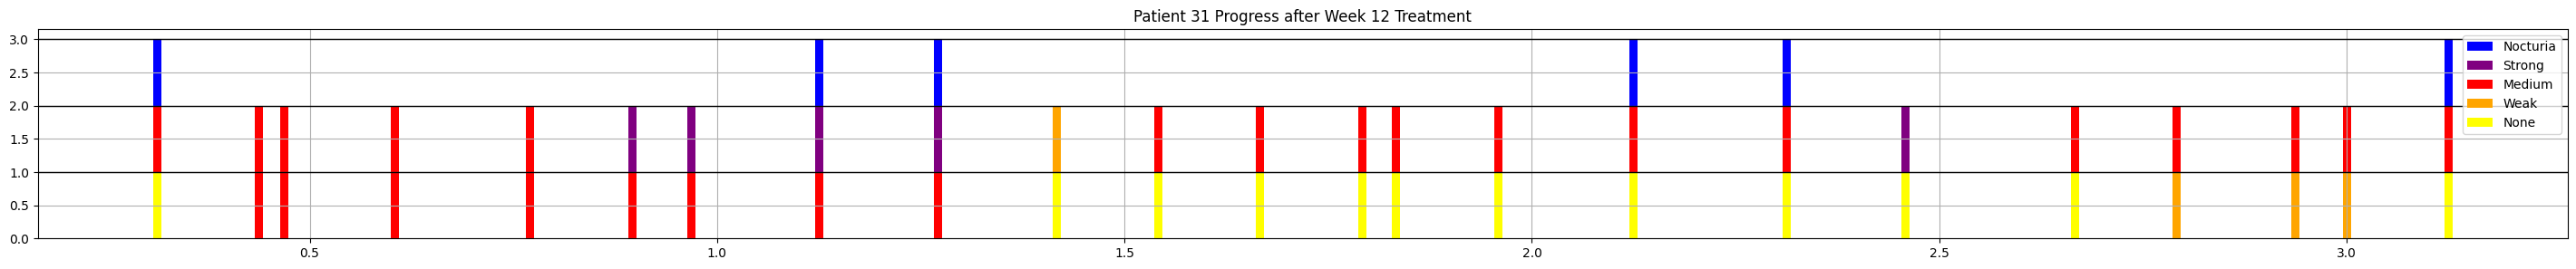

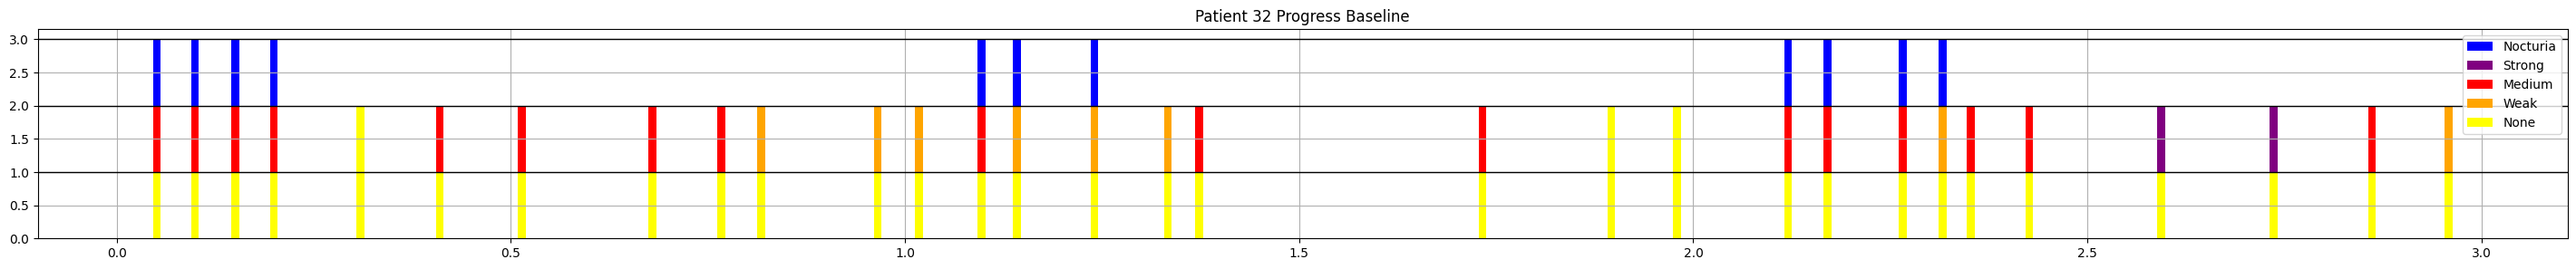

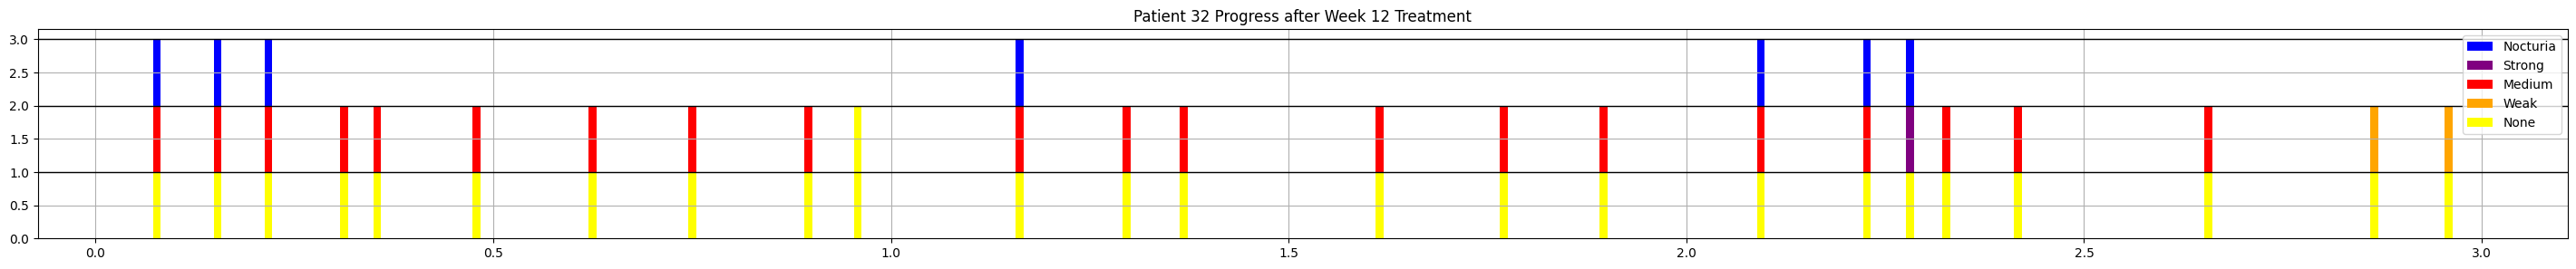

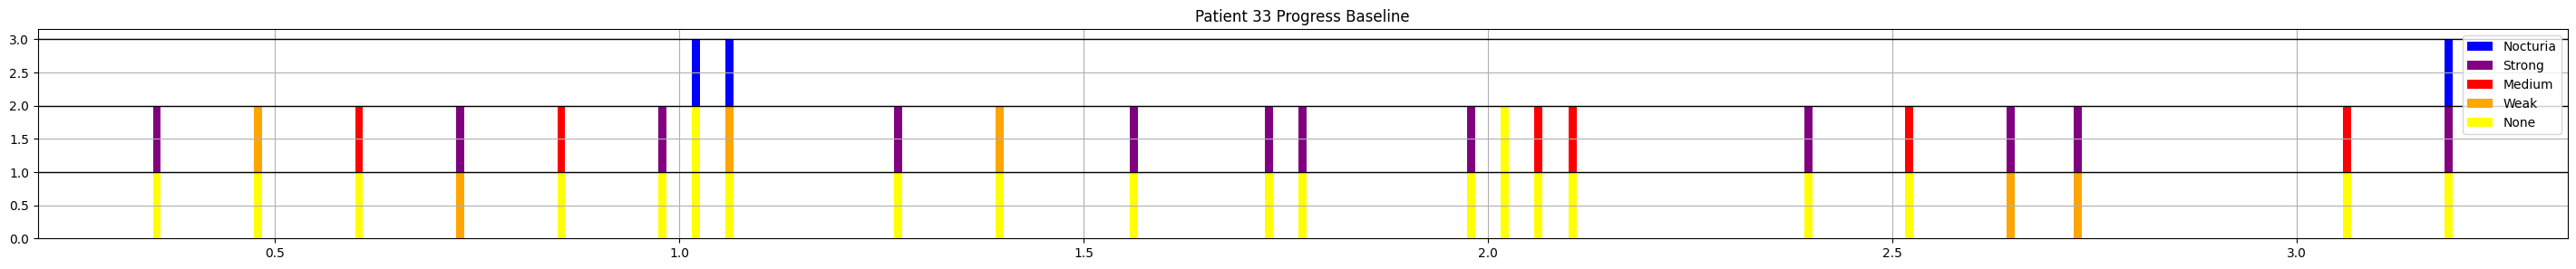

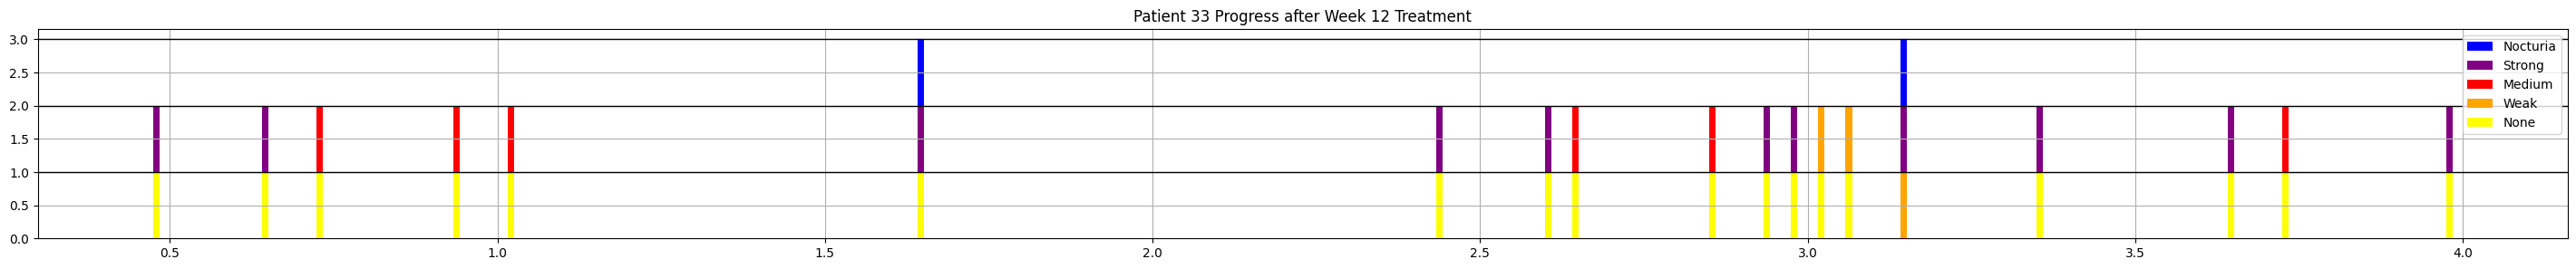

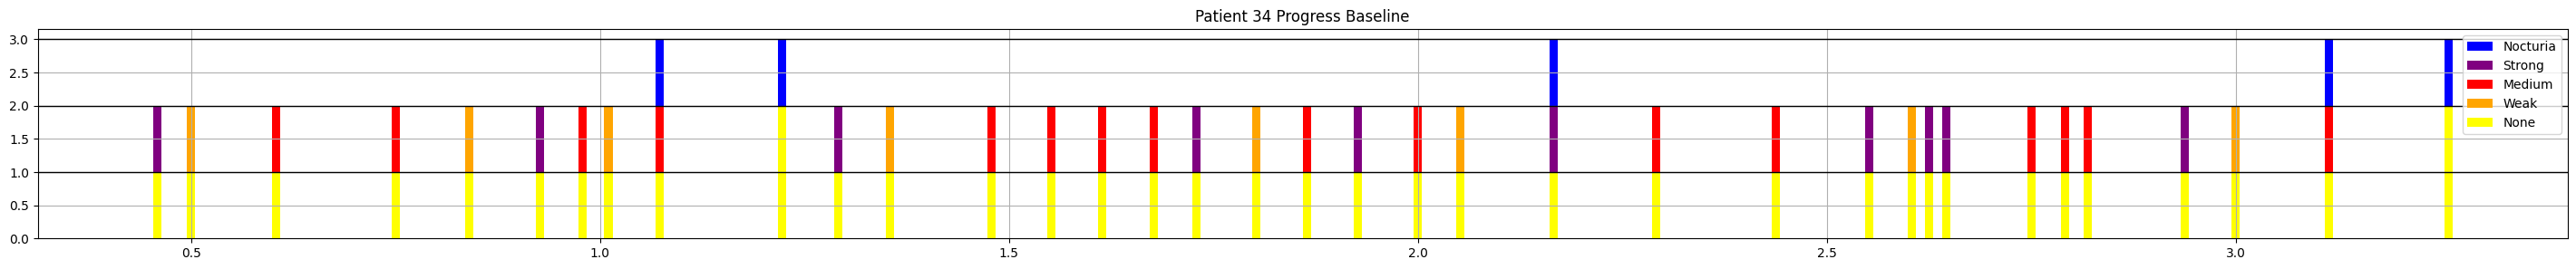

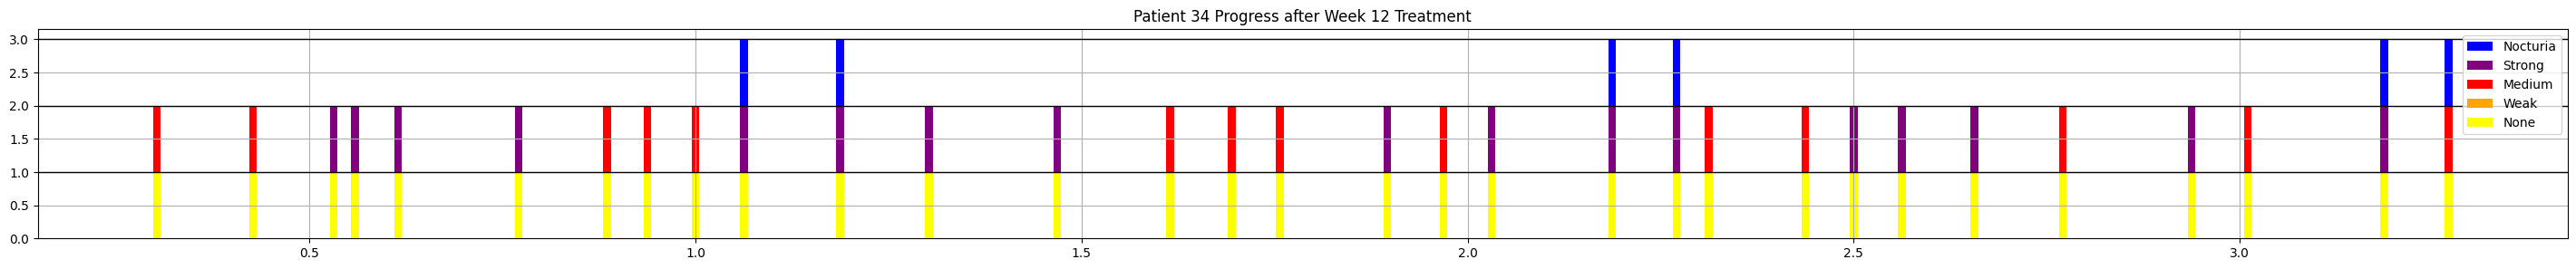

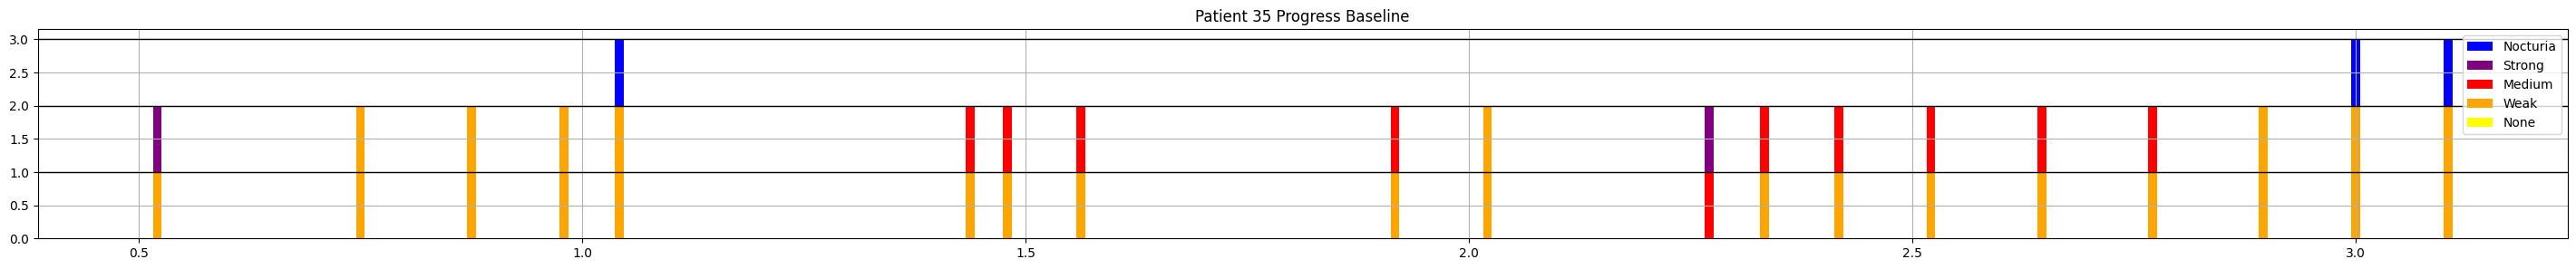

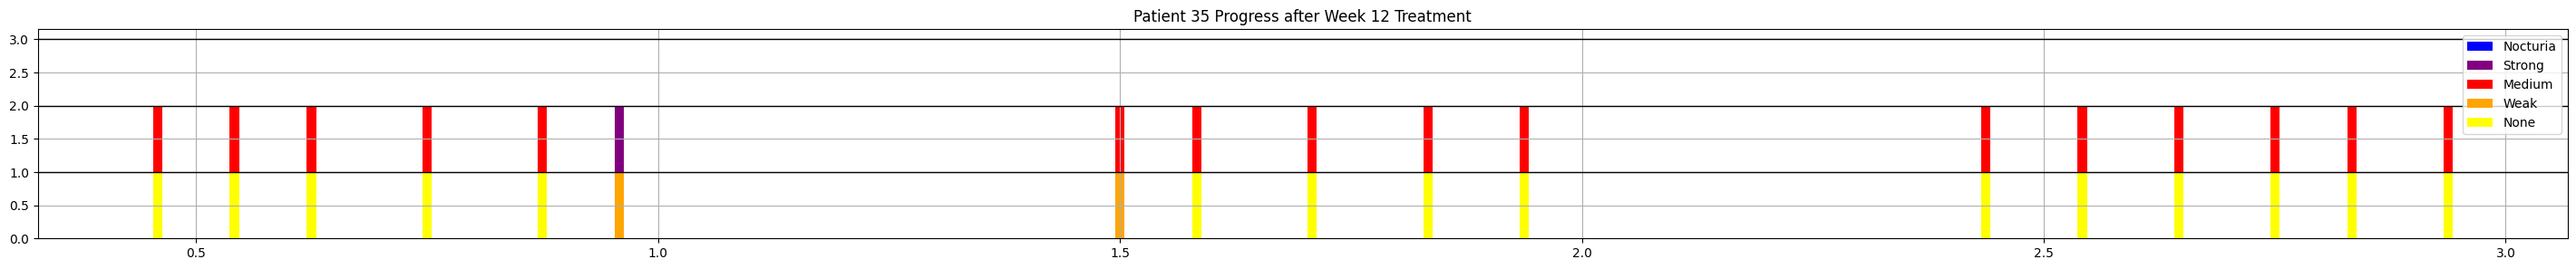

In [ ]:
for i in range(1, 36):
  draw_graph_stack(stacked_participant_baseline[i-1][0], stacked_participant_baseline[i-1][[1, 2, 3]], 0, i)
  draw_graph_stack(stacked_participant_week12[i-1][0], stacked_participant_week12[i-1][[1, 2, 3]], 1, i)

##Models

In [ ]:
trips_label = label_numbers(trips_percentage_change_per_day, np.average(trips_percentage_change_per_day))
nocturia_label = label_numbers(nocturia_percentage_change_per_day, np.average(nocturia_percentage_change_per_day))
accLeak_label = label_numbers(weighted_accLeaks_percentage_change_per_day, np.average(weighted_accLeaks_percentage_change_per_day))
urges_label = label_numbers(weighted_urges_percentage_change_per_day, np.average(weighted_urges_percentage_change_per_day))

def average_position(arrays):
    averages = []
    length = len(arrays[0])
    for i in range(length):
        avg = sum(arr[i] for arr in arrays) / len(arrays)
        if avg > 0.5:
            label = 1
        else:
            label = 0
        averages.append(label)
    return averages

averages = average_position([trips_label, nocturia_label, accLeak_label, urges_label])

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data_baseline, labels):

        self.data_baseline = data_baseline
        self.labels = labels

    def __len__(self):
        return len(self.data_baseline)

    def __getitem__(self, idx):
        sample_baseline = self.data_baseline[idx]
        label = self.labels[idx]
        return torch.tensor(sample_baseline, dtype=torch.float).clone().detach(), torch.tensor(label, dtype=torch.long).clone().detach()

# def pad(x, length=None):
#   return pad_sequences(x, maxlen=length, padding='post')

# def collate_fn(batch):
#     baseline_data, labels = zip(*batch)

#     baseline_data = torch.stack(baseline_data)
#     labels = torch.tensor(labels, dtype=torch.long)

#     return baseline_data, labels

In [ ]:
from torch.nn.utils.rnn import pad_sequence

def pad_and_truncate(sequences, max_seq_length, padding_value=0):
    truncated = [s[:max_seq_length] for s in sequences]
    padded = pad_sequence(truncated, batch_first=True, padding_value=padding_value)
    return padded

max_seq_length = 20

def collate_fn(batch):
    data_list, label_list = zip(*batch)

    padded_data = pad_and_truncate(data_list, max_seq_length)
    data_tensors = [torch.tensor(sequence[1:]) for sequence in padded_data]

    data_stacked = torch.stack(data_tensors)
    data_normalized = data_stacked / 255.0
    labels = torch.tensor(label_list, dtype=torch.long)

    return data_normalized, labels

In [ ]:
rnn_stacked_participant_baseline = [sequence[1:] for sequence in stacked_participant_baseline]
rnn_stacked_participant_week12 = [sequence[1:] for sequence in stacked_participant_week12]

In [ ]:
t_stacked_participant_baseline = [torch.tensor(s, dtype=torch.float).t() for s in rnn_stacked_participant_baseline]
#stacked_participant_baseline_padded = pad_sequence(t_stacked_participant_baseline, batch_first=True, padding_value=0)
t_stacked_participant_week12 = [torch.tensor(s, dtype=torch.float).t() for s in rnn_stacked_participant_week12]
#stacked_participant_week12_padded = pad_sequence(t_stacked_participant_week12, batch_first=True, padding_value=0)

baseline_train, baseline_test, week12_train, week12_test, labels_train, labels_test = train_test_split(t_stacked_participant_baseline, t_stacked_participant_week12, averages, test_size=0.2, random_state=42)

# week12_train = pad(week12_train, baseline_train.shape[1])
# week12_train = [torch.tensor(s, dtype=torch.float) for s in week12_train]
# week12_test = pad(week12_test, baseline_test.shape[1])
# week12_test = [torch.tensor(s, dtype=torch.float) for s in week12_test]

#train_dataset = MyDataset(baseline_train, week12_train, labels_train)
#test_dataset = MyDataset(baseline_test, week12_test, labels_test)
train_dataset = MyDataset(baseline_train, labels_train)
test_dataset = MyDataset(baseline_test, labels_test)

train_loader = DataLoader(train_dataset, batch_size=28, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=7, collate_fn=collate_fn)

In [ ]:
class VanillaRNN(nn.Module):
    def __init__(self):
        super(VanillaRNN, self).__init__()
        self.h_size = 150
        self.x_size = 3
        self.y_size = 2

        self.RecUnit = nn.RNN(self.x_size, self.h_size, batch_first=True)
        self.output_layer = nn.Linear(self.h_size, self.y_size)

    def initial_state(self):
        return torch.zeros(1, batch_size, self.h_size)

    def forward(self, x):

        h_0 = self.initial_state().to(x.device)

        y, hn = self.RecUnit(x, h_0)

        y = self.output_layer(y[:, -1, :])

        return y

In [ ]:
def accuracy(z_out, labels):
    _, predicted = torch.max(z_out, 1)
    correct_pred = (predicted == labels).sum().item()
    accuracy = 100.0 * correct_pred / labels.size(0)
    return accuracy

In [ ]:
def train(model, loss_function, num_epochs):
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    for epoch in range(num_epochs):
        train_loss = 0.0
        train_accuracy = 0.0

        # training loop
        model.train()
        for i, (inputs, labels) in enumerate(train_loader):
            # reset initial states
            labels_transformed = labels
            # reshape input
            optimizer.zero_grad()
            # forward pass
            outputs = model(inputs)
            # compute loss
            loss = loss_function(outputs, labels_transformed)

            if torch.isnan(loss):
              print("Nan in loss occurred")
              print("Outputs:", outputs)
              print("Labels:", labels_transformed)
            # backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            # update training loss and accuracy
            train_loss += loss.item()
            train_accuracy += accuracy(outputs, labels_transformed)
            #print(f"Epoch {epoch + 1}, Batch {i + 1}:")
            #print("Outputs shape:", outputs.shape)
            #print("Labels shape:", labels_transformed.shape)
            #print("Outputs:", outputs)
            #print("Labels:", labels_transformed)

        train_loss /= len(train_loader)
        train_accuracy /= len(train_loader)
        print(f'Epoch {epoch+1} | Loss: {train_loss:.4f} | Accuracy: {train_accuracy:.2f}%')
        print('Epoch:%d|Loss:%.4f|Accuracy:%.2f'%(epoch+1, train_loss, train_accuracy))
    return model

In [ ]:
batch_size = 28
loss_function = nn.CrossEntropyLoss()
n_epochs = 100
basic_model = VanillaRNN()
basic_model = train(basic_model, loss_function, n_epochs)

<ipython-input-50-0085551f2443>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sample_baseline, dtype=torch.float).clone().detach(), torch.tensor(label, dtype=torch.long).clone().detach()
<ipython-input-51-ff9b765b7855>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_tensors = [torch.tensor(sequence[1:]) for sequence in padded_data]


Epoch:1|Loss:0.6946|Accuracy:39.29
Epoch:2|Loss:0.6932|Accuracy:39.29
Epoch:3|Loss:0.6919|Accuracy:60.71
Epoch:4|Loss:0.6905|Accuracy:60.71
Epoch:5|Loss:0.6893|Accuracy:60.71
Epoch:6|Loss:0.6880|Accuracy:60.71
Epoch:7|Loss:0.6869|Accuracy:60.71
Epoch:8|Loss:0.6857|Accuracy:60.71
Epoch:9|Loss:0.6847|Accuracy:60.71
Epoch:10|Loss:0.6836|Accuracy:60.71
Epoch:11|Loss:0.6826|Accuracy:60.71
Epoch:12|Loss:0.6816|Accuracy:60.71
Epoch:13|Loss:0.6807|Accuracy:60.71
Epoch:14|Loss:0.6798|Accuracy:60.71
Epoch:15|Loss:0.6790|Accuracy:60.71
Epoch:16|Loss:0.6781|Accuracy:60.71
Epoch:17|Loss:0.6773|Accuracy:60.71
Epoch:18|Loss:0.6766|Accuracy:60.71
Epoch:19|Loss:0.6759|Accuracy:60.71
Epoch:20|Loss:0.6752|Accuracy:60.71
Epoch:21|Loss:0.6745|Accuracy:60.71
Epoch:22|Loss:0.6739|Accuracy:60.71
Epoch:23|Loss:0.6733|Accuracy:60.71
Epoch:24|Loss:0.6728|Accuracy:60.71
Epoch:25|Loss:0.6723|Accuracy:60.71
Epoch:26|Loss:0.6718|Accuracy:60.71
Epoch:27|Loss:0.6714|Accuracy:60.71
Epoch:28|Loss:0.6711|Accuracy:60.71
E

In [ ]:
basic_model.eval()
batch_size = 7

def test(model):
  predictions = []
  model.eval()
  labels = [x + 1 for x in labels_test]
  with torch.no_grad():
      for inputs, _ in test_loader:
          outputs = model(inputs)
          print(outputs)
          _, predicted = torch.max(outputs, 1)

          predictions.extend(predicted.tolist())
  labels = torch.tensor(labels)
  predictions = torch.tensor(predictions)
  correct_pred = (predictions == labels).sum().item()
  acc = 100.0 * correct_pred / labels.size(0)
  print("Accuracy:", acc)
  print("Predictions:", predictions)
  print("Actual Labels:", labels)

test(basic_model)

tensor([[ 0.1897, -0.2460],
        [ 0.1892, -0.2450],
        [ 0.1892, -0.2450],
        [ 0.1893, -0.2457],
        [ 0.1893, -0.2453],
        [ 0.1893, -0.2453],
        [ 0.1895, -0.2456]])
Accuracy: 0.0
Predictions: tensor([0, 0, 0, 0, 0, 0, 0])
Actual Labels: tensor([2, 1, 1, 1, 2, 1, 1])


<ipython-input-50-0085551f2443>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sample_baseline, dtype=torch.float).clone().detach(), torch.tensor(label, dtype=torch.long).clone().detach()
<ipython-input-51-ff9b765b7855>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_tensors = [torch.tensor(sequence[1:]) for sequence in padded_data]


In [ ]:
class GRURNN(nn.Module):
    def __init__(self):
        super(GRURNN, self).__init__()
        self.h_size = 150
        self.x_size = 3
        self.y_size = 2

        self.RecUnit = nn.GRU(self.x_size, self.h_size, batch_first=True)
        self.output_layer = nn.Linear(self.h_size, self.y_size)

    def initial_state(self):
        return torch.zeros(1, batch_size, self.h_size)

    def forward(self, x):
        h_0 = self.initial_state().to(x.device)


        y, hn = self.RecUnit(x, h_0)

        y = self.output_layer(y[:, -1, :])

        return y

In [ ]:
batch_size = 28
loss_function = nn.CrossEntropyLoss()
n_epochs = 100
gru_model = GRURNN()
gru_model = train(gru_model, loss_function, n_epochs)

<ipython-input-50-0085551f2443>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sample_baseline, dtype=torch.float).clone().detach(), torch.tensor(label, dtype=torch.long).clone().detach()
<ipython-input-51-ff9b765b7855>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_tensors = [torch.tensor(sequence[1:]) for sequence in padded_data]


Epoch:1|Loss:0.6891|Accuracy:60.71
Epoch:2|Loss:0.6885|Accuracy:60.71
Epoch:3|Loss:0.6879|Accuracy:60.71
Epoch:4|Loss:0.6873|Accuracy:60.71
Epoch:5|Loss:0.6868|Accuracy:60.71
Epoch:6|Loss:0.6862|Accuracy:60.71
Epoch:7|Loss:0.6856|Accuracy:60.71
Epoch:8|Loss:0.6851|Accuracy:60.71
Epoch:9|Loss:0.6845|Accuracy:60.71
Epoch:10|Loss:0.6840|Accuracy:60.71
Epoch:11|Loss:0.6835|Accuracy:60.71
Epoch:12|Loss:0.6830|Accuracy:60.71
Epoch:13|Loss:0.6825|Accuracy:60.71
Epoch:14|Loss:0.6820|Accuracy:60.71
Epoch:15|Loss:0.6815|Accuracy:60.71
Epoch:16|Loss:0.6811|Accuracy:60.71
Epoch:17|Loss:0.6806|Accuracy:60.71
Epoch:18|Loss:0.6801|Accuracy:60.71
Epoch:19|Loss:0.6797|Accuracy:60.71
Epoch:20|Loss:0.6793|Accuracy:60.71
Epoch:21|Loss:0.6788|Accuracy:60.71
Epoch:22|Loss:0.6784|Accuracy:60.71
Epoch:23|Loss:0.6780|Accuracy:60.71
Epoch:24|Loss:0.6776|Accuracy:60.71
Epoch:25|Loss:0.6773|Accuracy:60.71
Epoch:26|Loss:0.6769|Accuracy:60.71
Epoch:27|Loss:0.6765|Accuracy:60.71
Epoch:28|Loss:0.6762|Accuracy:60.71
E

In [ ]:
batch_size = 7
test(gru_model)

tensor([[ 0.2177, -0.2191],
        [ 0.2175, -0.2183],
        [ 0.2174, -0.2182],
        [ 0.2175, -0.2187],
        [ 0.2177, -0.2189],
        [ 0.2176, -0.2188],
        [ 0.2177, -0.2189]])
Accuracy: 0.0
Predictions: tensor([0, 0, 0, 0, 0, 0, 0])
Actual Labels: tensor([2, 1, 1, 1, 2, 1, 1])


<ipython-input-50-0085551f2443>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sample_baseline, dtype=torch.float).clone().detach(), torch.tensor(label, dtype=torch.long).clone().detach()
<ipython-input-51-ff9b765b7855>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_tensors = [torch.tensor(sequence[1:]) for sequence in padded_data]


In [ ]:
class LSTMRNN(nn.Module):
    def __init__(self):
        super(LSTMRNN, self).__init__()
        self.h_size = 150
        self.x_size = 3
        self.y_size = 2

        self.RecUnit = nn.LSTM(self.x_size, self.h_size, batch_first=True)
        self.output_layer = nn.Linear(self.h_size, self.y_size)

    def initial_state(self):
        h_0 = torch.zeros(1, batch_size, self.h_size)
        c_0 = torch.zeros(1, batch_size, self.h_size)
        return h_0, c_0

    def forward(self, x):
        h_0, c_0 = self.initial_state()
        h_0 = h_0.to(x.device)
        c_0 = c_0.to(x.device)

        y, (h_n, c_n) = self.RecUnit(x, (h_0, c_0))

        y = self.output_layer(y[:, -1, :])

        return y

In [ ]:
batch_size = 28
loss_function = nn.CrossEntropyLoss()
n_epochs = 100
lstm_model = LSTMRNN()
lstm_model = train(lstm_model, loss_function, n_epochs)

<ipython-input-50-0085551f2443>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sample_baseline, dtype=torch.float).clone().detach(), torch.tensor(label, dtype=torch.long).clone().detach()
<ipython-input-51-ff9b765b7855>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_tensors = [torch.tensor(sequence[1:]) for sequence in padded_data]


Epoch:1|Loss:0.6900|Accuracy:60.71
Epoch:2|Loss:0.6896|Accuracy:60.71
Epoch:3|Loss:0.6892|Accuracy:60.71
Epoch:4|Loss:0.6888|Accuracy:60.71
Epoch:5|Loss:0.6883|Accuracy:60.71
Epoch:6|Loss:0.6879|Accuracy:60.71
Epoch:7|Loss:0.6875|Accuracy:60.71
Epoch:8|Loss:0.6871|Accuracy:60.71
Epoch:9|Loss:0.6867|Accuracy:60.71
Epoch:10|Loss:0.6864|Accuracy:60.71
Epoch:11|Loss:0.6860|Accuracy:60.71
Epoch:12|Loss:0.6856|Accuracy:60.71
Epoch:13|Loss:0.6852|Accuracy:60.71
Epoch:14|Loss:0.6848|Accuracy:60.71
Epoch:15|Loss:0.6845|Accuracy:60.71
Epoch:16|Loss:0.6841|Accuracy:60.71
Epoch:17|Loss:0.6838|Accuracy:60.71
Epoch:18|Loss:0.6834|Accuracy:60.71
Epoch:19|Loss:0.6830|Accuracy:60.71
Epoch:20|Loss:0.6827|Accuracy:60.71
Epoch:21|Loss:0.6824|Accuracy:60.71
Epoch:22|Loss:0.6820|Accuracy:60.71
Epoch:23|Loss:0.6817|Accuracy:60.71
Epoch:24|Loss:0.6813|Accuracy:60.71
Epoch:25|Loss:0.6810|Accuracy:60.71
Epoch:26|Loss:0.6807|Accuracy:60.71
Epoch:27|Loss:0.6803|Accuracy:60.71
Epoch:28|Loss:0.6800|Accuracy:60.71
E

In [ ]:
batch_size = 7
test(lstm_model)

tensor([[ 0.1277, -0.3047],
        [ 0.1277, -0.3044],
        [ 0.1277, -0.3044],
        [ 0.1276, -0.3044],
        [ 0.1277, -0.3046],
        [ 0.1276, -0.3045],
        [ 0.1277, -0.3046]])
Accuracy: 0.0
Predictions: tensor([0, 0, 0, 0, 0, 0, 0])
Actual Labels: tensor([2, 1, 1, 1, 2, 1, 1])


<ipython-input-50-0085551f2443>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sample_baseline, dtype=torch.float).clone().detach(), torch.tensor(label, dtype=torch.long).clone().detach()
<ipython-input-51-ff9b765b7855>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_tensors = [torch.tensor(sequence[1:]) for sequence in padded_data]


#Data Generation

In [ ]:
# Helpers
def extend_list(lst1, lst2):
  for i in range(len(lst1)):
    lst1[i].extend(lst2[i])
  return lst1

def get_one_day_trips(data, idx):
  return [data[0][i][idx].shape[0] for i in range(len(data[0]))]

def get_number_of_trips_in_three_days(data):
  return [get_one_day_trips(data, i) for i in range(3)]

def generate_frequency_based_categorical(num_samples, data):
    unique, counts = np.unique(data, return_counts=True)
    probabilities = counts / counts.sum()
    #print(f"Unique: {unique}, Counts: {counts}, Probabilities: {probabilities}")

    return np.random.choice(unique, num_samples, p=probabilities)

def get_col(data, col_idx):
  col_lst = [data[0][i][k][m][col_idx] for i in range(len(data[0])) for k in range(len(data[0][i])) for m in range(len(data[0][i][k]))]
  return col_lst

def is_night(time_lst):
  return [1 if (0 < itm < 0.25) or (1 < itm < 1.25) else 0 for itm in time_lst]

In [ ]:
from functools import partial


# Datasets
baselines = [participant_baseline_data_A, participant_baseline_data_B]
twleve_weeks = [participant_12_weeks_data_A, participant_12_weeks_data_B]

def generate_daily_num_of_trips(data):
  day1_trips = generate_frequency_based_categorical(1, data[0])[0]
  day2_trips = generate_frequency_based_categorical(1, data[1])[0]
  day3_trips = generate_frequency_based_categorical(1, data[2])[0]
  return day1_trips, day2_trips, day3_trips

def generate_one_paitient(which_dataset):
  partial_get_cols = list(map(lambda dataset: partial(get_col, dataset), which_dataset))

  col_stacks = [[] for _ in range(6)]
  for partial_get_col in partial_get_cols:
    col_stacks = extend_list(col_stacks, list(map(partial_get_col, range(6))))

  tep = extend_list(get_number_of_trips_in_three_days(which_dataset[0]), get_number_of_trips_in_three_days(which_dataset[1]))
  day1_num_of_trips, day2_num_of_trips, day3_num_of_trips = generate_daily_num_of_trips(tep)

  day1_2_3_time_lsts = list(map(sorted, list(map(lambda x: generate_frequency_based_categorical(x, col_stacks[0]), [day1_num_of_trips, day2_num_of_trips, day3_num_of_trips]))))

  col_stacks_except_time_and_night_day1 = list(map(lambda x: generate_frequency_based_categorical(day1_num_of_trips, x), col_stacks[1:5]))
  col_stacks_except_time_and_night_day2 = list(map(lambda x: generate_frequency_based_categorical(day2_num_of_trips, x), col_stacks[1:5]))
  col_stacks_except_time_and_night_day3 = list(map(lambda x: generate_frequency_based_categorical(day3_num_of_trips, x), col_stacks[1:5]))
  col_stacks_except_time_and_night = [col_stacks_except_time_and_night_day1, col_stacks_except_time_and_night_day2, col_stacks_except_time_and_night_day3]

  is_nights = list(map(is_night, day1_2_3_time_lsts))
  col_stacks_generated_data = []
  for i in range(len(day1_2_3_time_lsts)):
    lst = [day1_2_3_time_lsts[i]] +  col_stacks_except_time_and_night[i] + [is_nights[i]]
    col_stack_one_day = np.column_stack(lst)
    col_stacks_generated_data.append(col_stack_one_day)



  #print(col_stacks_generated_data)
  return col_stacks_generated_data

n = 1000 # Generate 1000 patients, 3 days data each

baseline_gen_data = [generate_one_paitient(baselines) for _ in range(n)]
twleve_weeks_gen_data = [generate_one_paitient(twleve_weeks) for _ in range(n)]

In [ ]:
import tensorflow as tf

def select_and_transpose_columns(data, columns_to_remove):
    processed_data = []

    for inner_list in data:
        processed_inner_list = []
        for array in inner_list:
            all_columns = np.arange(array.shape[1])
            columns_to_keep = np.setdiff1d(all_columns, columns_to_remove)
            selected_columns = array[:, columns_to_keep]
            transposed_array = selected_columns.T
            processed_inner_list.append(transposed_array)
        processed_data.append(processed_inner_list)

    return processed_data

columns = [0, 1, 4]

def sum_of_specific_column(data, column_index):

    sums_of_columns = []

    for inner_list in data:
        inner_list_sum = 0
        for array in inner_list:
            inner_list_sum += np.sum(array[:, column_index])
        sums_of_columns.append(inner_list_sum/3)

    return sums_of_columns

baseline_gen_trip_label = sum_of_specific_column(baseline_gen_data, 1)
twleve_weeks_gen_trip_label = sum_of_specific_column(twleve_weeks_gen_data, 1)

baseline_gen_accLeaks_label = sum_of_specific_column(baseline_gen_data, 2)
twleve_weeks_gen_accLeaks_label = sum_of_specific_column(twleve_weeks_gen_data, 2)

baseline_gen_urges_label = sum_of_specific_column(baseline_gen_data, 3)
twleve_weeks_gen_urges_label = sum_of_specific_column(twleve_weeks_gen_data, 3)

baseline_gen_nocturia_label = sum_of_specific_column(baseline_gen_data, 5)
twleve_weeks_gen_nocturia_label = sum_of_specific_column(twleve_weeks_gen_data, 5)

gen_trips_percentage_change_per_day = [(-(twelve - baseline) / baseline * 100 if baseline != 0 else 0) for twelve, baseline in zip(twleve_weeks_gen_trip_label, baseline_gen_trip_label)]
gen_accLeaks_percentage_change_per_day = [(-(twelve - baseline) / baseline * 100 if baseline != 0 else 0) for twelve, baseline in zip(twleve_weeks_gen_accLeaks_label, baseline_gen_accLeaks_label)]
gen_urges_percentage_change_per_day = [(-(twelve - baseline) / baseline * 100 if baseline != 0 else 0) for twelve, baseline in zip(twleve_weeks_gen_urges_label, baseline_gen_urges_label)]
gen_nocturia_percentage_change_per_day = [(-(twelve - baseline) / baseline * 100 if baseline != 0 else 0) for twelve, baseline in zip(twleve_weeks_gen_nocturia_label, baseline_gen_nocturia_label)]

trips_label = label_numbers(gen_trips_percentage_change_per_day, np.average(gen_trips_percentage_change_per_day))
accLeak_label = label_numbers(gen_accLeaks_percentage_change_per_day, np.average(gen_accLeaks_percentage_change_per_day))
urges_label = label_numbers(gen_urges_percentage_change_per_day, np.average(gen_urges_percentage_change_per_day))
nocturia_label = label_numbers(gen_nocturia_percentage_change_per_day, np.average(gen_nocturia_percentage_change_per_day))

labels = average_position([trips_label, nocturia_label, accLeak_label, urges_label]) #prepared label for train
baseline_gen_data_for_train = select_and_transpose_columns(baseline_gen_data, columns) #prepared data for train
twleve_weeks_gen_data_for_train = select_and_transpose_columns(twleve_weeks_gen_data, columns) #prepared data for train

In [ ]:
t_baseline_gen_data_for_train = [np.concatenate(sublist, axis=1) for sublist in baseline_gen_data_for_train]
t_twleve_weeks_gen_data_for_train = [np.concatenate(sublist, axis=1) for sublist in twleve_weeks_gen_data_for_train]

t_stacked_gen_baseline = [torch.tensor(s, dtype=torch.float).t() for s in t_baseline_gen_data_for_train]
#baseline_gen_data_for_train_padded = pad_sequences(baseline_gen_data_for_train)
t_stacked_gen_week12 = [torch.tensor(s, dtype=torch.float).t() for s in t_twleve_weeks_gen_data_for_train]
#twleve_weeks_gen_data_for_train_padded = pad_sequences(twleve_weeks_gen_data_for_train)

baseline_train, baseline_test, week12_train, week12_test, labels_train, labels_test = train_test_split(t_stacked_gen_baseline, t_stacked_gen_week12, labels, test_size=0.1, random_state=42)

train_dataset = MyDataset(baseline_train, labels_train)
test_dataset = MyDataset(t_stacked_participant_baseline, averages)

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=35, collate_fn=collate_fn)

##Data Generation Train

In [ ]:
def test(model):
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            predictions = model(inputs)

            # Ensure labels are in the same device and type as predictions
            labels = labels.to(predictions.device)

            # Print shapes for debugging
            print("Predictions shape:", predictions.shape)
            print("Labels shape:", labels.shape)

            acc = accuracy(predictions, labels)
            print("Accuracy:", acc)

test(basic_model)

Predictions shape: torch.Size([35, 2])
Labels shape: torch.Size([35])
Accuracy: 60.0


<ipython-input-50-0085551f2443>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sample_baseline, dtype=torch.float).clone().detach(), torch.tensor(label, dtype=torch.long).clone().detach()
<ipython-input-57-ff9b765b7855>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_tensors = [torch.tensor(sequence[1:]) for sequence in padded_data]


In [ ]:
test(gru_model)

Predictions shape: torch.Size([35, 2])
Labels shape: torch.Size([35])
Accuracy: 60.0


<ipython-input-50-0085551f2443>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sample_baseline, dtype=torch.float).clone().detach(), torch.tensor(label, dtype=torch.long).clone().detach()
<ipython-input-57-ff9b765b7855>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_tensors = [torch.tensor(sequence[1:]) for sequence in padded_data]


In [ ]:
test(lstm_model)

Predictions shape: torch.Size([35, 2])
Labels shape: torch.Size([35])
Accuracy: 60.0


<ipython-input-50-0085551f2443>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sample_baseline, dtype=torch.float).clone().detach(), torch.tensor(label, dtype=torch.long).clone().detach()
<ipython-input-57-ff9b765b7855>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_tensors = [torch.tensor(sequence[1:]) for sequence in padded_data]


In [ ]:
batch_size = 20
loss_function = nn.CrossEntropyLoss()
n_epochs = 100
basic_model = VanillaRNN()
basic_model = train(basic_model, loss_function, n_epochs)

<ipython-input-50-0085551f2443>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sample_baseline, dtype=torch.float).clone().detach(), torch.tensor(label, dtype=torch.long).clone().detach()
<ipython-input-57-ff9b765b7855>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_tensors = [torch.tensor(sequence[1:]) for sequence in padded_data]


Epoch 1 | Loss: 0.6920 | Accuracy: 52.88%
Epoch:1|Loss:0.6920|Accuracy:52.88
Epoch 2 | Loss: 0.6918 | Accuracy: 52.88%
Epoch:2|Loss:0.6918|Accuracy:52.88
Epoch 3 | Loss: 0.6919 | Accuracy: 52.88%
Epoch:3|Loss:0.6919|Accuracy:52.88
Epoch 4 | Loss: 0.6918 | Accuracy: 52.88%
Epoch:4|Loss:0.6918|Accuracy:52.88
Epoch 5 | Loss: 0.6918 | Accuracy: 52.88%
Epoch:5|Loss:0.6918|Accuracy:52.88
Epoch 6 | Loss: 0.6919 | Accuracy: 52.88%
Epoch:6|Loss:0.6919|Accuracy:52.88
Epoch 7 | Loss: 0.6921 | Accuracy: 52.88%
Epoch:7|Loss:0.6921|Accuracy:52.88
Epoch 8 | Loss: 0.6918 | Accuracy: 52.88%
Epoch:8|Loss:0.6918|Accuracy:52.88
Epoch 9 | Loss: 0.6917 | Accuracy: 52.88%
Epoch:9|Loss:0.6917|Accuracy:52.88
Epoch 10 | Loss: 0.6916 | Accuracy: 52.88%
Epoch:10|Loss:0.6916|Accuracy:52.88
Epoch 11 | Loss: 0.6916 | Accuracy: 52.88%
Epoch:11|Loss:0.6916|Accuracy:52.88
Epoch 12 | Loss: 0.6918 | Accuracy: 52.88%
Epoch:12|Loss:0.6918|Accuracy:52.88
Epoch 13 | Loss: 0.6917 | Accuracy: 52.88%
Epoch:13|Loss:0.6917|Accura

In [ ]:
batch_size = 20
loss_function = nn.CrossEntropyLoss()
n_epochs = 100
gru_model = GRURNN()
gru_model = train(gru_model, loss_function, n_epochs)

<ipython-input-50-0085551f2443>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sample_baseline, dtype=torch.float).clone().detach(), torch.tensor(label, dtype=torch.long).clone().detach()
<ipython-input-57-ff9b765b7855>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_tensors = [torch.tensor(sequence[1:]) for sequence in padded_data]


Epoch 1 | Loss: 0.6944 | Accuracy: 47.75%
Epoch:1|Loss:0.6944|Accuracy:47.75
Epoch 2 | Loss: 0.6925 | Accuracy: 52.88%
Epoch:2|Loss:0.6925|Accuracy:52.88
Epoch 3 | Loss: 0.6918 | Accuracy: 52.88%
Epoch:3|Loss:0.6918|Accuracy:52.88
Epoch 4 | Loss: 0.6921 | Accuracy: 52.88%
Epoch:4|Loss:0.6921|Accuracy:52.88
Epoch 5 | Loss: 0.6916 | Accuracy: 52.88%
Epoch:5|Loss:0.6916|Accuracy:52.88
Epoch 6 | Loss: 0.6921 | Accuracy: 52.88%
Epoch:6|Loss:0.6921|Accuracy:52.88
Epoch 7 | Loss: 0.6918 | Accuracy: 52.88%
Epoch:7|Loss:0.6918|Accuracy:52.88
Epoch 8 | Loss: 0.6916 | Accuracy: 52.88%
Epoch:8|Loss:0.6916|Accuracy:52.88
Epoch 9 | Loss: 0.6916 | Accuracy: 52.88%
Epoch:9|Loss:0.6916|Accuracy:52.88
Epoch 10 | Loss: 0.6917 | Accuracy: 52.88%
Epoch:10|Loss:0.6917|Accuracy:52.88
Epoch 11 | Loss: 0.6918 | Accuracy: 52.88%
Epoch:11|Loss:0.6918|Accuracy:52.88
Epoch 12 | Loss: 0.6916 | Accuracy: 52.88%
Epoch:12|Loss:0.6916|Accuracy:52.88
Epoch 13 | Loss: 0.6916 | Accuracy: 52.88%
Epoch:13|Loss:0.6916|Accura

In [ ]:
batch_size = 20
loss_function = nn.CrossEntropyLoss()
n_epochs = 100
lstm_model = LSTMRNN()
lstm_model = train(lstm_model, loss_function, n_epochs)

<ipython-input-50-0085551f2443>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sample_baseline, dtype=torch.float).clone().detach(), torch.tensor(label, dtype=torch.long).clone().detach()
<ipython-input-57-ff9b765b7855>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_tensors = [torch.tensor(sequence[1:]) for sequence in padded_data]


Epoch 1 | Loss: 0.6919 | Accuracy: 52.88%
Epoch:1|Loss:0.6919|Accuracy:52.88
Epoch 2 | Loss: 0.6916 | Accuracy: 52.88%
Epoch:2|Loss:0.6916|Accuracy:52.88
Epoch 3 | Loss: 0.6915 | Accuracy: 52.88%
Epoch:3|Loss:0.6915|Accuracy:52.88
Epoch 4 | Loss: 0.6917 | Accuracy: 52.88%
Epoch:4|Loss:0.6917|Accuracy:52.88
Epoch 5 | Loss: 0.6916 | Accuracy: 52.88%
Epoch:5|Loss:0.6916|Accuracy:52.88
Epoch 6 | Loss: 0.6918 | Accuracy: 52.88%
Epoch:6|Loss:0.6918|Accuracy:52.88
Epoch 7 | Loss: 0.6916 | Accuracy: 52.88%
Epoch:7|Loss:0.6916|Accuracy:52.88
Epoch 8 | Loss: 0.6916 | Accuracy: 52.88%
Epoch:8|Loss:0.6916|Accuracy:52.88
Epoch 9 | Loss: 0.6916 | Accuracy: 52.88%
Epoch:9|Loss:0.6916|Accuracy:52.88
Epoch 10 | Loss: 0.6916 | Accuracy: 52.88%
Epoch:10|Loss:0.6916|Accuracy:52.88
Epoch 11 | Loss: 0.6916 | Accuracy: 52.88%
Epoch:11|Loss:0.6916|Accuracy:52.88
Epoch 12 | Loss: 0.6916 | Accuracy: 52.88%
Epoch:12|Loss:0.6916|Accuracy:52.88
Epoch 13 | Loss: 0.6915 | Accuracy: 52.88%
Epoch:13|Loss:0.6915|Accura

##Catch22

In [ ]:
print(averages)

[0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1]


In [ ]:
!pip install pycatch22
import pycatch22 as catch22

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 1.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycatch22: filename=pycatch22-0.4.4-cp310-cp310-linux_x86_64.whl size=113408 sha256=5d38097027008ab542ae7c375970d3e175bfe5e2a67176e6711fcd6c884e87b8
  Stored in directory: /root/.cache/pip/wheels/10/67/84/cdce1a956aa218fd5ce5b5fa6773219f42780b1fac77889c57
Successfully built pycatch22


In [ ]:
catch22_output = catch22.catch22_all(rnn_stacked_participant_baseline[0][0])

In [ ]:
features_baseline = [[catch22.catch22_all(ts)['values'] for ts in sublist] for sublist in rnn_stacked_participant_baseline]
features_baseline = np.array(features_baseline)
features_week12 = [[catch22.catch22_all(ts)['values'] for ts in sublist] for sublist in rnn_stacked_participant_week12]
features_week12 = np.array(features_week12)
features_baseline.shape

(35, 3, 22)

In [ ]:
fnames22 = catch22_output['names']
features = features_baseline.reshape(35 * 3, 22)
df = pd.DataFrame(features, columns=fnames22)

In [ ]:
df.head()

DN_HistogramMode_5  DN_HistogramMode_10  CO_f1ecac  CO_FirstMin_ac  \
0           -0.710119            -0.842396   1.150958             5.0   
1           -0.724317            -0.570265   0.941554             5.0   
2           -0.156668            -0.291973   1.175056            10.0   
3           -0.636587            -0.448399   0.888007             2.0   
4            0.781930             0.909112   0.684267             2.0   

   CO_HistogramAMI_even_2_5  CO_trev_1_num  MD_hrv_classic_pnn40  \
0                  0.195917      -1.149133              0.540541   
1                  0.154733      -0.556269              0.432432   
2                  0.002836       0.535580              0.135135   
3                  0.329688      -0.379752              0.538462   
4                  0.098126      -1.028587              0.653846   

   SB_BinaryStats_mean_longstretch1  SB_TransitionMatrix_3ac_sumdiagcov  \
0                               6.0                            0.023663   
1                               6.0                            0.037037   
2                               3.0                            0.178241   
3                               5.0                            0.063116   
4                               5.0                            0.063116   

   PD_PeriodicityWang_th0_01  ...  FC_LocalSimple_mean1_tauresrat  \
0                        9.0  ...                        0.500000   
1                        7.0  ...                        0.250000   
2                       10.0  ...                        0.333333   
3                        6.0  ...                        0.500000   
4                        6.0  ...                        0.500000   

   DN_OutlierInclude_p_001_mdrmd  DN_OutlierInclude_n_001_mdrmd  \
0                      -0.447368                      -0.131579   
1                      -0.473684                      -0.236842   
2                       0.552632                      -0.078947   
3                      -0.037037                       0.740741   
4                      -0.185185                       0.074074   

   SP_Summaries_welch_rect_area_5_1  SB_BinaryStats_diff_longstretch0  \
0                          0.246874                               3.0   
1                          0.192519                               2.0   
2                          0.368571                               2.0   
3                          0.229696                               3.0   
4                          0.037425                               3.0   

   SB_MotifThree_quantile_hh  SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1  \
0                   1.714563                                          0.6   
1                   1.796844                                          0.6   
2                   0.756065                                          0.4   
3                   1.717859                                          0.0   
4                   1.339989                                          0.0   

   SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1  SP_Summaries_welch_rect_centroid  \
0                                0.400000                          0.687223   
1                                0.466667                          0.785398   
2                                0.600000                          0.883573   
3                                0.000000                          0.981748   
4                                0.000000                          1.374447   

   FC_LocalSimple_mean3_stderr  
0                     1.058615  
1                     1.082571  
2                     1.060225  
3                     1.232679  
4                     1.265527  

[5 rows x 22 columns]

In [ ]:
feature_baseline_train, feature__baseline_test, feature_week12_train, feature_week12_test, labels_train, labels_test = train_test_split(features_baseline, features_week12, averages, test_size=0.2, random_state=42)

train_dataset = MyDataset(feature_baseline_train, labels_train)
test_dataset = MyDataset(feature__baseline_test, labels_test)

train_loader = DataLoader(train_dataset, batch_size=28, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=7, collate_fn=collate_fn)

In [ ]:
feature_baseline_train.shape[0]

28

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers import Adam

def train_catch22_model(X, y, n_classes, epochs=1000, batch_size=5):
    X = np.nan_to_num(X)
    n_samples = X.shape[0]

    y_one_hot = to_categorical(y, num_classes=n_classes)

    model = Sequential([
        Flatten(input_shape=(3, 22)),
        Dense(128, activation='relu', kernel_initializer=HeNormal()),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu', kernel_initializer=HeNormal()),
        BatchNormalization(),
        Dropout(0.5),
        Dense(n_classes, activation='softmax')
    ])

    optimizer = Adam(learning_rate=1e-4, clipvalue=1.0)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(X, y_one_hot, epochs=epochs, batch_size=batch_size, validation_split=0.2)

    return model

#model = train_catch22_model(features_baseline, averages, n_classes=3)

In [ ]:
from scipy.stats import pearsonr
from typing import List, Dict, Tuple

def rank_related_features(targets: np.ndarray, features: np.ndarray, bar:float=.27) -> Tuple[List[Dict[str, float]], np.ndarray]:

    features_correlation_dict: Dict[str, float] = {}
    result_ndarray = []
    for i in range(features.shape[1]):
      for j in range(features.shape[2]):
        feature = features[:,i,j]
        filtered_features = np.zeros(feature.shape)
        filtered_features[~np.isnan(filtered_features)] = features[:,i,j]
        filtered_features[np.isnan(filtered_features)] = 0

        correlation = pearsonr(targets, filtered_features)[0]
        if abs(correlation) > bar:
          features_correlation_dict[f"{i}-{j}"] = correlation
          result_ndarray.append(filtered_features)

    correlated_features = sorted(features_correlation_dict.items(), key=lambda item: abs(item[1]), reverse=True)
    result_ndarray = np.array(result_ndarray).transpose()

    return correlated_features, result_ndarray

high_correlated_features, filtered_features = rank_related_features(averages, features_week12)
print(filtered_features.shape)
print(high_correlated_features)
for i in range(len(catch22_output['names'])):
    print(f"{i}: {catch22_output['names'][i]}")

(35, 19)
[('2-17', -0.7154793298100468), ('2-2', -0.6570821546456607), ('2-1', 0.6456303441681839), ('2-16', -0.6364739980090648), ('2-7', -0.6233848610249524), ('2-21', -0.5762461838408741), ('2-6', -0.5221191166609683), ('2-0', 0.5015071409190508), ('2-18', -0.47500385199877426), ('2-19', -0.4454712509846971), ('2-4', -0.427913937248931), ('2-10', -0.4207481831611414), ('0-18', -0.4132498295555445), ('1-18', -0.4120662684210388), ('1-19', -0.41048987775389945), ('0-19', -0.4097281275840488), ('2-15', -0.39267138364026954), ('0-20', 0.30691997692510176), ('1-7', -0.2765213611137557)]
0: DN_HistogramMode_5
1: DN_HistogramMode_10
2: CO_f1ecac
3: CO_FirstMin_ac
4: CO_HistogramAMI_even_2_5
5: CO_trev_1_num
6: MD_hrv_classic_pnn40
7: SB_BinaryStats_mean_longstretch1
8: SB_TransitionMatrix_3ac_sumdiagcov
9: PD_PeriodicityWang_th0_01
10: CO_Embed2_Dist_tau_d_expfit_meandiff
11: IN_AutoMutualInfoStats_40_gaussian_fmmi
12: FC_LocalSimple_mean1_tauresrat
13: DN_OutlierInclude_p_001_mdrmd
14: DN

In [ ]:
def train_catch22_model_filtered(X, y, n_classes, epochs=1000, batch_size=5):
    X = np.nan_to_num(X)

    y_one_hot = to_categorical(y, num_classes=n_classes)

    model = Sequential([
        Flatten(input_shape=(3, 22)),
        #Flatten(input_shape=(12,)),
        Dense(128, activation='relu', kernel_initializer=HeNormal()),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu', kernel_initializer=HeNormal()),
        BatchNormalization(),
        Dropout(0.5),
        Dense(n_classes, activation='softmax')
    ])

    optimizer = Adam(learning_rate=1e-4, clipvalue=1.0)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(X, y_one_hot, epochs=epochs, batch_size=batch_size, validation_split=0.2, shuffle=True)

    return model, history

n_runs = 100
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

for i in range(n_runs):
    print(f"Training run {i+1}/{n_runs}...")
    model, history = train_catch22_model_filtered(features_baseline, averages, n_classes=2)
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)


average_train_accuracy = np.mean(train_accuracies)
average_val_accuracy = np.mean(val_accuracies)
average_train_loss = np.mean(train_losses)
average_val_loss = np.mean(val_losses)
print("Average Train Accuracy:", average_train_accuracy, "Average Validation Accuracy:", average_val_accuracy)
print("Average Train Loss:", average_train_loss, "Average Validation Loss:", average_val_loss)

流式输出内容被截断，只能显示最后 5000 行内容。
Epoch 503/1000
6/6 [==============================] - 0s 19ms/step - loss: 0.4042 - accuracy: 0.7500 - val_loss: 0.9841 - val_accuracy: 0.4286
Epoch 504/1000
6/6 [==============================] - 0s 18ms/step - loss: 0.4917 - accuracy: 0.7500 - val_loss: 0.9842 - val_accuracy: 0.4286
Epoch 505/1000
6/6 [==============================] - 0s 21ms/step - loss: 0.5453 - accuracy: 0.7500 - val_loss: 0.9921 - val_accuracy: 0.4286
Epoch 506/1000
6/6 [==============================] - 0s 19ms/step - loss: 0.5866 - accuracy: 0.7857 - val_loss: 1.0019 - val_accuracy: 0.4286
Epoch 507/1000
6/6 [==============================] - 0s 18ms/step - loss: 0.4055 - accuracy: 0.8214 - val_loss: 1.0122 - val_accuracy: 0.4286
Epoch 508/1000
6/6 [==============================] - 0s 18ms/step - loss: 0.4326 - accuracy: 0.8571 - val_loss: 1.0222 - val_accuracy: 0.4286
Epoch 509/1000
6/6 [==============================] - 0s 20ms/step - loss: 0.6162 - accuracy: 0.8214 - val_loss: 1.

##Time Dependent Analysis

###Rolling Average Differening

In [ ]:
import copy

rolling_average_baseline = copy.deepcopy(rnn_stacked_participant_baseline)
rolling_average_week12 = copy.deepcopy(rnn_stacked_participant_week12)

In [ ]:
for participant in rolling_average_baseline:
    for data in participant:
        for i in range(len(data)):
            increment = i // 10
            increment = increment / 5
            data[i] += increment
for participant in rolling_average_week12:
    for data in participant:
        for i in range(len(data)):
            increment = i // 10
            increment = increment / 5
            data[i] += increment

[[1.389473684210526, 1.889473684210526, 0.4421052631578948], [1.5851851851851846, 2.3629629629629636, 0.36296296296296304], [0.6857142857142854, 1.435714285714285, 0.32857142857142874], [1.825806451612903, 1.9548387096774187, 0.37419354838709695], [0.3310344827586208, 2.1586206896551725, 0.3310344827586208], [2.16, 2.28, 0.56], [1.5818181818181813, 1.8545454545454545, 0.40000000000000013], [0.7571428571428566, 1.7214285714285709, 0.32857142857142874], [1.0538461538461532, 2.246153846153846, 0.2846153846153847], [0.6608695652173912, 1.2260869565217387, 0.40000000000000013], [0.325, 1.7249999999999996, 0.6000000000000003], [1.6799999999999995, 2.4799999999999986, 0.5600000000000002], [0.28888888888888903, 2.6592592592592603, 0.288888888888889], [1.9999999999999998, 2.466666666666667, 0.4000000000000001], [0.6307692307692307, 1.5538461538461532, 0.2846153846153847], [0.6857142857142854, 1.5785714285714278, 0.4357142857142859], [1.0062499999999994, 2.568750000000001, 0.47500000000000014], 

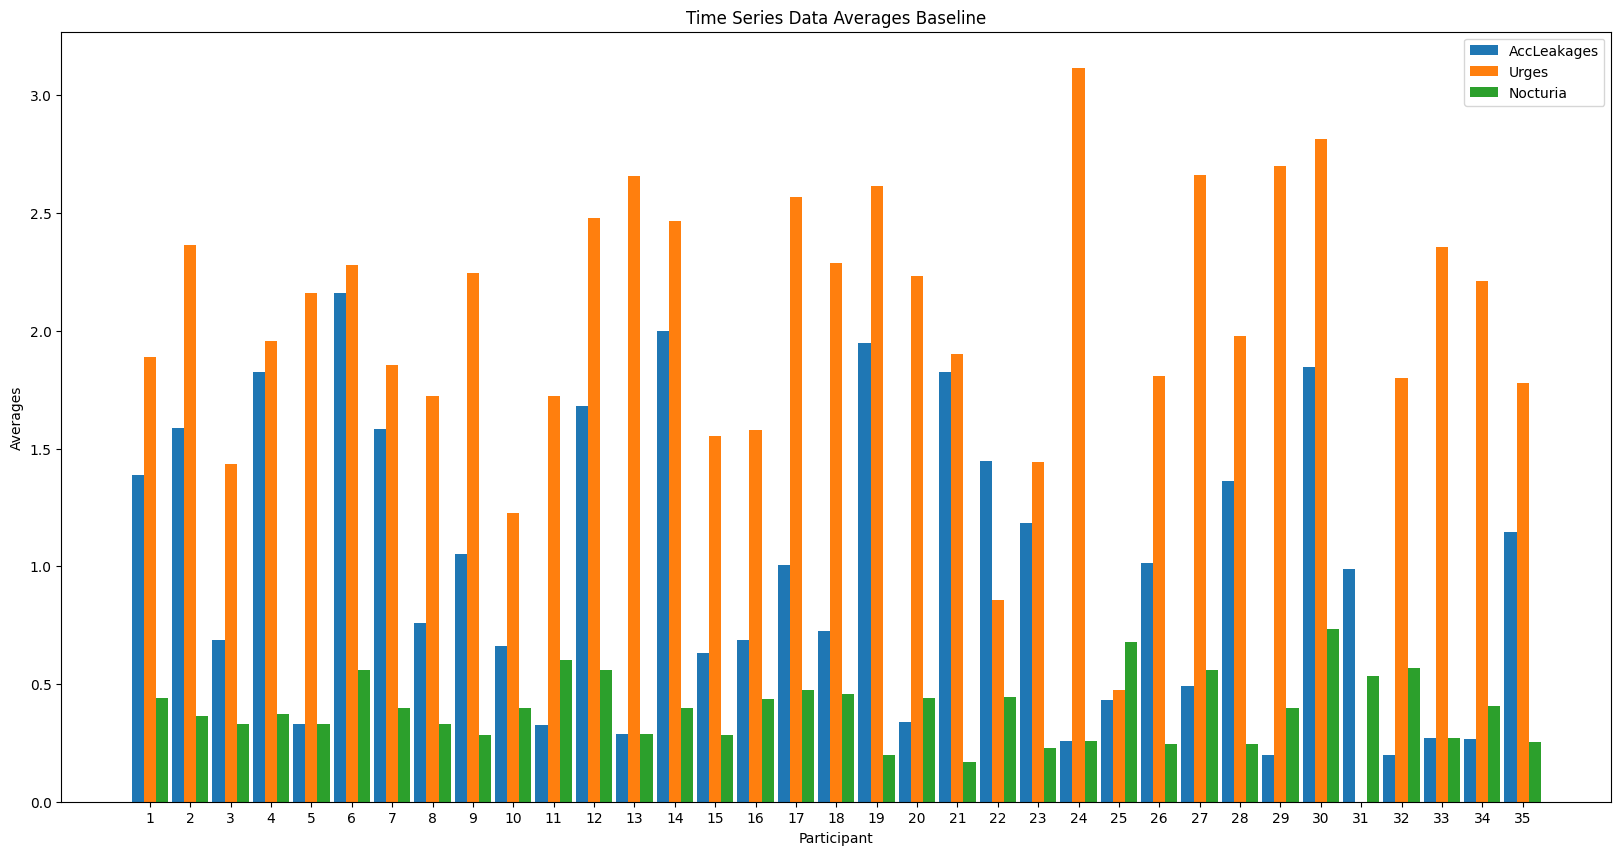

In [ ]:
participants_averages_baseline = []

for participant in rolling_average_baseline:
    averages = []
    for data in participant:

        average = sum(data) / len(data)
        averages.append(average)

    participants_averages_baseline.append(averages)


print(participants_averages_baseline)

plt.figure(figsize=(20, 10))

x = np.arange(len(participants_averages_baseline))
width = 0.3

plt.bar(x - width, [d[0] for d in participants_averages_baseline], width=width, label='AccLeakages')
plt.bar(x, [d[1] for d in participants_averages_baseline], width=width, label='Urges')
plt.bar(x + width, [d[2] for d in participants_averages_baseline], width=width, label='Nocturia')

plt.xlabel('Participant')
plt.ylabel('Averages')
plt.title('Time Series Data Averages Baseline')
plt.xticks(x, [f'{i+1}' for i in range(len(participants_averages_baseline))])
plt.legend()

plt.show()

[[0.41818181818181827, 0.6909090909090905, 0.44848484848484854], [0.8399999999999994, 1.4399999999999995, 0.20000000000000004], [0.6, 1.0999999999999992, 0.2666666666666667], [0.5111111111111112, 2.1037037037037045, 0.288888888888889], [0.5687500000000002, 2.4750000000000005, 0.3187500000000001], [0.5379310344827586, 2.9172413793103464, 0.5034482758620691], [1.5904761904761902, 2.1142857142857148, 0.30476190476190484], [0.5379310344827586, 0.9862068965517234, 0.2965517241379311], [0.30476190476190484, 1.6380952380952383, 0.16190476190476194], [0.7076923076923071, 1.361538461538461, 0.3615384615384617], [0.2969696969696971, 1.2666666666666662, 0.35757575757575755], [1.3399999999999994, 3.120000000000002, 0.7000000000000003], [0.17777777777777778, 3.140740740740743, 0.288888888888889], [1.3249999999999997, 2.5125000000000006, 0.26250000000000007], [0.1619047619047619, 0.5428571428571425, 0.4000000000000001], [0.3583333333333334, 1.6499999999999995, 0.2333333333333333], [0.746153846153846

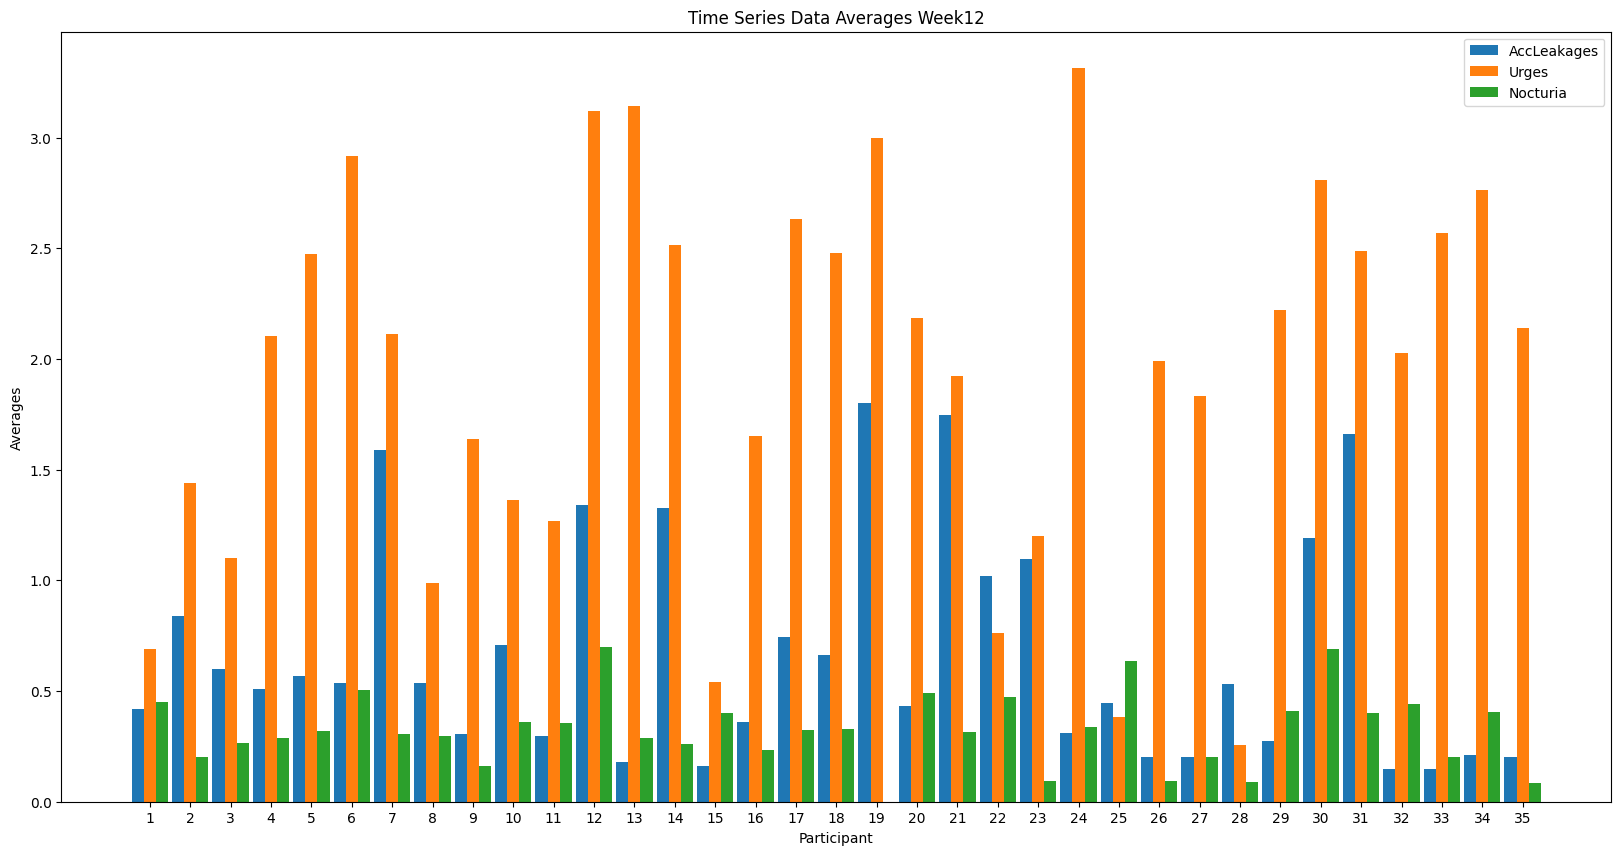

In [ ]:
participants_averages_week12 = []

for participant in rolling_average_week12:
    averages = []
    for data in participant:

        average = sum(data) / len(data)
        averages.append(average)

    participants_averages_week12.append(averages)


print(participants_averages_week12)

plt.figure(figsize=(20, 10))

x = np.arange(len(participants_averages_week12))
width = 0.3

plt.bar(x - width, [d[0] for d in participants_averages_week12], width=width, label='AccLeakages')
plt.bar(x, [d[1] for d in participants_averages_week12], width=width, label='Urges')
plt.bar(x + width, [d[2] for d in participants_averages_week12], width=width, label='Nocturia')

plt.xlabel('Participant')
plt.ylabel('Averages')
plt.title('Time Series Data Averages Week12')
plt.xticks(x, [f'{i+1}' for i in range(len(participants_averages_week12))])
plt.legend()

plt.show()

In [ ]:
differences = []

for averages1, averages2 in zip(participants_averages_baseline, participants_averages_week12):
    participant_difference = [a1 - a2 for a1, a2 in zip(averages1, averages2)]
    differences.append(participant_difference)

print(differences)

[[0.9712918660287078, 1.1985645933014355, -0.006379585326953763], [0.7451851851851852, 0.9229629629629641, 0.162962962962963], [0.08571428571428541, 0.33571428571428585, 0.06190476190476202], [1.3146953405017916, -0.14886499402628584, 0.08530465949820798], [-0.2377155172413794, -0.316379310344828, 0.012284482758620707], [1.6220689655172416, -0.6372413793103466, 0.05655172413793097], [-0.008658008658008809, -0.25974025974026027, 0.09523809523809529], [0.21921182266009798, 0.7352216748768474, 0.03201970443349761], [0.7490842490842484, 0.6080586080586079, 0.12271062271062277], [-0.04682274247491591, -0.1354515050167222, 0.038461538461538436], [0.028030303030302905, 0.4583333333333335, 0.24242424242424276], [0.3400000000000001, -0.6400000000000032, -0.14000000000000012], [0.11111111111111124, -0.48148148148148273, 0.0], [0.675, -0.04583333333333384, 0.1375], [0.46886446886446886, 1.0109890109890107, -0.11538461538461536], [0.327380952380952, -0.07142857142857162, 0.20238095238095258], [0.2

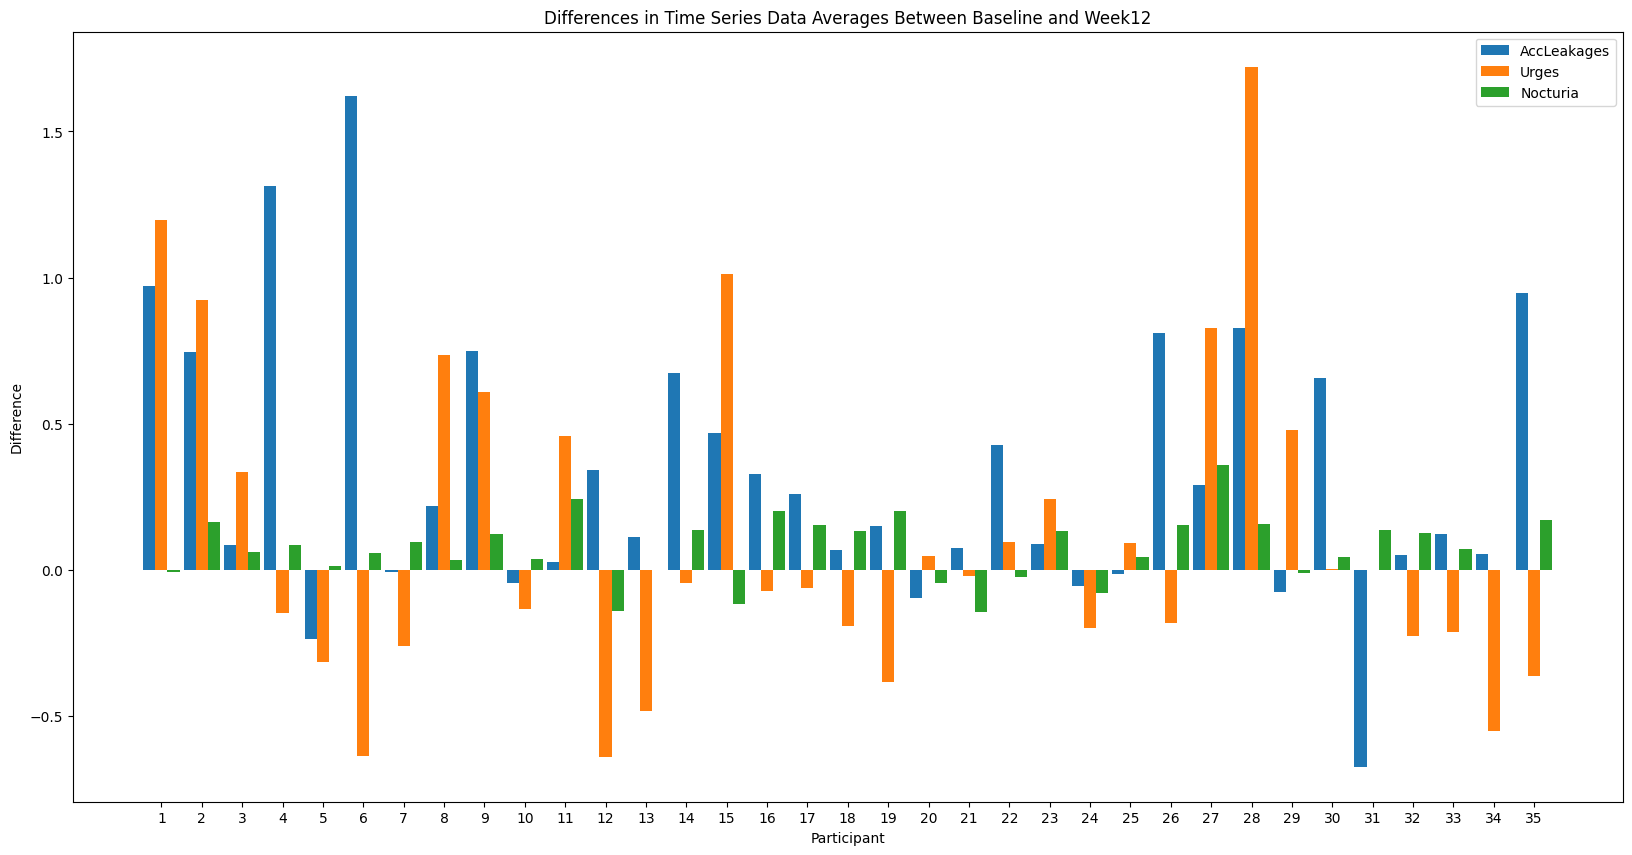

In [ ]:
plt.figure(figsize=(20, 10))

x = np.arange(len(differences))
width = 0.3

plt.bar(x - width, [d[0] for d in differences], width=width, label='AccLeakages')
plt.bar(x, [d[1] for d in differences], width=width, label='Urges')
plt.bar(x + width, [d[2] for d in differences], width=width, label='Nocturia')

plt.xlabel('Participant')
plt.ylabel('Difference')
plt.title('Differences in Time Series Data Averages Between Baseline and Week12')
plt.xticks(x, [f'{i+1}' for i in range(len(differences))])
plt.legend()

plt.show()

###Repeated Measures ANOVA

In [ ]:
patient_id = []
time = []
j = 1
measure_1 = []
measure_2 = []
measure_3 = []

for i in range(35):
  a = rnn_stacked_participant_baseline[i][0].size
  b = rnn_stacked_participant_week12[i][0].size
  c = a + b
  for _ in range(a):
    time.append("baseline")
  for _ in range(b):
    time.append("week12")
  for _ in range(c):
    patient_id.append(j)
  for d in range(rnn_stacked_participant_baseline[i][0].size):
    measure_1.append(rnn_stacked_participant_baseline[i][0][d])
    measure_2.append(rnn_stacked_participant_baseline[i][1][d])
    measure_3.append(rnn_stacked_participant_baseline[i][2][d])
  for d in range(rnn_stacked_participant_week12[i][0].size):
    measure_1.append(rnn_stacked_participant_week12[i][0][d])
    measure_2.append(rnn_stacked_participant_week12[i][1][d])
    measure_3.append(rnn_stacked_participant_week12[i][2][d])

  j = j + 1

In [ ]:
from statsmodels.multivariate.manova import MANOVA
ANOVA_data = {
    'PatientID': patient_id,
    'Time': time,
    'Measurement1': measure_1,
    'Measurement2': measure_2,
    'Measurement3': measure_3
}

ANOVA_df = pd.DataFrame(ANOVA_data)
manova = MANOVA.from_formula('Measurement1 + Measurement2 + Measurement3 ~ Time', data=ANOVA_df)

print(manova.mv_test())

                   Multivariate linear model
                                                                
----------------------------------------------------------------
       Intercept        Value  Num DF   Den DF   F Value  Pr > F
----------------------------------------------------------------
          Wilks' lambda 0.4069 3.0000 2090.0000 1015.3980 0.0000
         Pillai's trace 0.5931 3.0000 2090.0000 1015.3980 0.0000
 Hotelling-Lawley trace 1.4575 3.0000 2090.0000 1015.3980 0.0000
    Roy's greatest root 1.4575 3.0000 2090.0000 1015.3980 0.0000
----------------------------------------------------------------
                                                                
----------------------------------------------------------------
            Time          Value  Num DF   Den DF  F Value Pr > F
----------------------------------------------------------------
            Wilks' lambda 0.9782 3.0000 2090.0000 15.5277 0.0000
           Pillai's trace 0.0218 3.0000 2090.

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM

accleak_data = {
    'PatientID': patient_id,
    'Time': time,
    'Measurement': measure_1
}

accleak_df = pd.DataFrame(accleak_data)


accleak_anova_model = AnovaRM(accleak_df, 'Measurement', 'PatientID', within=['Time'], aggregate_func='mean')
accleak_anova_results = accleak_anova_model.fit()

print(accleak_anova_results.summary())

              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
Time 13.4697 1.0000 34.0000 0.0008



In [ ]:
urges_data = {
    'PatientID': patient_id,
    'Time': time,
    'Measurement': measure_2
}

urges_df = pd.DataFrame(urges_data)


urges_anova_model = AnovaRM(urges_df, 'Measurement', 'PatientID', within=['Time'], aggregate_func='mean')
urges_anova_results = urges_anova_model.fit()

print(urges_anova_results.summary())

              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
Time  0.5977 1.0000 34.0000 0.4448



In [ ]:
nocturia_data = {
    'PatientID': patient_id,
    'Time': time,
    'Measurement': measure_3
}

nocturia_df = pd.DataFrame(nocturia_data)


nocturia_anova_model = AnovaRM(nocturia_df, 'Measurement', 'PatientID', within=['Time'], aggregate_func='mean')
nocturia_anova_results = nocturia_anova_model.fit()

print(nocturia_anova_results.summary())

              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
Time  6.1222 1.0000 34.0000 0.0185



###Mann-Kendall Trend Test

In [ ]:
combined_data = []

for i in range(35):
    participant_combined = []
    for j in range(3):
        df1 = pd.DataFrame(rnn_stacked_participant_baseline[i][j])
        df2 = pd.DataFrame(rnn_stacked_participant_week12[i][j])
        combined_df = pd.concat([df1, df2], ignore_index=True)
        participant_combined.append(combined_df)
    combined_data.append(participant_combined)

numpy_arrays = []

for participant_data in combined_data:
    participant_arrays = []
    for df in participant_data:
        array = df.to_numpy()
        participant_arrays.append(array)
    numpy_arrays.append(participant_arrays)

transposed_numpy_arrays = []

for participant_arrays in numpy_arrays:
    transposed_participant_arrays = []
    for array in participant_arrays:
        transposed_array = array.T
        transposed_participant_arrays.append(transposed_array)
    transposed_numpy_arrays.append(transposed_participant_arrays)
all_time_series = transposed_numpy_arrays

In [ ]:
!pip install pymannkendall

In [ ]:
import pymannkendall as mk

results = []

for participant_arrays in all_time_series:
    participant_results = []
    for array in participant_arrays:
        result = mk.original_test(array[0])
        participant_results.append(result)
    results.append(participant_results)

In [ ]:
for i in range(35):
    print(f"Patient {i + 1}: ", results[i])

Patient 1:  [Mann_Kendall_Test(trend='decreasing', h=True, p=0.0003147774951972604, z=-3.602824970634692, Tau=-0.2535211267605634, s=-630.0, var_s=30480.0, slope=0.0, intercept=0.0), Mann_Kendall_Test(trend='decreasing', h=True, p=2.6799675811872703e-09, z=-5.950088984066794, Tau=-0.45271629778672035, s=-1125.0, var_s=35685.0, slope=-0.02702702702702703, intercept=1.945945945945946), Mann_Kendall_Test(trend='no trend', h=False, p=0.09737215126250276, z=1.6577291307420217, Tau=0.09014084507042254, s=224.0, var_s=18096.0, slope=0.0, intercept=0.0)]
Patient 2:  [Mann_Kendall_Test(trend='decreasing', h=True, p=8.91459955356666e-05, z=-3.9183802577228923, Tau=-0.3401206636500754, s=-451.0, var_s=13189.0, slope=0.0, intercept=1.0), Mann_Kendall_Test(trend='decreasing', h=True, p=2.808511554230897e-05, z=-4.188462136950112, Tau=-0.36726998491704377, s=-487.0, var_s=13463.666666666666, slope=-0.02105496453900709, intercept=2.036901595744681), Mann_Kendall_Test(trend='no trend', h=False, p=0.30

###Change in variance

In [ ]:
timeline_stacked_participant_baseline = [sequence[0] for sequence in stacked_participant_baseline]
timeline_stacked_participant_week12 = [sequence[0] for sequence in stacked_participant_week12]

Bessel's Correction ddof = 1

In [ ]:
pre_treatment_times = timeline_stacked_participant_baseline

post_treatment_times = timeline_stacked_participant_week12

assert len(timeline_stacked_participant_baseline) == len(timeline_stacked_participant_week12)

def calculate_variance(times):
    return np.var(times, ddof=1)

for i in range(len(pre_treatment_times)):
    pre_var = calculate_variance(pre_treatment_times[i])
    post_var = calculate_variance(post_treatment_times[i])
    print(f"Patient {i+1}: Pre-treatment Variance = {pre_var:.2f}, Post-treatment Variance = {post_var:.2f}")

Patient 1: Pre-treatment Variance = 0.78, Post-treatment Variance = 0.86
Patient 2: Pre-treatment Variance = 0.94, Post-treatment Variance = 0.86
Patient 3: Pre-treatment Variance = 0.74, Post-treatment Variance = 0.82
Patient 4: Pre-treatment Variance = 0.82, Post-treatment Variance = 1.22
Patient 5: Pre-treatment Variance = 0.78, Post-treatment Variance = 0.67
Patient 6: Pre-treatment Variance = 0.82, Post-treatment Variance = 0.77
Patient 7: Pre-treatment Variance = 1.45, Post-treatment Variance = 0.94
Patient 8: Pre-treatment Variance = 0.67, Post-treatment Variance = 1.28
Patient 9: Pre-treatment Variance = 0.75, Post-treatment Variance = 0.76
Patient 10: Pre-treatment Variance = 0.84, Post-treatment Variance = 0.73
Patient 11: Pre-treatment Variance = 1.52, Post-treatment Variance = 0.81
Patient 12: Pre-treatment Variance = 0.83, Post-treatment Variance = 0.70
Patient 13: Pre-treatment Variance = 0.89, Post-treatment Variance = 0.79
Patient 14: Pre-treatment Variance = 0.71, Post

### McNemar Test


McNemar Test:

H0: There is no difference in the distribution in one factor across treatment
H1: There is difference

Test for Urgency decrease?

1. Count a,b,c,d
a: Urgency both before and after test
b: Before yes after no
c: Before no after yes
d: Not both before and after

X^2 ~ (b-c)^2/ b+c - test stat
alpha = 0.05
crtical value X^2(0.05)

if test_stat > critical => Reject Null

In [ ]:
accLeak_participant_baseline = [sequence[1] for sequence in stacked_participant_baseline]
accLeak_participant_week12 = [sequence[1] for sequence in stacked_participant_week12]
urges_participant_baseline = [sequence[2] for sequence in stacked_participant_baseline]
urges_participant_baseline = [np.nan_to_num(arr, nan=0) for arr in urges_participant_baseline]
urges_participant_week12 = [sequence[2] for sequence in stacked_participant_week12]
nocturia_participant_baseline = [sequence[3] for sequence in stacked_participant_baseline]
nocturia_participant_week12 = [sequence[3] for sequence in stacked_participant_week12]

In [ ]:
def pad_list(list1, list2):
  padded_list1 = []
  padded_list2 = []
  for sublist1, sublist2 in zip(list1, list2):
      if len(sublist1) == 0 and len(sublist2) == 0:
            # Both sublists are empty, skip padding
        continue
      max_length = max(len(sublist1), len(sublist2))
      padded_sublist1 = np.pad(sublist1, (0, max_length - len(sublist1)), mode='constant')
      padded_sublist2 = np.pad(sublist2, (0, max_length - len(sublist2)), mode='constant')
      padded_list1.append(padded_sublist1)
      padded_list2.append(padded_sublist2)
  return padded_list1, padded_list2

#accLeak_participant_baseline, accLeak_participant_week12 = pad_list(accLeak_participant_baseline, accLeak_participant_week12)
accLeak_participant_baseline = [np.where(arr == 4, 2, arr) for arr in accLeak_participant_baseline]
accLeak_participant_week12 = [np.where(arr == 4, 2, arr) for arr in accLeak_participant_week12]
#urges_participant_baseline, urges_participant_week12 = pad_list(urges_participant_baseline, urges_participant_week12)
#nocturia_participant_baseline, nocturia_participant_week12 = pad_list(nocturia_participant_baseline, nocturia_participant_week12)

In [ ]:
from statsmodels.stats.contingency_tables import mcnemar

def mcnemar_test(pre_treatment, post_treatment):

  a = b = c = d = 0
  th = 1
  for pre, post in zip(pre_treatment, post_treatment):
      if pre == th and post == th:
          a += 1
      elif pre == th and post == 0:
          b += 1
      elif pre == 0 and post == th:
          c += 1
      elif pre == 0 and post == 0:
          d += 1

  contingency_table = np.array([[a, b], [c, d]])

  result = mcnemar(contingency_table, exact=False, correction=True)

  print("McNemar's test Statistic:", result.statistic)
  print("p-value:", result.pvalue)
for i in range (len(nocturia_participant_baseline)):
  mcnemar_test(nocturia_participant_baseline[i], nocturia_participant_week12[i])

McNemar's test Statistic: 0.0
p-value: 1.0
McNemar's test Statistic: 1.5
p-value: 0.22067136191984324
McNemar's test Statistic: 0.16666666666666666
p-value: 0.6830913983096086
McNemar's test Statistic: 0.16666666666666666
p-value: 0.6830913983096086
McNemar's test Statistic: 0.0
p-value: 1.0
McNemar's test Statistic: 0.0
p-value: 1.0
McNemar's test Statistic: 0.5
p-value: 0.47950012218695337
McNemar's test Statistic: 0.0
p-value: 1.0
McNemar's test Statistic: 0.25
p-value: 0.6170750774519739
McNemar's test Statistic: 0.0
p-value: 1.0
McNemar's test Statistic: 3.5
p-value: 0.0613688291394023
McNemar's test Statistic: 4.0
p-value: 0.04550026389635857
McNemar's test Statistic: 0.25
p-value: 0.6170750774519739
McNemar's test Statistic: 0.125
p-value: 0.7236736098317629
McNemar's test Statistic: 0.4444444444444444
p-value: 0.5049850750938457
McNemar's test Statistic: 2.2857142857142856
p-value: 0.13057001811573693
McNemar's test Statistic: 0.75
p-value: 0.3864762307712325
McNemar's test Sta

###Univariate case paired test

In [ ]:
averages_accLeaks_baseline = [np.mean(arr) for arr in accLeak_participant_baseline]
averages_urges_baseline = [np.mean(arr) for arr in urges_participant_baseline]
averages_nocturia_baseline = [np.mean(arr) for arr in nocturia_participant_baseline]
averages_accLeaks_week12 = [np.mean(arr) for arr in accLeak_participant_week12]
averages_urges_week12 = [np.mean(arr) for arr in urges_participant_week12]
averages_nocturia_week12 = [np.mean(arr) for arr in nocturia_participant_week12]

a, b = stats.ttest_rel(averages_accLeaks_baseline, averages_accLeaks_week12)
c, d = stats.ttest_rel(averages_urges_baseline, averages_urges_week12)
e, f = stats.ttest_rel(averages_nocturia_baseline, averages_nocturia_week12)

print(f'Average AccLeaks T-statistic: {a}, P-value: {b}')
print(f'Average Urges T-statistic: {c}, P-value: {d}')
print(f'Average Nocturia T-statistic: {e}, P-value: {f}')

Average AccLeaks T-statistic: 3.6701081696076097, P-value: 0.00082422878031239
Average Urges T-statistic: 0.7488076247680968, P-value: 0.4591224506180104
Average Nocturia T-statistic: 2.4743119493131163, P-value: 0.018498162287994148


###Logistic regression Bowker test



###Counting hist curve from 0-3 all data

In [ ]:
def round_arrays(arrays, step):
    return [np.round(arr / step) * step for arr in arrays]

rounded_timeline_baseline_004 = round_arrays(timeline_stacked_participant_baseline, 0.04)
rounded_timeline_baseline_0125 = round_arrays(timeline_stacked_participant_baseline, 0.125)
rounded_timeline_baseline_025 = round_arrays(timeline_stacked_participant_baseline, 0.25)
rounded_timeline_baseline_05 = round_arrays(timeline_stacked_participant_baseline, 0.5)
rounded_timeline_week12_004 = round_arrays(timeline_stacked_participant_week12, 0.04)
rounded_timeline_week12_0125 = round_arrays(timeline_stacked_participant_week12, 0.125)
rounded_timeline_week12_025 = round_arrays(timeline_stacked_participant_week12, 0.25)
rounded_timeline_week12_05 = round_arrays(timeline_stacked_participant_week12, 0.5)

In [ ]:
def find_arrays_with_large_numbers(array_list, array_list_2, threshold=3.5):
    indices = []
    for index, arr in enumerate(array_list):
        if any(number > threshold for number in arr):
            indices.append(index)
            print(f"Baseline Array at index {index + 1} contains abnormal number")
    for index, arr in enumerate(array_list_2):
        if any(number > threshold for number in arr):
            indices.append(index)
            print(f"Week 12 Array at index {index + 1} contains abnormal number")

    return indices
find_arrays_with_large_numbers(timeline_stacked_participant_baseline, timeline_stacked_participant_week12)

Baseline Array at index 7 contains abnormal number
Baseline Array at index 11 contains abnormal number
Baseline Array at index 28 contains abnormal number
Week 12 Array at index 4 contains abnormal number
Week 12 Array at index 8 contains abnormal number
Week 12 Array at index 16 contains abnormal number
Week 12 Array at index 27 contains abnormal number
Week 12 Array at index 28 contains abnormal number
Week 12 Array at index 33 contains abnormal number


[6, 10, 27, 3, 7, 15, 26, 27, 32]

####Number of trips

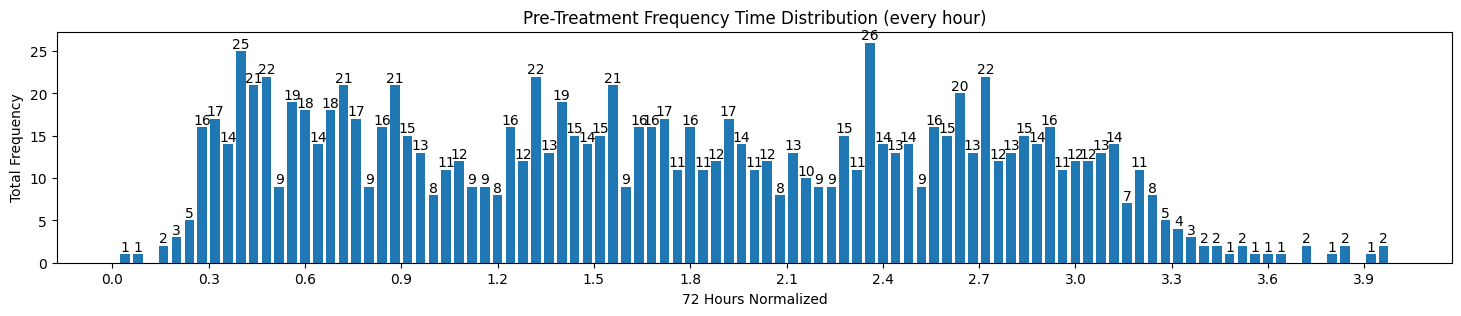

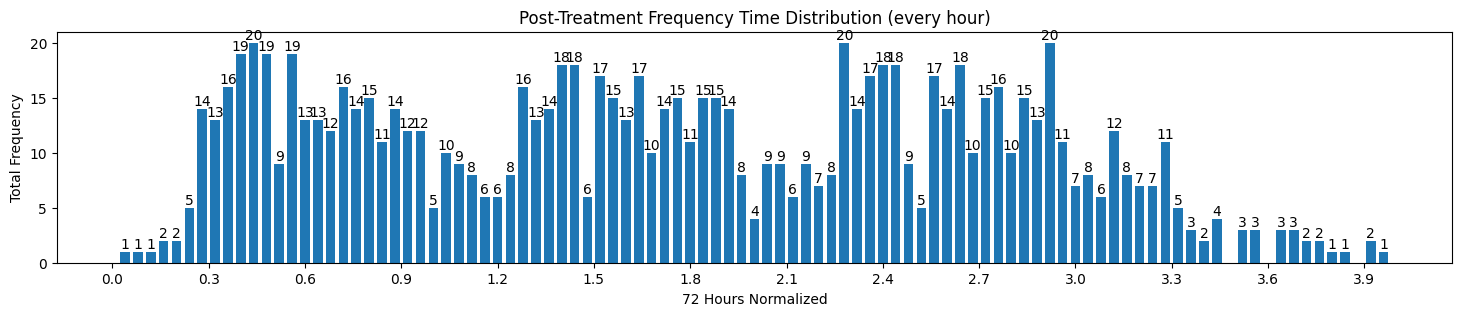

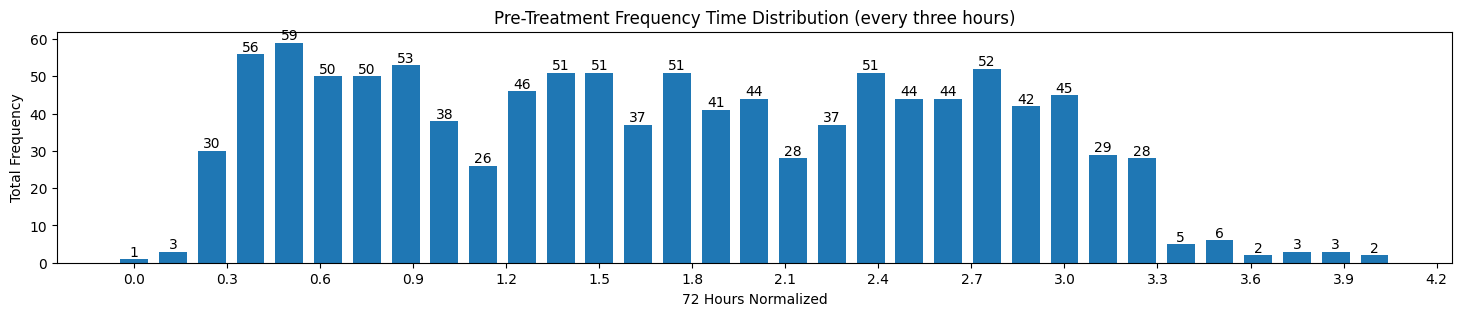

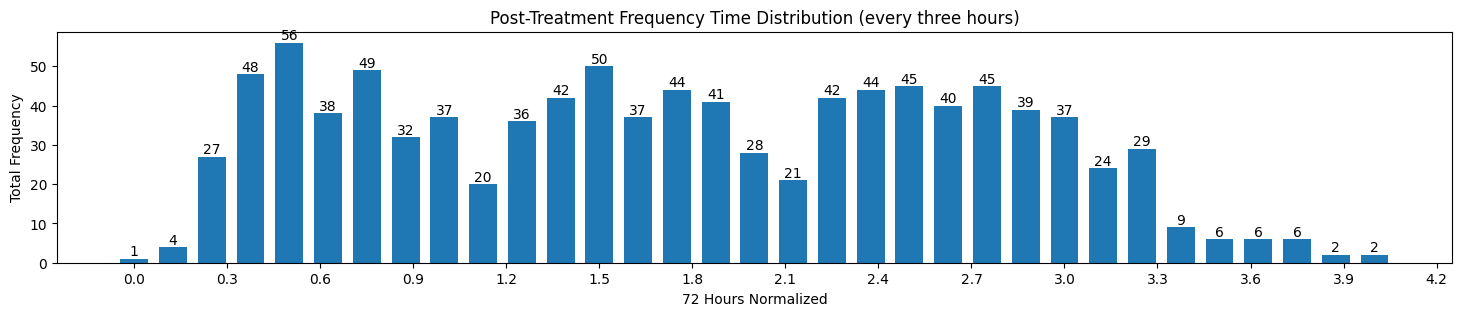

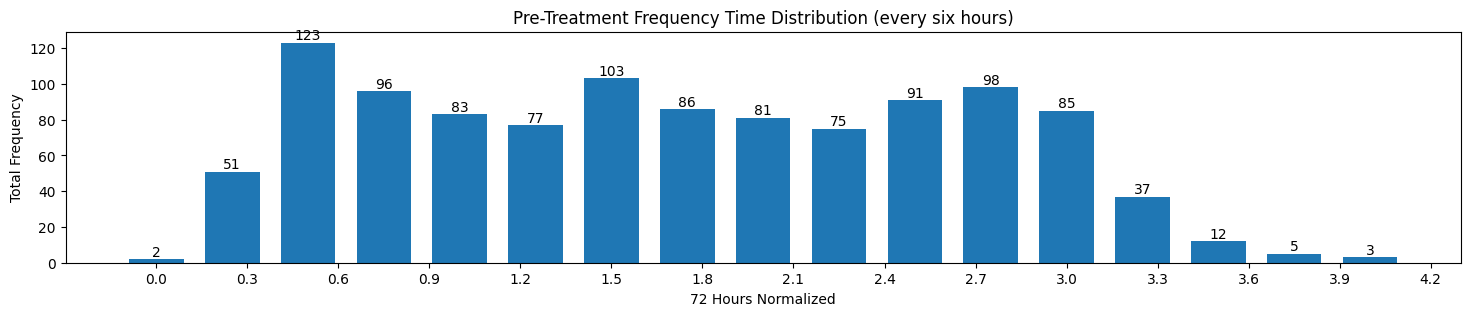

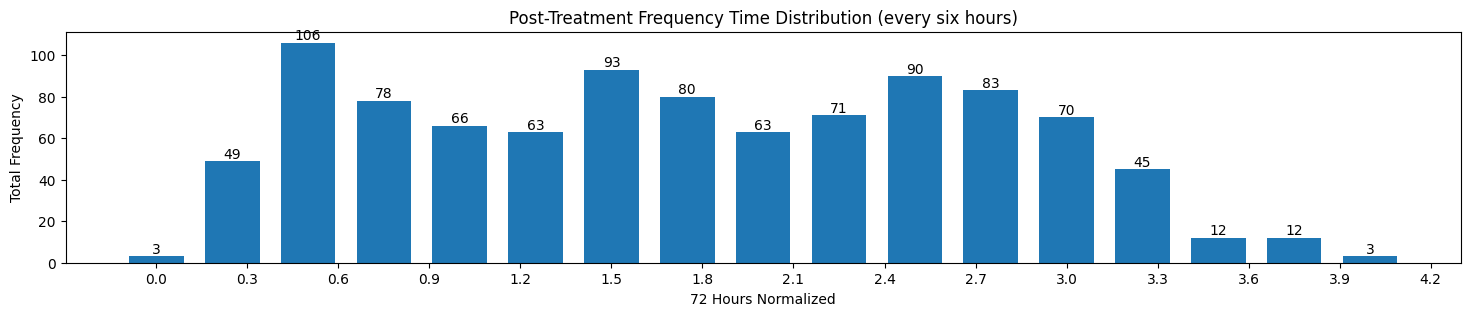

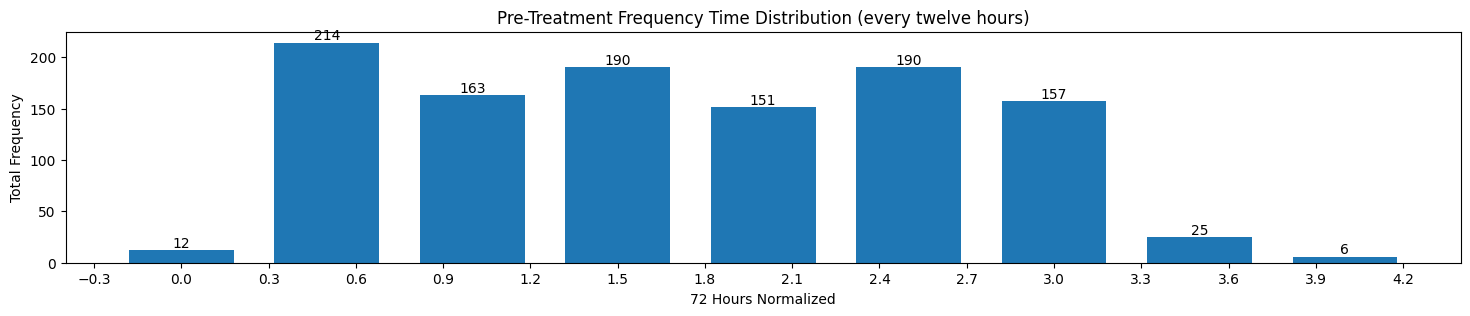

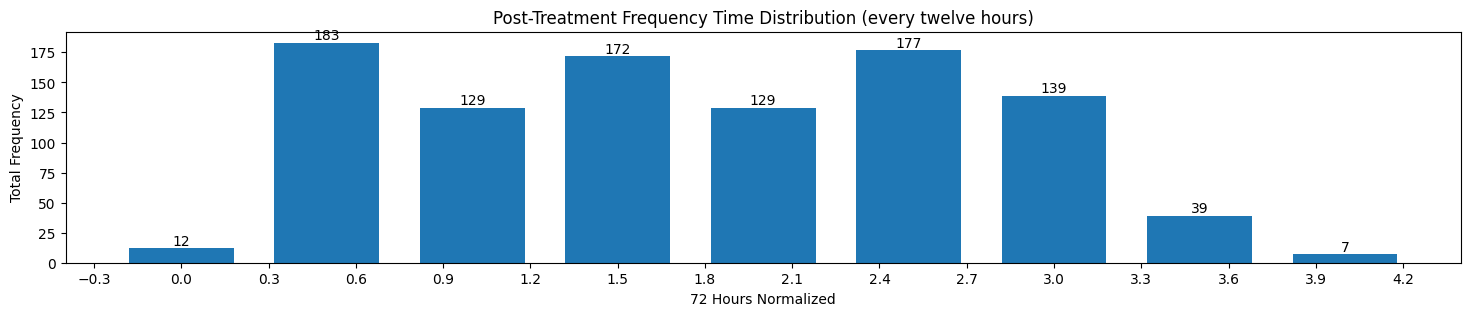

In [ ]:
from collections import Counter
from matplotlib.ticker import MultipleLocator
from collections import defaultdict

def count_frequecy(array_list, title, n):
  counter = Counter()

  for arr in array_list:
      counter.update(arr)

  numbers, frequencies = zip(*sorted(counter.items()))
  fig, ax = plt.subplots(figsize=(18, 3))
  bars = plt.bar(numbers, frequencies, width=0.03 * n)
  ax.xaxis.set_major_locator(MultipleLocator(0.3))
  for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom')
  plt.xlabel('72 Hours Normalized')
  plt.ylabel('Total Frequency')
  plt.title(title)
  plt.show()

count_frequecy(rounded_timeline_baseline_004, 'Pre-Treatment Frequency Time Distribution (every hour)', 1)
count_frequecy(rounded_timeline_week12_004, 'Post-Treatment Frequency Time Distribution (every hour)', 1)
count_frequecy(rounded_timeline_baseline_0125, 'Pre-Treatment Frequency Time Distribution (every three hours)', 3)
count_frequecy(rounded_timeline_week12_0125, 'Post-Treatment Frequency Time Distribution (every three hours)', 3)
count_frequecy(rounded_timeline_baseline_025, 'Pre-Treatment Frequency Time Distribution (every six hours)', 6)
count_frequecy(rounded_timeline_week12_025, 'Post-Treatment Frequency Time Distribution (every six hours)', 6)
count_frequecy(rounded_timeline_baseline_05, 'Pre-Treatment Frequency Time Distribution (every twelve hours)', 12)
count_frequecy(rounded_timeline_week12_05, 'Post-Treatment Frequency Time Distribution (every twelve hours)', 12)

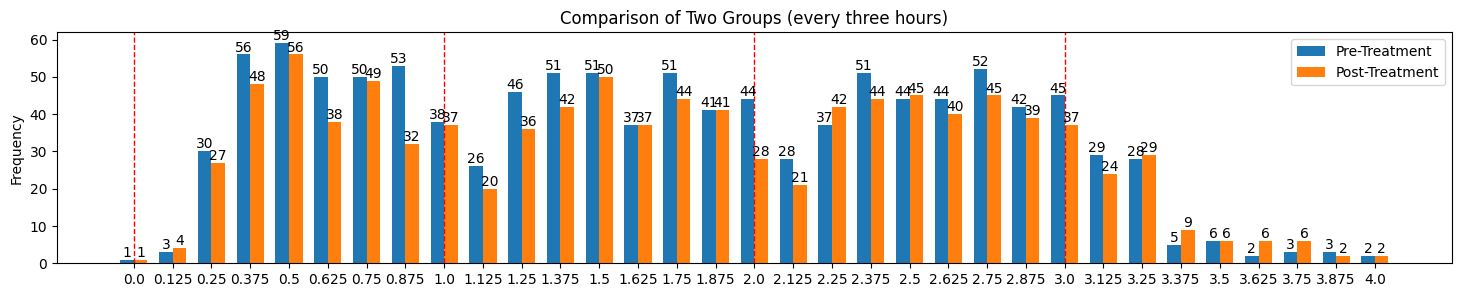

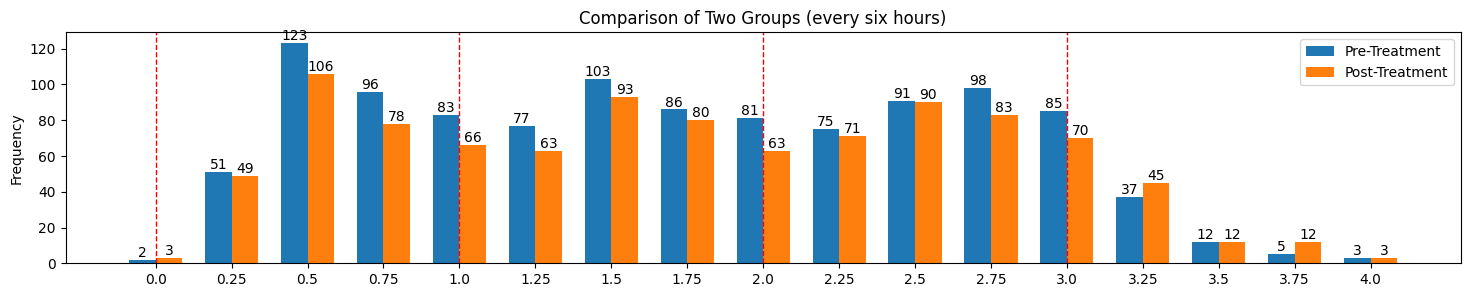

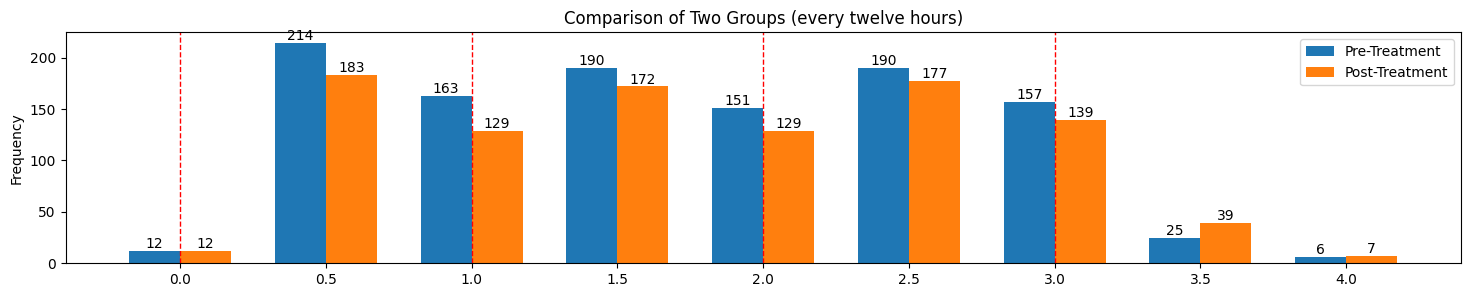

In [ ]:
def plot_parallel_bars(list_of_arrays1, list_of_arrays2, title, red):

    counter1 = Counter(np.concatenate(list_of_arrays1))
    counter2 = Counter(np.concatenate(list_of_arrays2))

    all_elements = sorted(set(counter1) | set(counter2))
    frequencies1 = [counter1.get(element, 0) for element in all_elements]
    frequencies2 = [counter2.get(element, 0) for element in all_elements]

    fig, ax = plt.subplots(figsize=(18, 3))
    x = np.arange(len(all_elements))
    width = 0.35

    rects1 = ax.bar(x - width/2, frequencies1, width, label='Pre-Treatment')
    rects2 = ax.bar(x + width/2, frequencies2, width, label='Post-Treatment')
    def add_labels(bars):
      for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}',
                ha='center', va='bottom')
    for pos in red:
      if pos in x:
          ax.axvline(x=pos, color='red', linestyle='--', lw=1)
    add_labels(rects1)
    add_labels(rects2)

    ax.set_ylabel('Frequency')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(all_elements)
    ax.legend()

    plt.show()

plot_parallel_bars(rounded_timeline_baseline_0125, rounded_timeline_week12_0125, "Comparison of Two Groups (every three hours)", [0, 8, 16, 24])
plot_parallel_bars(rounded_timeline_baseline_025, rounded_timeline_week12_025, "Comparison of Two Groups (every six hours)", [0, 4, 8, 12])
plot_parallel_bars(rounded_timeline_baseline_05, rounded_timeline_week12_05, "Comparison of Two Groups (every twelve hours)", [0, 2, 4, 6])

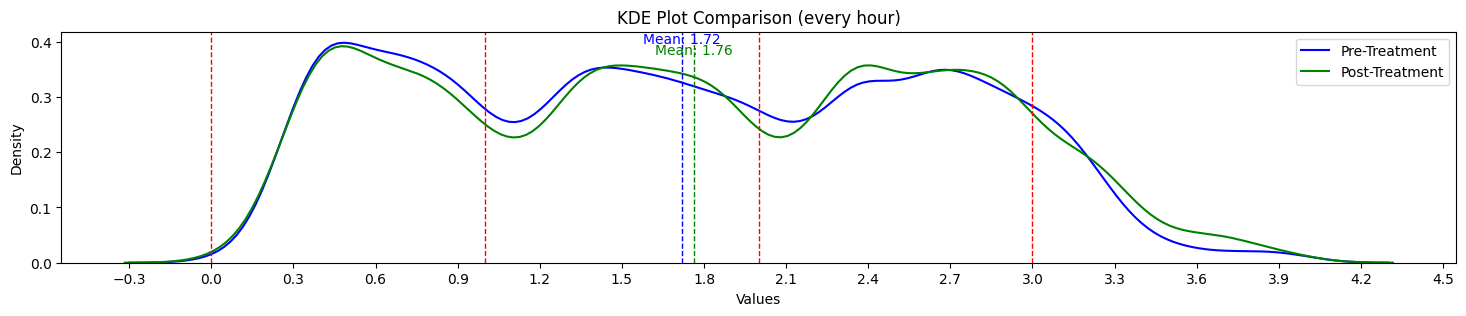

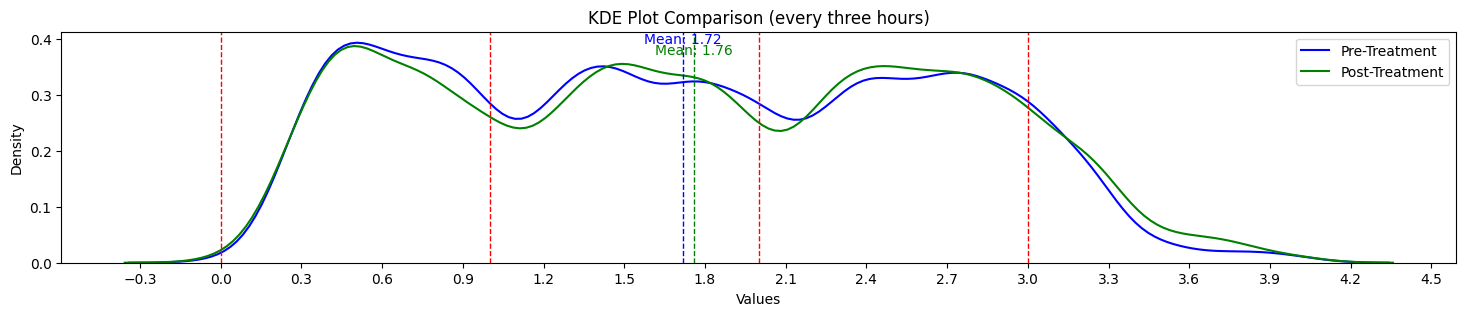

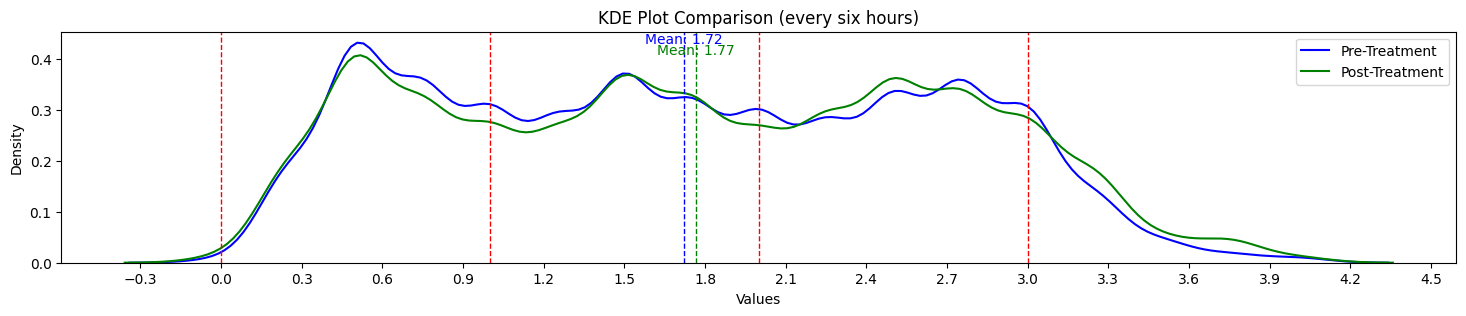

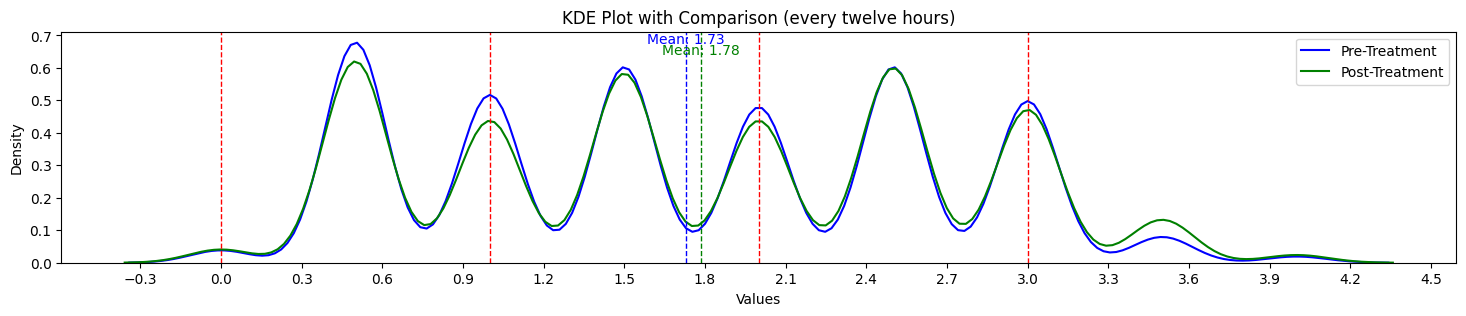

In [ ]:
def plot_kde_with_labels(list_of_arrays1, list_of_arrays2, title):
    data1 = np.concatenate(list_of_arrays1)
    data2 = np.concatenate(list_of_arrays2)
    fig, ax = plt.subplots(figsize=(18, 3))
    sns.kdeplot(data1, label='Pre-Treatment', bw_adjust=0.5, color='blue')
    sns.kdeplot(data2, label='Post-Treatment', bw_adjust=0.5, color='green')

    for x in [0, 1, 2, 3]:
        plt.axvline(x=x, color='red', linestyle='--', lw=1)

    mean1 = np.mean(data1)
    mean2 = np.mean(data2)
    plt.axvline(x=mean1, color='blue', linestyle='--', lw=1)
    plt.axvline(x=mean2, color='green', linestyle='--', lw=1)
    plt.text(mean1, plt.ylim()[1]*0.95, f'Mean: {mean1:.2f}', color='blue', ha='center')
    plt.text(mean2, plt.ylim()[1]*0.90, f'Mean: {mean2:.2f}', color='green', ha='center')
    ax.xaxis.set_major_locator(MultipleLocator(0.3))
    plt.title(title)
    plt.xlabel('Values')
    plt.ylabel('Density')
    plt.legend()

    plt.show()

plot_kde_with_labels(rounded_timeline_baseline_004, rounded_timeline_week12_004, "KDE Plot Comparison (every hour)")
plot_kde_with_labels(rounded_timeline_baseline_0125, rounded_timeline_week12_0125, "KDE Plot Comparison (every three hours)")
plot_kde_with_labels(rounded_timeline_baseline_025, rounded_timeline_week12_025, "KDE Plot Comparison (every six hours)")
plot_kde_with_labels(rounded_timeline_baseline_05, rounded_timeline_week12_05, "KDE Plot with Comparison (every twelve hours)")

####AccLeaks symptoms (All, 1, 2, 3)

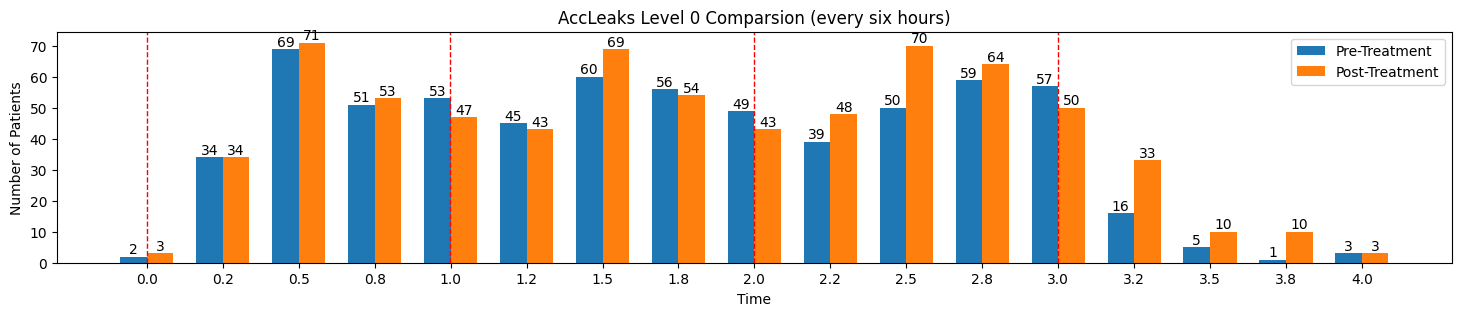

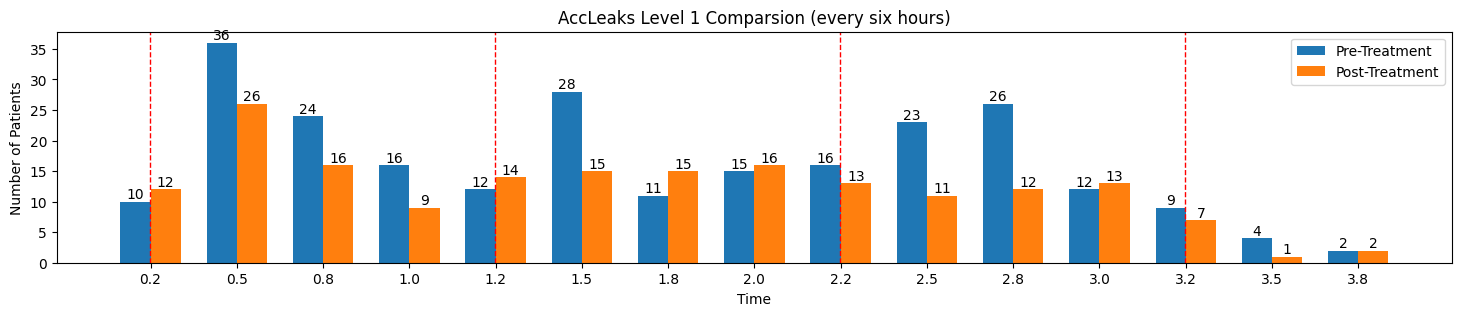

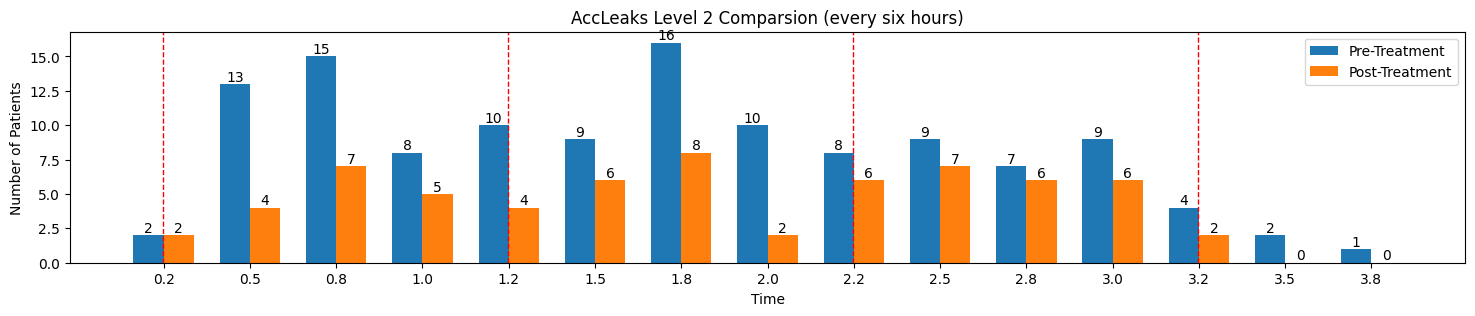

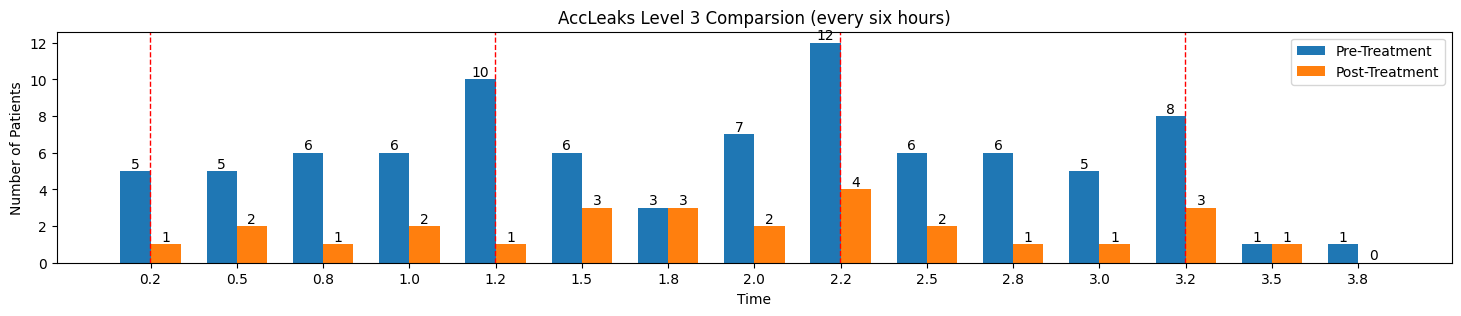

In [ ]:
def plot_symptom_level_change(time_data_groups, symptom_data_groups, symptom_level, labels, title):
    symptom_counts = []

    for time_data, symptom_data in zip(time_data_groups, symptom_data_groups):
        combined_counts = defaultdict(int)
        for times, symptoms in zip(time_data, symptom_data):
            for time, symptom in zip(times, symptoms):
                if symptom == symptom_level:
                    time_key = f"{time:.1f}"
                    combined_counts[time_key] += 1
        symptom_counts.append(combined_counts)

    all_times = sorted(set(key for counts in symptom_counts for key in counts), key=float)

    fig, ax = plt.subplots(figsize=(18, 3))
    width = 0.35
    x = np.arange(len(all_times))

    bars = []
    for i, (counts, label) in enumerate(zip(symptom_counts, labels)):
        frequencies = [counts[time] for time in all_times]
        bar = ax.bar(x + i * width, frequencies, width, label=label)
        bars.append(bar)

    for bar in bars:
        for rect in bar:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width() / 2, height, f'{int(height)}',
                    ha='center', va='bottom')

    for pos in [0, 4, 8, 12]:
      if pos in x:
          ax.axvline(x=pos + 0.17, color='red', linestyle='--', lw=1)
    ax.set_ylabel('Number of Patients')
    ax.set_xlabel('Time')
    ax.set_title(title)
    ax.set_xticks(x + width * (len(labels) - 1) / 2)
    ax.set_xticklabels(all_times)
    ax.legend()

    plt.show()

plot_symptom_level_change([rounded_timeline_baseline_025, rounded_timeline_week12_025], [accLeak_participant_baseline, accLeak_participant_week12], 0, ['Pre-Treatment', 'Post-Treatment'], 'AccLeaks Level 0 Comparsion (every six hours)')
plot_symptom_level_change([rounded_timeline_baseline_025, rounded_timeline_week12_025], [accLeak_participant_baseline, accLeak_participant_week12], 1, ['Pre-Treatment', 'Post-Treatment'], 'AccLeaks Level 1 Comparsion (every six hours)')
plot_symptom_level_change([rounded_timeline_baseline_025, rounded_timeline_week12_025], [accLeak_participant_baseline, accLeak_participant_week12], 2, ['Pre-Treatment', 'Post-Treatment'], 'AccLeaks Level 2 Comparsion (every six hours)')
plot_symptom_level_change([rounded_timeline_baseline_025, rounded_timeline_week12_025], [accLeak_participant_baseline, accLeak_participant_week12], 3, ['Pre-Treatment', 'Post-Treatment'], 'AccLeaks Level 3 Comparsion (every six hours)')

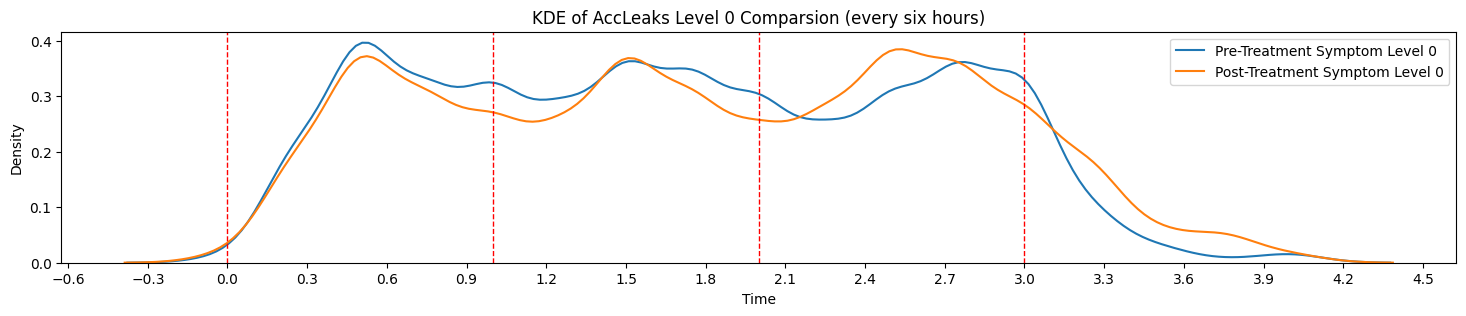

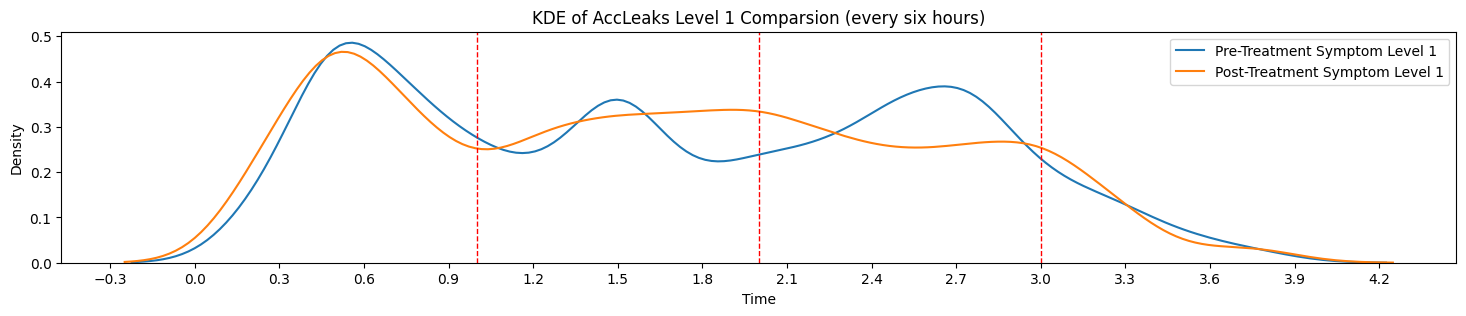

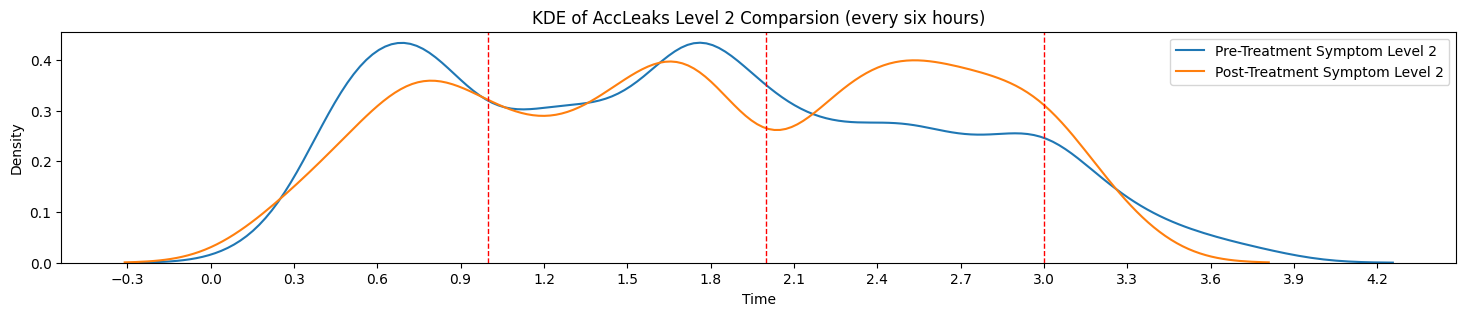

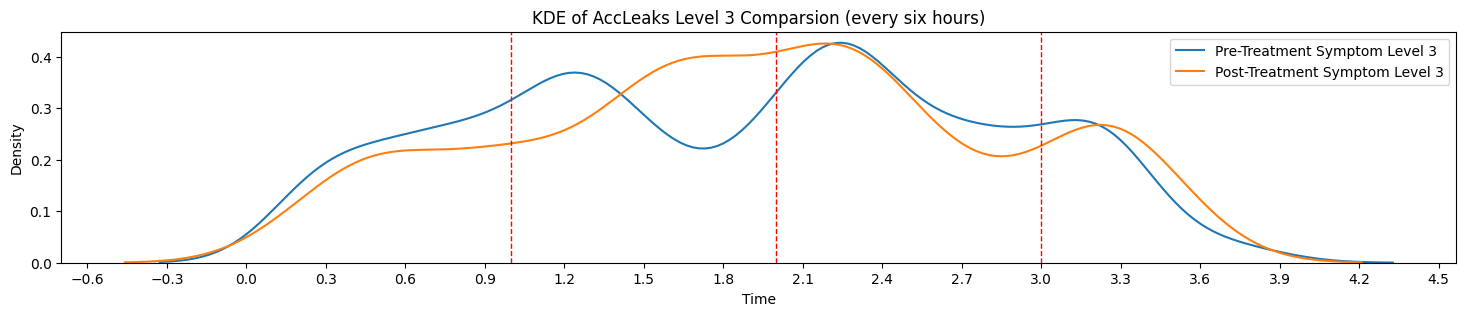

In [ ]:
def plot_symptom_level_kde(time_data_groups, symptom_data_groups, symptom_level, labels, title):
    fig, ax = plt.subplots(figsize=(18, 3))

    for time_data, symptom_data, label in zip(time_data_groups, symptom_data_groups, labels):
        combined_times = []
        for times, symptoms in zip(time_data, symptom_data):
            for time, symptom in zip(times, symptoms):
                if symptom == symptom_level:
                    combined_times.append(time)

        if combined_times:
            sns.kdeplot(combined_times, bw_adjust=0.5, label=f'{label} Symptom Level {symptom_level}', ax=ax)
    for pos in [0, 1, 2, 3]:
      if pos in combined_times:
          ax.axvline(x=pos, color='red', linestyle='--', lw=1)
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Density')
    ax.xaxis.set_major_locator(MultipleLocator(0.3))
    ax.legend()

    plt.show()

plot_symptom_level_kde([rounded_timeline_baseline_025, rounded_timeline_week12_025], [accLeak_participant_baseline, accLeak_participant_week12], 0, ['Pre-Treatment', 'Post-Treatment'], 'KDE of AccLeaks Level 0 Comparsion (every six hours)')
plot_symptom_level_kde([rounded_timeline_baseline_025, rounded_timeline_week12_025], [accLeak_participant_baseline, accLeak_participant_week12], 1, ['Pre-Treatment', 'Post-Treatment'], 'KDE of AccLeaks Level 1 Comparsion (every six hours)')
plot_symptom_level_kde([rounded_timeline_baseline_025, rounded_timeline_week12_025], [accLeak_participant_baseline, accLeak_participant_week12], 2, ['Pre-Treatment', 'Post-Treatment'], 'KDE of AccLeaks Level 2 Comparsion (every six hours)')
plot_symptom_level_kde([rounded_timeline_baseline_025, rounded_timeline_week12_025], [accLeak_participant_baseline, accLeak_participant_week12], 3, ['Pre-Treatment', 'Post-Treatment'], 'KDE of AccLeaks Level 3 Comparsion (every six hours)')

####Urges symptoms (All, 1, 2, 3)

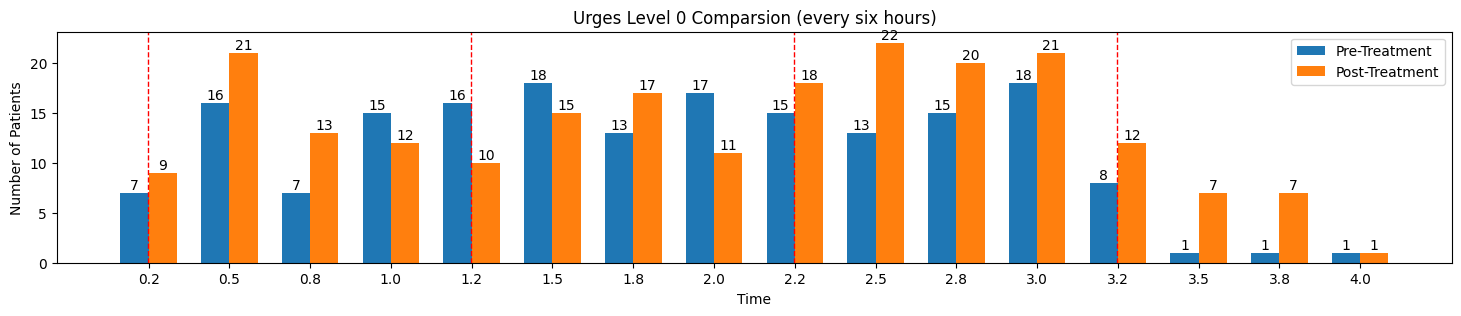

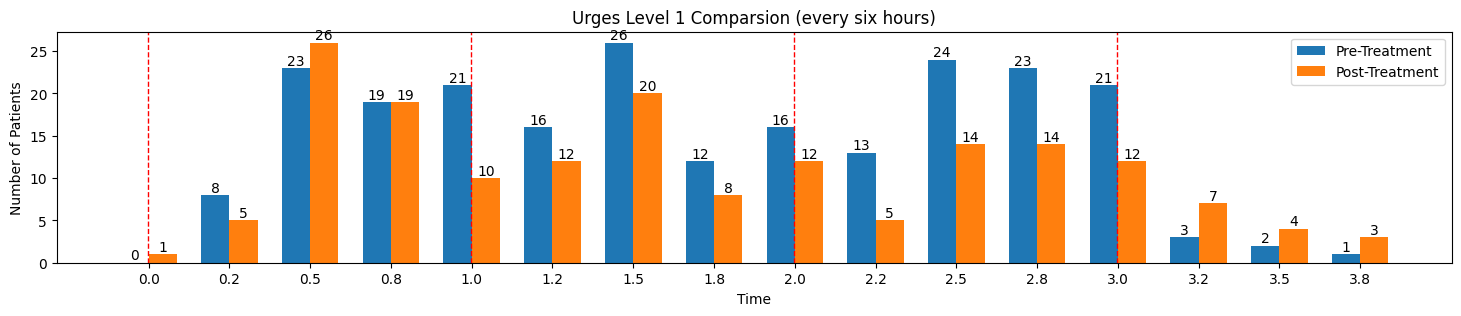

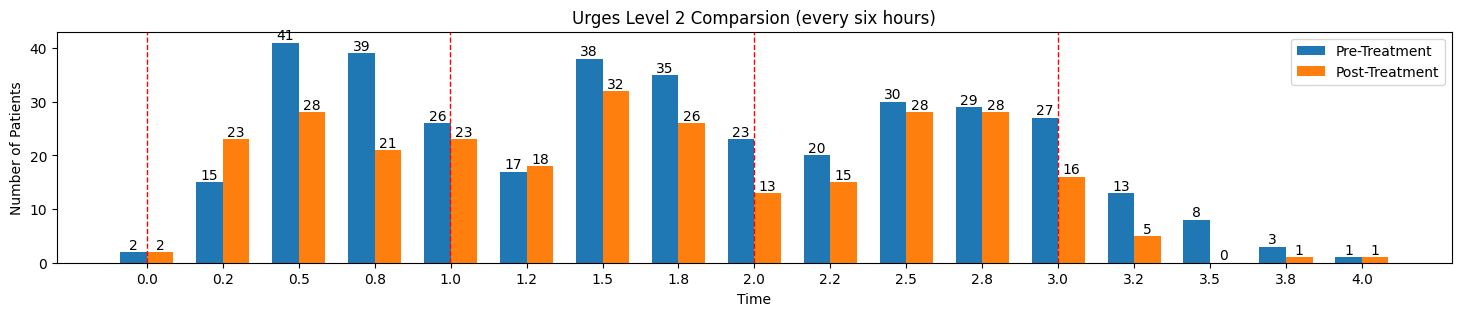

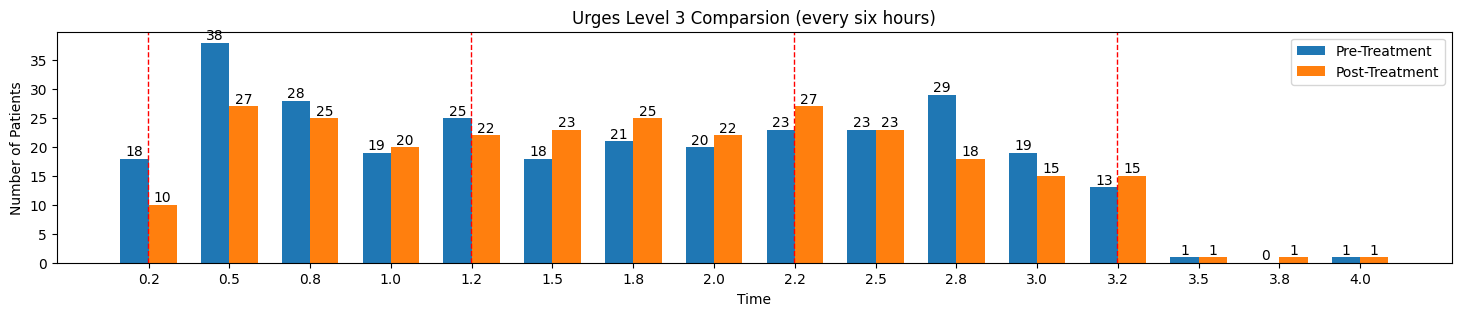

In [ ]:
plot_symptom_level_change([rounded_timeline_baseline_025, rounded_timeline_week12_025], [urges_participant_baseline, urges_participant_week12], 0, ['Pre-Treatment', 'Post-Treatment'], 'Urges Level 0 Comparsion (every six hours)')
plot_symptom_level_change([rounded_timeline_baseline_025, rounded_timeline_week12_025], [urges_participant_baseline, urges_participant_week12], 1, ['Pre-Treatment', 'Post-Treatment'], 'Urges Level 1 Comparsion (every six hours)')
plot_symptom_level_change([rounded_timeline_baseline_025, rounded_timeline_week12_025], [urges_participant_baseline, urges_participant_week12], 2, ['Pre-Treatment', 'Post-Treatment'], 'Urges Level 2 Comparsion (every six hours)')
plot_symptom_level_change([rounded_timeline_baseline_025, rounded_timeline_week12_025], [urges_participant_baseline, urges_participant_week12], 3, ['Pre-Treatment', 'Post-Treatment'], 'Urges Level 3 Comparsion (every six hours)')

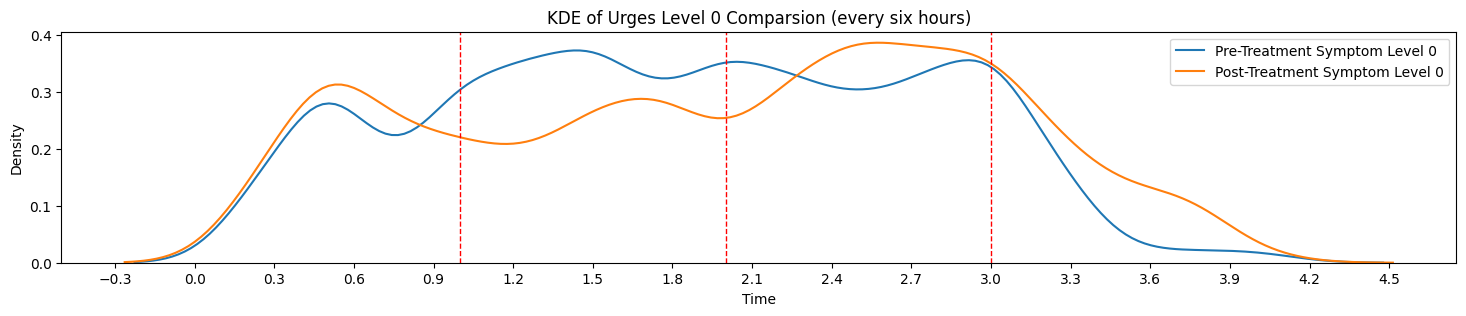

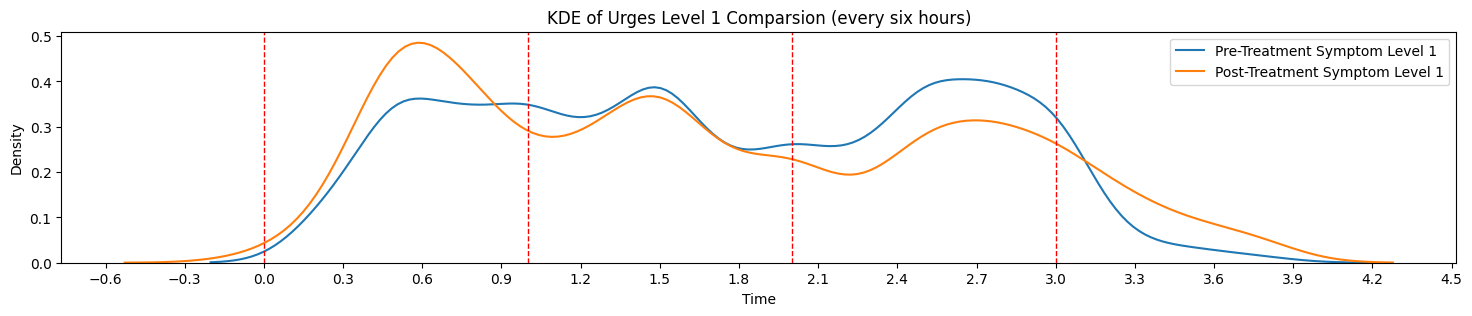

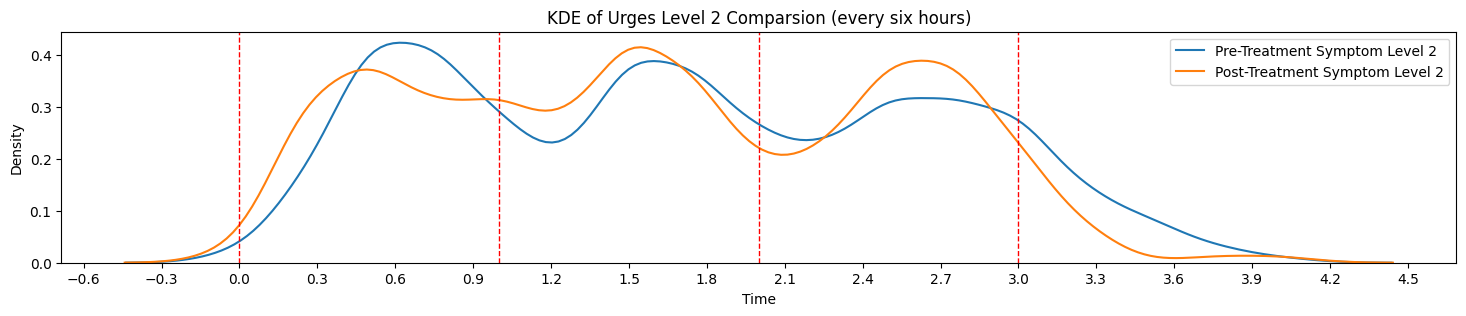

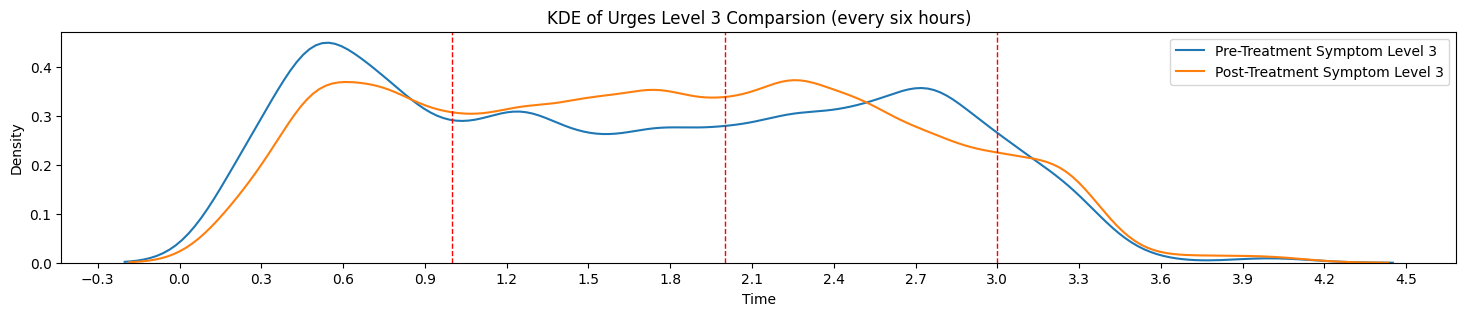

In [ ]:
plot_symptom_level_kde([rounded_timeline_baseline_025, rounded_timeline_week12_025], [urges_participant_baseline, urges_participant_week12], 0, ['Pre-Treatment', 'Post-Treatment'], 'KDE of Urges Level 0 Comparsion (every six hours)')
plot_symptom_level_kde([rounded_timeline_baseline_025, rounded_timeline_week12_025], [urges_participant_baseline, urges_participant_week12], 1, ['Pre-Treatment', 'Post-Treatment'], 'KDE of Urges Level 1 Comparsion (every six hours)')
plot_symptom_level_kde([rounded_timeline_baseline_025, rounded_timeline_week12_025], [urges_participant_baseline, urges_participant_week12], 2, ['Pre-Treatment', 'Post-Treatment'], 'KDE of Urges Level 2 Comparsion (every six hours)')
plot_symptom_level_kde([rounded_timeline_baseline_025, rounded_timeline_week12_025], [urges_participant_baseline, urges_participant_week12], 3, ['Pre-Treatment', 'Post-Treatment'], 'KDE of Urges Level 3 Comparsion (every six hours)')

####Nocturia symptoms

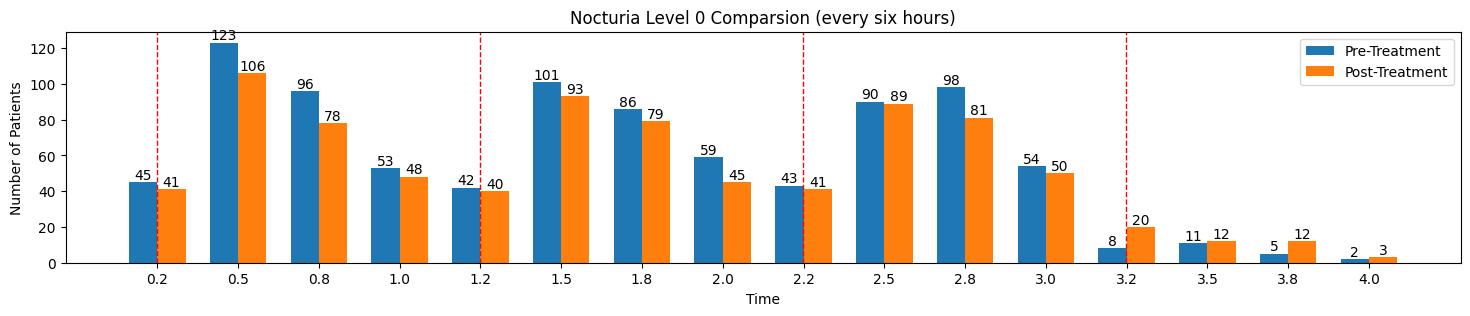

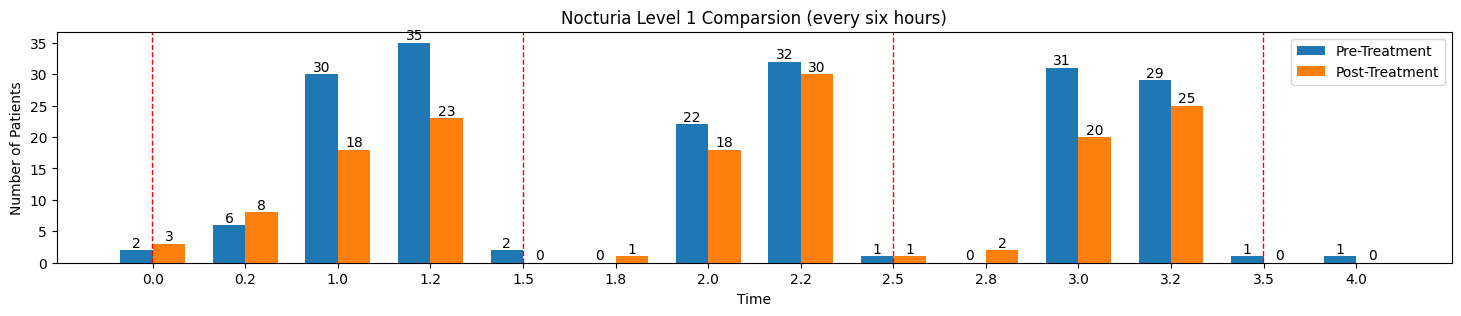

In [ ]:
plot_symptom_level_change([rounded_timeline_baseline_025, rounded_timeline_week12_025], [nocturia_participant_baseline, nocturia_participant_week12], 0, ['Pre-Treatment', 'Post-Treatment'], 'Nocturia Level 0 Comparsion (every six hours)')
plot_symptom_level_change([rounded_timeline_baseline_025, rounded_timeline_week12_025], [nocturia_participant_baseline, nocturia_participant_week12], 1, ['Pre-Treatment', 'Post-Treatment'], 'Nocturia Level 1 Comparsion (every six hours)')


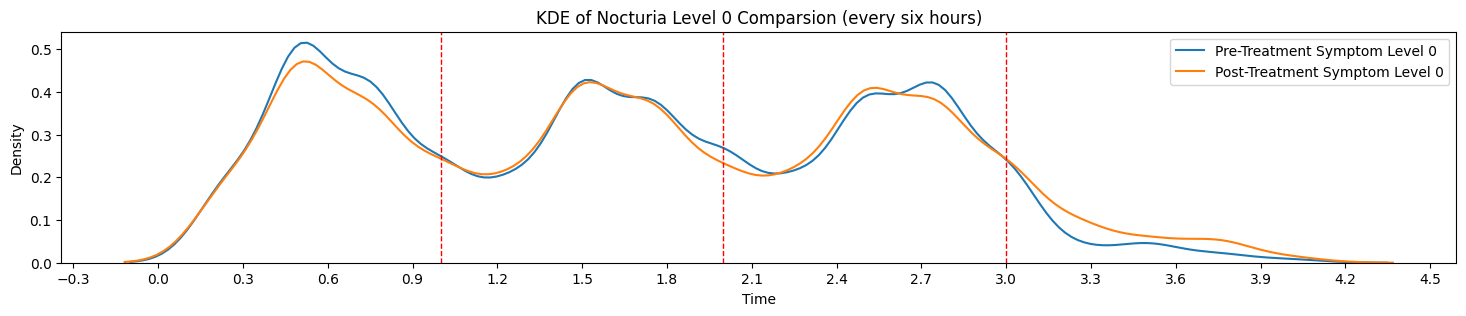

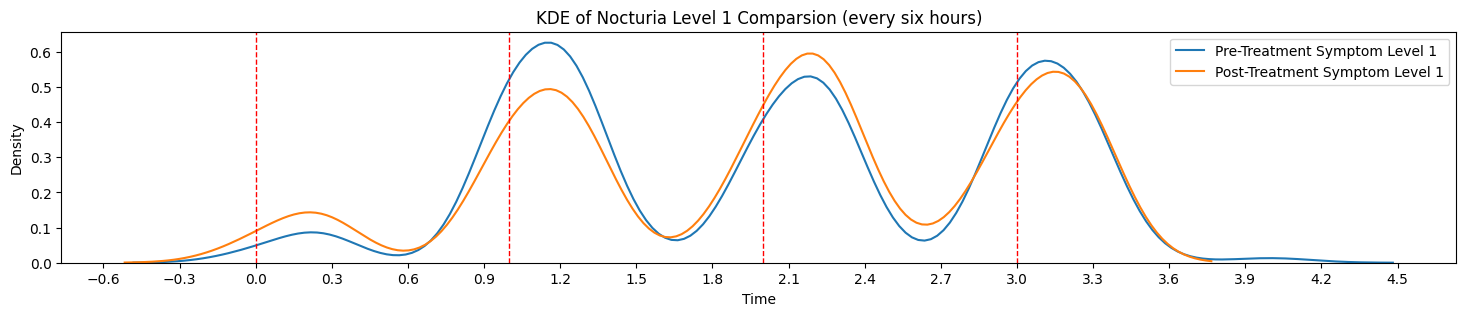

In [ ]:
plot_symptom_level_kde([rounded_timeline_baseline_025, rounded_timeline_week12_025], [nocturia_participant_baseline, nocturia_participant_week12], 0, ['Pre-Treatment', 'Post-Treatment'], 'KDE of Nocturia Level 0 Comparsion (every six hours)')
plot_symptom_level_kde([rounded_timeline_baseline_025, rounded_timeline_week12_025], [nocturia_participant_baseline, nocturia_participant_week12], 1, ['Pre-Treatment', 'Post-Treatment'], 'KDE of Nocturia Level 1 Comparsion (every six hours)')
